In [ ]:
import argparse
#import json
import os
import logging
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import KFold
from torchvision import datasets, transforms
from sklearn.metrics import matthews_corrcoef
#from torch.utils.tensorboard import SummaryWriter
import numpy as np
from torchvision import models
!pip install efficientnet-pytorch
from efficientnet_pytorch import EfficientNet
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2 as ToTensor
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
# from torch.cuda.amp import GradScaler
workspace_path = "C:/Users/ProArt/Desktop/ozan/opticdisc/"
os.chdir(workspace_path)
#print(os.getcwd())

In [ ]:
seed = 42
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
os.environ["PYTHONHASHSEED"] = str(seed)

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    try:
        torch.use_deterministic_algorithms(True)
    except Exception:
        pass

set_seed(seed)

In [ ]:
def parse_args(argv=[]):
    parser = argparse.ArgumentParser(description="Deep Neural Network based Cross-Branch Feature Fusion Attention Network for Optic Disc Image Classification")

    # Hyperparameters
    parser.add_argument('--batch_size', type=int, default=32, help='Batch size for training')
    parser.add_argument('--learning_rate', type=float, default=0.0001, help='Learning rate for the optimizer')
    parser.add_argument('--weight_decay_rate', type=float, default=0.0001, help='Weight decay rate for the AdamW optimizer')
    parser.add_argument('--epochs', type=int, default=50, help='Number of epochs for training')
    parser.add_argument('--model', type=str, default='AttentionCNNCombined', choices=['AttentionCNNCombined'], help='Model type')
    parser.add_argument('--log_dir', type=str, default='./logs', help='Directory for TensorBoard logs')
    parser.add_argument('--checkpoint_dir', type=str, default='./checkpoints', help='Directory for model checkpoints')
    parser.add_argument('--device', type=str, default=None, choices=['cpu', 'cuda'],
                        help='Device to run the model on. "cpu" or "cuda". Default is "cuda" if a GPU is available.')

    args = parser.parse_args(argv)

    if args.device is None:
        args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    return vars(args)



def setup_logging(log_dir='./logs'):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    log_filename = os.path.join(log_dir, "training.log")

    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s",
        handlers=[
            logging.FileHandler(log_filename),
            logging.StreamHandler()
        ]
    )
    logging.info("Logging setup complete. Logs are saved in '%s'", log_filename)

def log_epoch_metrics(epoch, metrics):
    logging.info(f"Epoch {epoch}: Train Loss = {metrics['train_loss']:.4f}, "
                 f"Train Accuracy = {metrics['train_accuracy']:.2f}%, "
                 f"Train Dice = {metrics['train_dice']:.2f}, "
                 f"Train MCC = {metrics['train_mcc']:.2f}, "
                 f"Val Loss = {metrics['val_loss']:.4f}, "
                 f"Val Accuracy = {metrics['val_accuracy']:.2f}%,"
                 f"Val Dice = {metrics['val_dice']:.4f}, "
                 f"Val MCC = {metrics['val_mcc']:.4f} ")



albumentations_transforms = A.Compose([ A.HorizontalFlip(p=0.5),
                                        A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.0, 0.1), always_apply=None, p=0.5),

                            A.OneOf([A.CLAHE(clip_limit=1.0, tile_grid_size=(1, 1), always_apply=None), A.RandomBrightnessContrast()], p=0.5),
                            A.GaussNoise(var_limit=(0, 10), mean=np.random.choice([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]), p=0.5),
                            A.Resize(height=224, width=224),
                            A.Normalize(),
                            ToTensor()
                                    ])

class Transform():
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image):
        return self.transform(image=np.array(image))["image"]


train_dir = 'C:/Users/ProArt/Desktop/ozan/opticdisc/Train'


class AttentionCNNCombined(nn.Module):
    def __init__(self, n_class = 6, num_heads=8, hidden_dim=256):
        super(AttentionCNNCombined, self).__init__()

        self.resnet = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)
        self.resnet.fc = nn.Identity()

        self.efficientnet = EfficientNet.from_pretrained("efficientnet-b0")
        self.efficientnet._fc = nn.Identity()

        resnet_output_dim = 2048
        efficientnet_output_dim = 1280

        self.attention = nn.MultiheadAttention(embed_dim=resnet_output_dim + efficientnet_output_dim,
                                               num_heads=num_heads, dropout=0.5)

        self.fc = nn.Sequential(
            nn.Linear(resnet_output_dim + efficientnet_output_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_class)
        )

    def forward(self, x):
        resnet_out = self.resnet(x)  # Shape: (batch_size, resnet_channels)
        efficientnet_out = self.efficientnet(x)  # (batch_size, efficientnet_channels)


        # print(f"efficientnet shape: {efficientnet_out.shape}")
        # print(f"resnet50 shape: {resnet_out.shape}")

        combined_features = torch.cat((resnet_out, efficientnet_out), dim=1)  # Shape: (batch_size, combined_channels)
        combined_features = combined_features.unsqueeze(0)
        attn_output, _ = self.attention(combined_features, combined_features, combined_features)  # Self-attention for query, key, values
        attn_output = attn_output.squeeze(0)

        output = self.fc(attn_output)  #(batch_size, num_classes)

        return output


model = AttentionCNNCombined(n_class = 6)


def dice_coefficient(pred, target, threshold=0.5):
    pred = pred > threshold
    target = target > threshold
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return 2 * intersection / union if union > 0 else 0


def mcc(pred, target):
    return matthews_corrcoef(target.flatten(), pred.flatten())



def train_epoch(model, train_loader, criterion, optimizer, config):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    itr = 0
    accumulation_steps = 64 // len(train_loader)

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(config['device']), labels.to(config['device'])
        optimizer.zero_grad()
        outputs = model(inputs).to(config['device'])
        loss = criterion(outputs, labels)
        loss = loss / accumulation_steps
        loss.backward()
        #Gradient Accumulation
        if (itr + 1 ) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        itr += 1

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.append(predicted)
        all_labels.append(labels)

    accuracy = 100 * correct / total
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)


    dice_train = dice_coefficient(all_preds.cpu().numpy(), all_labels.cpu().numpy())
    mcc_train = mcc(all_preds.cpu().numpy(), all_labels.cpu().numpy())

    return running_loss / len(train_loader), accuracy, dice_train, mcc_train



def validate_epoch(model, val_loader, criterion, config):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs = inputs.to(config['device'])
            labels = labels.to(config['device'])

            outputs = model(inputs).to(config['device'])

            outputs = outputs.view(outputs.size(0), -1)

            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.append(predicted)
            all_labels.append(labels)

    accuracy = 100 * correct / total
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)


    dice_val = dice_coefficient(all_preds.cpu().numpy(), all_labels.cpu().numpy())
    mcc_val = mcc(all_preds.cpu().numpy(), all_labels.cpu().numpy())

    return running_loss / len(val_loader), accuracy, dice_val, mcc_val

#command line usage
#(opticdisc) PS C:\Ukfoldrs\ozangokkan\Desktop\OpticDisc>
#python opticdisc.py --batch_size 32 --learning_rate 0.0001 --epochs 30 --model
#CombinedModel --log_dir ./logs --checkpoint_dir ./checkpoints --device cuda

fold_metrics = []

def main():
    config = parse_args(argv=[])
    setup_logging(config['log_dir'])
    train_dataset = ImageFolder(train_dir, transform=Transform(albumentations_transforms))

    k = 5  # k fold cross-validation

    kfold = KFold(n_splits=k, shuffle=True, random_state=5)


    checkpoint_dir = './checkpoints'
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
        model = AttentionCNNCombined(n_class=6).to(config['device'])
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay = config['weight_decay_rate'] )
        scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=3, verbose=True)
        start = time.strftime("%H:%M:%S")
        print(f"----------- Fold: {fold + 1}  --- time: {start} -----------")
        logging.info(f"Training fold {fold+1}/{k}...")


        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], sampler=train_subsampler)
        val_loader = DataLoader(train_dataset, batch_size=config["batch_size"], sampler=val_subsampler)

        best_val_acc = -float('inf')
        best_epoch = 0
        best_checkpoint_path = ""


        for epoch in range(config["epochs"]):
            start_time = time.strftime("%H:%M:%S")
            print(f"----------- Epoch {epoch + 1}/{config['epochs']} --- time: {start_time} -----------")
            logging.info(f"Training epoch {epoch+1}/{config['epochs']}...")

            # Training phase
            train_loss, train_acc, dice_train, mcc_train = train_epoch(model, train_loader, criterion, optimizer, config)
            print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}% | "
                  f"Train Dice: {dice_train:.4f} | "
                  f"Train MCC: {mcc_train:.4f}")

            logging.info(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}% | "
                                     f"Train Dice: {dice_train:.4f} | "
                                     f"Train MCC: {mcc_train:.4f}")


            # Validation phase
            val_loss, val_acc, val_dice, val_mcc = validate_epoch(model, val_loader, criterion, config)
            print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.2f}% | "
                  f"Val Dice: {val_dice:.4f} | "
                  f"Val MCC: {val_mcc:.4f}")

            logging.info(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.2f}% | "
             f"Val Dice: {val_dice:.4f} | "
             f"Val MCC: {val_mcc:.4f}")

            scheduler.step(val_loss)

            # Log epoch metrics
            log_epoch_metrics(epoch + 1, {
                "train_loss": train_loss,
                "train_accuracy": train_acc,
                "train_dice": dice_train,
                "train_mcc": mcc_train,
                "val_loss": val_loss,
                "val_accuracy": val_acc,
                "val_dice": val_dice,
                "val_mcc": val_mcc,
            })

            print("\n}")


            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_epoch = epoch + 1
                best_checkpoint_path = os.path.join(config['checkpoint_dir'], f"best_model_fold_{fold + 1}_epoch_{best_epoch}.pth")

                torch.save(model.state_dict(), best_checkpoint_path)
                print(f"Best model checkpoint saved for fold {fold + 1}, epoch {best_epoch} to {best_checkpoint_path}")

            fold_metrics.append({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_accuracy": train_acc,
                "train_dice": dice_train,
                "train_mcc": mcc_train,
                "val_loss": val_loss,
                "val_accuracy": val_acc,
                "val_dice": val_dice,
                "val_mcc": val_mcc
            })

        # Print summary of training and validation metrics after all epochs
        for metrics in fold_metrics:
            print(f"Epoch {metrics['epoch']} - Train Loss: {metrics['train_loss']:.2f} | "
                  f"Train Accuracy: {metrics['train_accuracy']:.2f}% | "
                  f"Train Dice: {metrics['train_dice']:.2f} | "
                  f"Train MCC: {metrics['train_mcc']:.2f} | "
                  f"Val Loss: {metrics['val_loss']:.2f}% | "
                  f"Val Accuracy: {metrics['val_accuracy']:.2f}% | "
                  f"Val Dice: {metrics['val_dice']:.4f} | "
                  f"Val MCC: {metrics['val_mcc']:.4f}")



if __name__ == "__main__":
    main()

2024-12-27 15:11:01,625 - INFO - Logging setup complete. Logs are saved in './logs\training.log'


Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


C:\Users\ProArt\Documents\Anaconda\envs\bioizmir\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2024-12-27 15:11:02,296 - INFO - Training fold 1/5...
2024-12-27 15:11:02,297 - INFO - Training epoch 1/50...


----------- Fold: 1  --- time: 15:11:02 -----------
----------- Epoch 1/50 --- time: 15:11:02 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.16it/s]
2024-12-27 15:11:08,784 - INFO - Train Loss: 0.4428 | Train Accuracy: 25.22% | Train Dice: 0.8772 | Train MCC: 0.0954


Train Loss: 0.4428 | Train Accuracy: 25.22% | Train Dice: 0.8772 | Train MCC: 0.0954


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]
2024-12-27 15:11:10,204 - INFO - Val Loss: 1.7491 | Val Accuracy: 43.75% | Val Dice: 0.9378 | Val MCC: 0.2753
2024-12-27 15:11:10,205 - INFO - Epoch 1: Train Loss = 0.4428, Train Accuracy = 25.22%, Train Dice = 0.88, Train MCC = 0.10, Val Loss = 1.7491, Val Accuracy = 43.75%,Val Dice = 0.9378, Val MCC = 0.2753 


Val Loss: 1.7491 | Val Accuracy: 43.75% | Val Dice: 0.9378 | Val MCC: 0.2753

}


2024-12-27 15:11:10,528 - INFO - Training epoch 2/50...


Best model checkpoint saved for fold 1, epoch 1 to ./checkpoints\best_model_fold_1_epoch_1.pth
----------- Epoch 2/50 --- time: 15:11:10 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.15it/s]
2024-12-27 15:11:17,047 - INFO - Train Loss: 0.4264 | Train Accuracy: 36.83% | Train Dice: 0.8976 | Train MCC: 0.2216


Train Loss: 0.4264 | Train Accuracy: 36.83% | Train Dice: 0.8976 | Train MCC: 0.2216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.22it/s]
2024-12-27 15:11:18,292 - INFO - Val Loss: 1.6574 | Val Accuracy: 39.29% | Val Dice: 0.9333 | Val MCC: 0.1862
2024-12-27 15:11:18,293 - INFO - Epoch 2: Train Loss = 0.4264, Train Accuracy = 36.83%, Train Dice = 0.90, Train MCC = 0.22, Val Loss = 1.6574, Val Accuracy = 39.29%,Val Dice = 0.9333, Val MCC = 0.1862 
2024-12-27 15:11:18,294 - INFO - Training epoch 3/50...


Val Loss: 1.6574 | Val Accuracy: 39.29% | Val Dice: 0.9333 | Val MCC: 0.1862

}
----------- Epoch 3/50 --- time: 15:11:18 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.17it/s]
2024-12-27 15:11:24,755 - INFO - Train Loss: 0.4158 | Train Accuracy: 34.60% | Train Dice: 0.9162 | Train MCC: 0.2020


Train Loss: 0.4158 | Train Accuracy: 34.60% | Train Dice: 0.9162 | Train MCC: 0.2020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]
2024-12-27 15:11:26,120 - INFO - Val Loss: 1.5543 | Val Accuracy: 41.96% | Val Dice: 0.9333 | Val MCC: 0.2538
2024-12-27 15:11:26,120 - INFO - Epoch 3: Train Loss = 0.4158, Train Accuracy = 34.60%, Train Dice = 0.92, Train MCC = 0.20, Val Loss = 1.5543, Val Accuracy = 41.96%,Val Dice = 0.9333, Val MCC = 0.2538 
2024-12-27 15:11:26,121 - INFO - Training epoch 4/50...


Val Loss: 1.5543 | Val Accuracy: 41.96% | Val Dice: 0.9333 | Val MCC: 0.2538

}
----------- Epoch 4/50 --- time: 15:11:26 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.28it/s]
2024-12-27 15:11:32,267 - INFO - Train Loss: 0.4020 | Train Accuracy: 36.16% | Train Dice: 0.9225 | Train MCC: 0.2240


Train Loss: 0.4020 | Train Accuracy: 36.16% | Train Dice: 0.9225 | Train MCC: 0.2240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]
2024-12-27 15:11:33,674 - INFO - Val Loss: 1.4980 | Val Accuracy: 42.86% | Val Dice: 0.9275 | Val MCC: 0.2576
2024-12-27 15:11:33,675 - INFO - Epoch 4: Train Loss = 0.4020, Train Accuracy = 36.16%, Train Dice = 0.92, Train MCC = 0.22, Val Loss = 1.4980, Val Accuracy = 42.86%,Val Dice = 0.9275, Val MCC = 0.2576 
2024-12-27 15:11:33,675 - INFO - Training epoch 5/50...


Val Loss: 1.4980 | Val Accuracy: 42.86% | Val Dice: 0.9275 | Val MCC: 0.2576

}
----------- Epoch 5/50 --- time: 15:11:33 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.22it/s]
2024-12-27 15:11:39,980 - INFO - Train Loss: 0.3770 | Train Accuracy: 45.76% | Train Dice: 0.9275 | Train MCC: 0.3453


Train Loss: 0.3770 | Train Accuracy: 45.76% | Train Dice: 0.9275 | Train MCC: 0.3453


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]
2024-12-27 15:11:41,314 - INFO - Val Loss: 1.4606 | Val Accuracy: 49.11% | Val Dice: 0.8980 | Val MCC: 0.3481
2024-12-27 15:11:41,314 - INFO - Epoch 5: Train Loss = 0.3770, Train Accuracy = 45.76%, Train Dice = 0.93, Train MCC = 0.35, Val Loss = 1.4606, Val Accuracy = 49.11%,Val Dice = 0.8980, Val MCC = 0.3481 


Val Loss: 1.4606 | Val Accuracy: 49.11% | Val Dice: 0.8980 | Val MCC: 0.3481

}


2024-12-27 15:11:41,646 - INFO - Training epoch 6/50...


Best model checkpoint saved for fold 1, epoch 5 to ./checkpoints\best_model_fold_1_epoch_5.pth
----------- Epoch 6/50 --- time: 15:11:41 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.19it/s]
2024-12-27 15:11:48,047 - INFO - Train Loss: 0.3644 | Train Accuracy: 47.99% | Train Dice: 0.9126 | Train MCC: 0.3604


Train Loss: 0.3644 | Train Accuracy: 47.99% | Train Dice: 0.9126 | Train MCC: 0.3604


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]
2024-12-27 15:11:49,348 - INFO - Val Loss: 1.3790 | Val Accuracy: 50.89% | Val Dice: 0.8808 | Val MCC: 0.3732
2024-12-27 15:11:49,349 - INFO - Epoch 6: Train Loss = 0.3644, Train Accuracy = 47.99%, Train Dice = 0.91, Train MCC = 0.36, Val Loss = 1.3790, Val Accuracy = 50.89%,Val Dice = 0.8808, Val MCC = 0.3732 


Val Loss: 1.3790 | Val Accuracy: 50.89% | Val Dice: 0.8808 | Val MCC: 0.3732

}


2024-12-27 15:11:49,662 - INFO - Training epoch 7/50...


Best model checkpoint saved for fold 1, epoch 6 to ./checkpoints\best_model_fold_1_epoch_6.pth
----------- Epoch 7/50 --- time: 15:11:49 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.11it/s]
2024-12-27 15:11:56,300 - INFO - Train Loss: 0.3419 | Train Accuracy: 53.79% | Train Dice: 0.9377 | Train MCC: 0.4353


Train Loss: 0.3419 | Train Accuracy: 53.79% | Train Dice: 0.9377 | Train MCC: 0.4353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]
2024-12-27 15:11:57,706 - INFO - Val Loss: 1.2752 | Val Accuracy: 54.46% | Val Dice: 0.9091 | Val MCC: 0.4237
2024-12-27 15:11:57,707 - INFO - Epoch 7: Train Loss = 0.3419, Train Accuracy = 53.79%, Train Dice = 0.94, Train MCC = 0.44, Val Loss = 1.2752, Val Accuracy = 54.46%,Val Dice = 0.9091, Val MCC = 0.4237 


Val Loss: 1.2752 | Val Accuracy: 54.46% | Val Dice: 0.9091 | Val MCC: 0.4237

}


2024-12-27 15:11:58,034 - INFO - Training epoch 8/50...


Best model checkpoint saved for fold 1, epoch 7 to ./checkpoints\best_model_fold_1_epoch_7.pth
----------- Epoch 8/50 --- time: 15:11:58 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.18it/s]
2024-12-27 15:12:04,456 - INFO - Train Loss: 0.3116 | Train Accuracy: 55.13% | Train Dice: 0.9501 | Train MCC: 0.4547


Train Loss: 0.3116 | Train Accuracy: 55.13% | Train Dice: 0.9501 | Train MCC: 0.4547


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]
2024-12-27 15:12:05,765 - INFO - Val Loss: 1.2130 | Val Accuracy: 53.57% | Val Dice: 0.9417 | Val MCC: 0.4218
2024-12-27 15:12:05,765 - INFO - Epoch 8: Train Loss = 0.3116, Train Accuracy = 55.13%, Train Dice = 0.95, Train MCC = 0.45, Val Loss = 1.2130, Val Accuracy = 53.57%,Val Dice = 0.9417, Val MCC = 0.4218 
2024-12-27 15:12:05,765 - INFO - Training epoch 9/50...


Val Loss: 1.2130 | Val Accuracy: 53.57% | Val Dice: 0.9417 | Val MCC: 0.4218

}
----------- Epoch 9/50 --- time: 15:12:05 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.28it/s]
2024-12-27 15:12:11,903 - INFO - Train Loss: 0.2951 | Train Accuracy: 55.80% | Train Dice: 0.9382 | Train MCC: 0.4646


Train Loss: 0.2951 | Train Accuracy: 55.80% | Train Dice: 0.9382 | Train MCC: 0.4646


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]
2024-12-27 15:12:13,323 - INFO - Val Loss: 1.1522 | Val Accuracy: 51.79% | Val Dice: 0.9463 | Val MCC: 0.4209
2024-12-27 15:12:13,323 - INFO - Epoch 9: Train Loss = 0.2951, Train Accuracy = 55.80%, Train Dice = 0.94, Train MCC = 0.46, Val Loss = 1.1522, Val Accuracy = 51.79%,Val Dice = 0.9463, Val MCC = 0.4209 
2024-12-27 15:12:13,324 - INFO - Training epoch 10/50...


Val Loss: 1.1522 | Val Accuracy: 51.79% | Val Dice: 0.9463 | Val MCC: 0.4209

}
----------- Epoch 10/50 --- time: 15:12:13 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.22it/s]
2024-12-27 15:12:19,657 - INFO - Train Loss: 0.2966 | Train Accuracy: 54.69% | Train Dice: 0.9211 | Train MCC: 0.4517


Train Loss: 0.2966 | Train Accuracy: 54.69% | Train Dice: 0.9211 | Train MCC: 0.4517


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]
2024-12-27 15:12:21,003 - INFO - Val Loss: 1.1848 | Val Accuracy: 50.00% | Val Dice: 0.9119 | Val MCC: 0.3993
2024-12-27 15:12:21,004 - INFO - Epoch 10: Train Loss = 0.2966, Train Accuracy = 54.69%, Train Dice = 0.92, Train MCC = 0.45, Val Loss = 1.1848, Val Accuracy = 50.00%,Val Dice = 0.9119, Val MCC = 0.3993 
2024-12-27 15:12:21,004 - INFO - Training epoch 11/50...


Val Loss: 1.1848 | Val Accuracy: 50.00% | Val Dice: 0.9119 | Val MCC: 0.3993

}
----------- Epoch 11/50 --- time: 15:12:21 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.35it/s]
2024-12-27 15:12:26,964 - INFO - Train Loss: 0.2814 | Train Accuracy: 55.80% | Train Dice: 0.9106 | Train MCC: 0.4696


Train Loss: 0.2814 | Train Accuracy: 55.80% | Train Dice: 0.9106 | Train MCC: 0.4696


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s]
2024-12-27 15:12:28,417 - INFO - Val Loss: 1.1075 | Val Accuracy: 52.68% | Val Dice: 0.8947 | Val MCC: 0.4193
2024-12-27 15:12:28,417 - INFO - Epoch 11: Train Loss = 0.2814, Train Accuracy = 55.80%, Train Dice = 0.91, Train MCC = 0.47, Val Loss = 1.1075, Val Accuracy = 52.68%,Val Dice = 0.8947, Val MCC = 0.4193 
2024-12-27 15:12:28,418 - INFO - Training epoch 12/50...


Val Loss: 1.1075 | Val Accuracy: 52.68% | Val Dice: 0.8947 | Val MCC: 0.4193

}
----------- Epoch 12/50 --- time: 15:12:28 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.17it/s]
2024-12-27 15:12:34,884 - INFO - Train Loss: 0.2705 | Train Accuracy: 59.82% | Train Dice: 0.9101 | Train MCC: 0.5127


Train Loss: 0.2705 | Train Accuracy: 59.82% | Train Dice: 0.9101 | Train MCC: 0.5127


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]
2024-12-27 15:12:36,268 - INFO - Val Loss: 0.9555 | Val Accuracy: 60.71% | Val Dice: 0.9184 | Val MCC: 0.5106
2024-12-27 15:12:36,268 - INFO - Epoch 12: Train Loss = 0.2705, Train Accuracy = 59.82%, Train Dice = 0.91, Train MCC = 0.51, Val Loss = 0.9555, Val Accuracy = 60.71%,Val Dice = 0.9184, Val MCC = 0.5106 


Val Loss: 0.9555 | Val Accuracy: 60.71% | Val Dice: 0.9184 | Val MCC: 0.5106

}


2024-12-27 15:12:36,578 - INFO - Training epoch 13/50...


Best model checkpoint saved for fold 1, epoch 12 to ./checkpoints\best_model_fold_1_epoch_12.pth
----------- Epoch 13/50 --- time: 15:12:36 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.37it/s]
2024-12-27 15:12:42,509 - INFO - Train Loss: 0.2487 | Train Accuracy: 61.38% | Train Dice: 0.9288 | Train MCC: 0.5303


Train Loss: 0.2487 | Train Accuracy: 61.38% | Train Dice: 0.9288 | Train MCC: 0.5303


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]
2024-12-27 15:12:43,981 - INFO - Val Loss: 0.9264 | Val Accuracy: 66.96% | Val Dice: 0.9596 | Val MCC: 0.5814
2024-12-27 15:12:43,982 - INFO - Epoch 13: Train Loss = 0.2487, Train Accuracy = 61.38%, Train Dice = 0.93, Train MCC = 0.53, Val Loss = 0.9264, Val Accuracy = 66.96%,Val Dice = 0.9596, Val MCC = 0.5814 


Val Loss: 0.9264 | Val Accuracy: 66.96% | Val Dice: 0.9596 | Val MCC: 0.5814

}


2024-12-27 15:12:44,311 - INFO - Training epoch 14/50...


Best model checkpoint saved for fold 1, epoch 13 to ./checkpoints\best_model_fold_1_epoch_13.pth
----------- Epoch 14/50 --- time: 15:12:44 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.16it/s]
2024-12-27 15:12:50,808 - INFO - Train Loss: 0.2430 | Train Accuracy: 62.95% | Train Dice: 0.9393 | Train MCC: 0.5486


Train Loss: 0.2430 | Train Accuracy: 62.95% | Train Dice: 0.9393 | Train MCC: 0.5486


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]
2024-12-27 15:12:52,047 - INFO - Val Loss: 0.9769 | Val Accuracy: 58.93% | Val Dice: 0.9128 | Val MCC: 0.5054
2024-12-27 15:12:52,047 - INFO - Epoch 14: Train Loss = 0.2430, Train Accuracy = 62.95%, Train Dice = 0.94, Train MCC = 0.55, Val Loss = 0.9769, Val Accuracy = 58.93%,Val Dice = 0.9128, Val MCC = 0.5054 
2024-12-27 15:12:52,047 - INFO - Training epoch 15/50...


Val Loss: 0.9769 | Val Accuracy: 58.93% | Val Dice: 0.9128 | Val MCC: 0.5054

}
----------- Epoch 15/50 --- time: 15:12:52 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.21it/s]
2024-12-27 15:12:58,372 - INFO - Train Loss: 0.2337 | Train Accuracy: 63.17% | Train Dice: 0.9388 | Train MCC: 0.5641


Train Loss: 0.2337 | Train Accuracy: 63.17% | Train Dice: 0.9388 | Train MCC: 0.5641


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]
2024-12-27 15:12:59,649 - INFO - Val Loss: 0.9872 | Val Accuracy: 60.71% | Val Dice: 0.9394 | Val MCC: 0.5348
2024-12-27 15:12:59,649 - INFO - Epoch 15: Train Loss = 0.2337, Train Accuracy = 63.17%, Train Dice = 0.94, Train MCC = 0.56, Val Loss = 0.9872, Val Accuracy = 60.71%,Val Dice = 0.9394, Val MCC = 0.5348 
2024-12-27 15:12:59,650 - INFO - Training epoch 16/50...


Val Loss: 0.9872 | Val Accuracy: 60.71% | Val Dice: 0.9394 | Val MCC: 0.5348

}
----------- Epoch 16/50 --- time: 15:12:59 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.27it/s]
2024-12-27 15:13:05,835 - INFO - Train Loss: 0.2545 | Train Accuracy: 61.83% | Train Dice: 0.9279 | Train MCC: 0.5490


Train Loss: 0.2545 | Train Accuracy: 61.83% | Train Dice: 0.9279 | Train MCC: 0.5490


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]
2024-12-27 15:13:07,208 - INFO - Val Loss: 1.0078 | Val Accuracy: 62.50% | Val Dice: 0.9453 | Val MCC: 0.5441
2024-12-27 15:13:07,209 - INFO - Epoch 16: Train Loss = 0.2545, Train Accuracy = 61.83%, Train Dice = 0.93, Train MCC = 0.55, Val Loss = 1.0078, Val Accuracy = 62.50%,Val Dice = 0.9453, Val MCC = 0.5441 
2024-12-27 15:13:07,209 - INFO - Training epoch 17/50...


Val Loss: 1.0078 | Val Accuracy: 62.50% | Val Dice: 0.9453 | Val MCC: 0.5441

}
----------- Epoch 17/50 --- time: 15:13:07 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.32it/s]
2024-12-27 15:13:13,261 - INFO - Train Loss: 0.2177 | Train Accuracy: 67.41% | Train Dice: 0.9470 | Train MCC: 0.6047


Train Loss: 0.2177 | Train Accuracy: 67.41% | Train Dice: 0.9470 | Train MCC: 0.6047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]
2024-12-27 15:13:14,655 - INFO - Val Loss: 0.7472 | Val Accuracy: 79.46% | Val Dice: 0.9703 | Val MCC: 0.7430
2024-12-27 15:13:14,655 - INFO - Epoch 17: Train Loss = 0.2177, Train Accuracy = 67.41%, Train Dice = 0.95, Train MCC = 0.60, Val Loss = 0.7472, Val Accuracy = 79.46%,Val Dice = 0.9703, Val MCC = 0.7430 


Val Loss: 0.7472 | Val Accuracy: 79.46% | Val Dice: 0.9703 | Val MCC: 0.7430

}


2024-12-27 15:13:14,979 - INFO - Training epoch 18/50...


Best model checkpoint saved for fold 1, epoch 17 to ./checkpoints\best_model_fold_1_epoch_17.pth
----------- Epoch 18/50 --- time: 15:13:14 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.27it/s]
2024-12-27 15:13:21,159 - INFO - Train Loss: 0.1972 | Train Accuracy: 71.65% | Train Dice: 0.9472 | Train MCC: 0.6546


Train Loss: 0.1972 | Train Accuracy: 71.65% | Train Dice: 0.9472 | Train MCC: 0.6546


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]
2024-12-27 15:13:22,564 - INFO - Val Loss: 0.7634 | Val Accuracy: 70.54% | Val Dice: 0.9353 | Val MCC: 0.6356
2024-12-27 15:13:22,565 - INFO - Epoch 18: Train Loss = 0.1972, Train Accuracy = 71.65%, Train Dice = 0.95, Train MCC = 0.65, Val Loss = 0.7634, Val Accuracy = 70.54%,Val Dice = 0.9353, Val MCC = 0.6356 
2024-12-27 15:13:22,565 - INFO - Training epoch 19/50...


Val Loss: 0.7634 | Val Accuracy: 70.54% | Val Dice: 0.9353 | Val MCC: 0.6356

}
----------- Epoch 19/50 --- time: 15:13:22 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.17it/s]
2024-12-27 15:13:29,024 - INFO - Train Loss: 0.1955 | Train Accuracy: 69.42% | Train Dice: 0.9465 | Train MCC: 0.6291


Train Loss: 0.1955 | Train Accuracy: 69.42% | Train Dice: 0.9465 | Train MCC: 0.6291


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]
2024-12-27 15:13:30,383 - INFO - Val Loss: 0.7066 | Val Accuracy: 77.68% | Val Dice: 0.9436 | Val MCC: 0.7205
2024-12-27 15:13:30,384 - INFO - Epoch 19: Train Loss = 0.1955, Train Accuracy = 69.42%, Train Dice = 0.95, Train MCC = 0.63, Val Loss = 0.7066, Val Accuracy = 77.68%,Val Dice = 0.9436, Val MCC = 0.7205 
2024-12-27 15:13:30,384 - INFO - Training epoch 20/50...


Val Loss: 0.7066 | Val Accuracy: 77.68% | Val Dice: 0.9436 | Val MCC: 0.7205

}
----------- Epoch 20/50 --- time: 15:13:30 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.30it/s]
2024-12-27 15:13:36,482 - INFO - Train Loss: 0.1998 | Train Accuracy: 71.88% | Train Dice: 0.9630 | Train MCC: 0.6570


Train Loss: 0.1998 | Train Accuracy: 71.88% | Train Dice: 0.9630 | Train MCC: 0.6570


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]
2024-12-27 15:13:37,828 - INFO - Val Loss: 0.6671 | Val Accuracy: 77.68% | Val Dice: 0.9557 | Val MCC: 0.7167
2024-12-27 15:13:37,828 - INFO - Epoch 20: Train Loss = 0.1998, Train Accuracy = 71.88%, Train Dice = 0.96, Train MCC = 0.66, Val Loss = 0.6671, Val Accuracy = 77.68%,Val Dice = 0.9557, Val MCC = 0.7167 
2024-12-27 15:13:37,828 - INFO - Training epoch 21/50...


Val Loss: 0.6671 | Val Accuracy: 77.68% | Val Dice: 0.9557 | Val MCC: 0.7167

}
----------- Epoch 21/50 --- time: 15:13:37 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.22it/s]
2024-12-27 15:13:44,136 - INFO - Train Loss: 0.1772 | Train Accuracy: 74.78% | Train Dice: 0.9701 | Train MCC: 0.6954


Train Loss: 0.1772 | Train Accuracy: 74.78% | Train Dice: 0.9701 | Train MCC: 0.6954


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]
2024-12-27 15:13:45,451 - INFO - Val Loss: 0.8349 | Val Accuracy: 73.21% | Val Dice: 0.9561 | Val MCC: 0.6692
2024-12-27 15:13:45,451 - INFO - Epoch 21: Train Loss = 0.1772, Train Accuracy = 74.78%, Train Dice = 0.97, Train MCC = 0.70, Val Loss = 0.8349, Val Accuracy = 73.21%,Val Dice = 0.9561, Val MCC = 0.6692 
2024-12-27 15:13:45,451 - INFO - Training epoch 22/50...


Val Loss: 0.8349 | Val Accuracy: 73.21% | Val Dice: 0.9561 | Val MCC: 0.6692

}
----------- Epoch 22/50 --- time: 15:13:45 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.16it/s]
2024-12-27 15:13:51,945 - INFO - Train Loss: 0.1989 | Train Accuracy: 71.43% | Train Dice: 0.9603 | Train MCC: 0.6536


Train Loss: 0.1989 | Train Accuracy: 71.43% | Train Dice: 0.9603 | Train MCC: 0.6536


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]
2024-12-27 15:13:53,292 - INFO - Val Loss: 0.9613 | Val Accuracy: 65.18% | Val Dice: 0.9360 | Val MCC: 0.5661
2024-12-27 15:13:53,292 - INFO - Epoch 22: Train Loss = 0.1989, Train Accuracy = 71.43%, Train Dice = 0.96, Train MCC = 0.65, Val Loss = 0.9613, Val Accuracy = 65.18%,Val Dice = 0.9360, Val MCC = 0.5661 
2024-12-27 15:13:53,293 - INFO - Training epoch 23/50...


Val Loss: 0.9613 | Val Accuracy: 65.18% | Val Dice: 0.9360 | Val MCC: 0.5661

}
----------- Epoch 23/50 --- time: 15:13:53 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.23it/s]
2024-12-27 15:13:59,595 - INFO - Train Loss: 0.2138 | Train Accuracy: 70.76% | Train Dice: 0.9629 | Train MCC: 0.6439


Train Loss: 0.2138 | Train Accuracy: 70.76% | Train Dice: 0.9629 | Train MCC: 0.6439


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]
2024-12-27 15:14:01,032 - INFO - Val Loss: 0.7039 | Val Accuracy: 76.79% | Val Dice: 0.9552 | Val MCC: 0.7105
2024-12-27 15:14:01,033 - INFO - Epoch 23: Train Loss = 0.2138, Train Accuracy = 70.76%, Train Dice = 0.96, Train MCC = 0.64, Val Loss = 0.7039, Val Accuracy = 76.79%,Val Dice = 0.9552, Val MCC = 0.7105 
2024-12-27 15:14:01,033 - INFO - Training epoch 24/50...


Val Loss: 0.7039 | Val Accuracy: 76.79% | Val Dice: 0.9552 | Val MCC: 0.7105

}
----------- Epoch 24/50 --- time: 15:14:01 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.23it/s]
2024-12-27 15:14:07,324 - INFO - Train Loss: 0.1957 | Train Accuracy: 70.31% | Train Dice: 0.9526 | Train MCC: 0.6412


Train Loss: 0.1957 | Train Accuracy: 70.31% | Train Dice: 0.9526 | Train MCC: 0.6412


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.62it/s]
2024-12-27 15:14:08,868 - INFO - Val Loss: 0.7266 | Val Accuracy: 72.32% | Val Dice: 0.9612 | Val MCC: 0.6570
2024-12-27 15:14:08,868 - INFO - Epoch 24: Train Loss = 0.1957, Train Accuracy = 70.31%, Train Dice = 0.95, Train MCC = 0.64, Val Loss = 0.7266, Val Accuracy = 72.32%,Val Dice = 0.9612, Val MCC = 0.6570 
2024-12-27 15:14:08,869 - INFO - Training epoch 25/50...


Val Loss: 0.7266 | Val Accuracy: 72.32% | Val Dice: 0.9612 | Val MCC: 0.6570

}
----------- Epoch 25/50 --- time: 15:14:08 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.11it/s]
2024-12-27 15:14:15,513 - INFO - Train Loss: 0.1701 | Train Accuracy: 75.45% | Train Dice: 0.9562 | Train MCC: 0.7017


Train Loss: 0.1701 | Train Accuracy: 75.45% | Train Dice: 0.9562 | Train MCC: 0.7017


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]
2024-12-27 15:14:16,951 - INFO - Val Loss: 0.6263 | Val Accuracy: 75.00% | Val Dice: 0.9552 | Val MCC: 0.6840
2024-12-27 15:14:16,952 - INFO - Epoch 25: Train Loss = 0.1701, Train Accuracy = 75.45%, Train Dice = 0.96, Train MCC = 0.70, Val Loss = 0.6263, Val Accuracy = 75.00%,Val Dice = 0.9552, Val MCC = 0.6840 
2024-12-27 15:14:16,952 - INFO - Training epoch 26/50...


Val Loss: 0.6263 | Val Accuracy: 75.00% | Val Dice: 0.9552 | Val MCC: 0.6840

}
----------- Epoch 26/50 --- time: 15:14:16 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.15it/s]
2024-12-27 15:14:23,476 - INFO - Train Loss: 0.1730 | Train Accuracy: 74.33% | Train Dice: 0.9689 | Train MCC: 0.6895


Train Loss: 0.1730 | Train Accuracy: 74.33% | Train Dice: 0.9689 | Train MCC: 0.6895


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]
2024-12-27 15:14:24,767 - INFO - Val Loss: 0.6776 | Val Accuracy: 76.79% | Val Dice: 0.9490 | Val MCC: 0.7077
2024-12-27 15:14:24,769 - INFO - Epoch 26: Train Loss = 0.1730, Train Accuracy = 74.33%, Train Dice = 0.97, Train MCC = 0.69, Val Loss = 0.6776, Val Accuracy = 76.79%,Val Dice = 0.9490, Val MCC = 0.7077 
2024-12-27 15:14:24,769 - INFO - Training epoch 27/50...


Val Loss: 0.6776 | Val Accuracy: 76.79% | Val Dice: 0.9490 | Val MCC: 0.7077

}
----------- Epoch 27/50 --- time: 15:14:24 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.29it/s]
2024-12-27 15:14:30,886 - INFO - Train Loss: 0.1600 | Train Accuracy: 75.67% | Train Dice: 0.9690 | Train MCC: 0.7053


Train Loss: 0.1600 | Train Accuracy: 75.67% | Train Dice: 0.9690 | Train MCC: 0.7053


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.72it/s]
2024-12-27 15:14:32,360 - INFO - Val Loss: 0.7729 | Val Accuracy: 72.32% | Val Dice: 0.9400 | Val MCC: 0.6561
2024-12-27 15:14:32,361 - INFO - Epoch 27: Train Loss = 0.1600, Train Accuracy = 75.67%, Train Dice = 0.97, Train MCC = 0.71, Val Loss = 0.7729, Val Accuracy = 72.32%,Val Dice = 0.9400, Val MCC = 0.6561 
2024-12-27 15:14:32,361 - INFO - Training epoch 28/50...


Val Loss: 0.7729 | Val Accuracy: 72.32% | Val Dice: 0.9400 | Val MCC: 0.6561

}
----------- Epoch 28/50 --- time: 15:14:32 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.16it/s]
2024-12-27 15:14:38,868 - INFO - Train Loss: 0.1572 | Train Accuracy: 78.79% | Train Dice: 0.9723 | Train MCC: 0.7430


Train Loss: 0.1572 | Train Accuracy: 78.79% | Train Dice: 0.9723 | Train MCC: 0.7430


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]
2024-12-27 15:14:40,327 - INFO - Val Loss: 0.7392 | Val Accuracy: 75.00% | Val Dice: 0.9400 | Val MCC: 0.6837
2024-12-27 15:14:40,327 - INFO - Epoch 28: Train Loss = 0.1572, Train Accuracy = 78.79%, Train Dice = 0.97, Train MCC = 0.74, Val Loss = 0.7392, Val Accuracy = 75.00%,Val Dice = 0.9400, Val MCC = 0.6837 
2024-12-27 15:14:40,327 - INFO - Training epoch 29/50...


Val Loss: 0.7392 | Val Accuracy: 75.00% | Val Dice: 0.9400 | Val MCC: 0.6837

}
----------- Epoch 29/50 --- time: 15:14:40 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.28it/s]
2024-12-27 15:14:46,462 - INFO - Train Loss: 0.1588 | Train Accuracy: 75.89% | Train Dice: 0.9612 | Train MCC: 0.7088


Train Loss: 0.1588 | Train Accuracy: 75.89% | Train Dice: 0.9612 | Train MCC: 0.7088


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]
2024-12-27 15:14:47,919 - INFO - Val Loss: 0.6383 | Val Accuracy: 75.89% | Val Dice: 0.9557 | Val MCC: 0.7007
2024-12-27 15:14:47,919 - INFO - Epoch 29: Train Loss = 0.1588, Train Accuracy = 75.89%, Train Dice = 0.96, Train MCC = 0.71, Val Loss = 0.6383, Val Accuracy = 75.89%,Val Dice = 0.9557, Val MCC = 0.7007 
2024-12-27 15:14:47,920 - INFO - Training epoch 30/50...


Val Loss: 0.6383 | Val Accuracy: 75.89% | Val Dice: 0.9557 | Val MCC: 0.7007

}
----------- Epoch 30/50 --- time: 15:14:47 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.20it/s]
2024-12-27 15:14:54,294 - INFO - Train Loss: 0.1777 | Train Accuracy: 72.54% | Train Dice: 0.9555 | Train MCC: 0.6670


Train Loss: 0.1777 | Train Accuracy: 72.54% | Train Dice: 0.9555 | Train MCC: 0.6670


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]
2024-12-27 15:14:55,620 - INFO - Val Loss: 0.6214 | Val Accuracy: 71.43% | Val Dice: 0.9561 | Val MCC: 0.6401
2024-12-27 15:14:55,620 - INFO - Epoch 30: Train Loss = 0.1777, Train Accuracy = 72.54%, Train Dice = 0.96, Train MCC = 0.67, Val Loss = 0.6214, Val Accuracy = 71.43%,Val Dice = 0.9561, Val MCC = 0.6401 
2024-12-27 15:14:55,621 - INFO - Training epoch 31/50...


Val Loss: 0.6214 | Val Accuracy: 71.43% | Val Dice: 0.9561 | Val MCC: 0.6401

}
----------- Epoch 31/50 --- time: 15:14:55 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.28it/s]
2024-12-27 15:15:01,768 - INFO - Train Loss: 0.1442 | Train Accuracy: 80.36% | Train Dice: 0.9674 | Train MCC: 0.7614


Train Loss: 0.1442 | Train Accuracy: 80.36% | Train Dice: 0.9674 | Train MCC: 0.7614


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.72it/s]
2024-12-27 15:15:03,243 - INFO - Val Loss: 0.7054 | Val Accuracy: 73.21% | Val Dice: 0.9353 | Val MCC: 0.6681
2024-12-27 15:15:03,244 - INFO - Epoch 31: Train Loss = 0.1442, Train Accuracy = 80.36%, Train Dice = 0.97, Train MCC = 0.76, Val Loss = 0.7054, Val Accuracy = 73.21%,Val Dice = 0.9353, Val MCC = 0.6681 
2024-12-27 15:15:03,244 - INFO - Training epoch 32/50...


Val Loss: 0.7054 | Val Accuracy: 73.21% | Val Dice: 0.9353 | Val MCC: 0.6681

}
----------- Epoch 32/50 --- time: 15:15:03 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.24it/s]
2024-12-27 15:15:09,522 - INFO - Train Loss: 0.1710 | Train Accuracy: 76.56% | Train Dice: 0.9609 | Train MCC: 0.7155


Train Loss: 0.1710 | Train Accuracy: 76.56% | Train Dice: 0.9609 | Train MCC: 0.7155


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.02it/s]
2024-12-27 15:15:10,853 - INFO - Val Loss: 0.8061 | Val Accuracy: 71.43% | Val Dice: 0.9608 | Val MCC: 0.6421
2024-12-27 15:15:10,853 - INFO - Epoch 32: Train Loss = 0.1710, Train Accuracy = 76.56%, Train Dice = 0.96, Train MCC = 0.72, Val Loss = 0.8061, Val Accuracy = 71.43%,Val Dice = 0.9608, Val MCC = 0.6421 
2024-12-27 15:15:10,853 - INFO - Training epoch 33/50...


Val Loss: 0.8061 | Val Accuracy: 71.43% | Val Dice: 0.9608 | Val MCC: 0.6421

}
----------- Epoch 33/50 --- time: 15:15:10 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.21it/s]
2024-12-27 15:15:17,187 - INFO - Train Loss: 0.1534 | Train Accuracy: 76.12% | Train Dice: 0.9663 | Train MCC: 0.7100


Train Loss: 0.1534 | Train Accuracy: 76.12% | Train Dice: 0.9663 | Train MCC: 0.7100


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]
2024-12-27 15:15:18,525 - INFO - Val Loss: 0.7173 | Val Accuracy: 72.32% | Val Dice: 0.9485 | Val MCC: 0.6543
2024-12-27 15:15:18,526 - INFO - Epoch 33: Train Loss = 0.1534, Train Accuracy = 76.12%, Train Dice = 0.97, Train MCC = 0.71, Val Loss = 0.7173, Val Accuracy = 72.32%,Val Dice = 0.9485, Val MCC = 0.6543 
2024-12-27 15:15:18,526 - INFO - Training epoch 34/50...


Val Loss: 0.7173 | Val Accuracy: 72.32% | Val Dice: 0.9485 | Val MCC: 0.6543

}
----------- Epoch 34/50 --- time: 15:15:18 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.18it/s]
2024-12-27 15:15:24,961 - INFO - Train Loss: 0.1540 | Train Accuracy: 77.68% | Train Dice: 0.9725 | Train MCC: 0.7292


Train Loss: 0.1540 | Train Accuracy: 77.68% | Train Dice: 0.9725 | Train MCC: 0.7292


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s]
2024-12-27 15:15:26,404 - INFO - Val Loss: 0.6009 | Val Accuracy: 77.68% | Val Dice: 0.9604 | Val MCC: 0.7154
2024-12-27 15:15:26,404 - INFO - Epoch 34: Train Loss = 0.1540, Train Accuracy = 77.68%, Train Dice = 0.97, Train MCC = 0.73, Val Loss = 0.6009, Val Accuracy = 77.68%,Val Dice = 0.9604, Val MCC = 0.7154 
2024-12-27 15:15:26,404 - INFO - Training epoch 35/50...


Val Loss: 0.6009 | Val Accuracy: 77.68% | Val Dice: 0.9604 | Val MCC: 0.7154

}
----------- Epoch 35/50 --- time: 15:15:26 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.34it/s]
2024-12-27 15:15:32,386 - INFO - Train Loss: 0.1519 | Train Accuracy: 79.46% | Train Dice: 0.9662 | Train MCC: 0.7513


Train Loss: 0.1519 | Train Accuracy: 79.46% | Train Dice: 0.9662 | Train MCC: 0.7513


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]
2024-12-27 15:15:33,762 - INFO - Val Loss: 0.6677 | Val Accuracy: 78.57% | Val Dice: 0.9648 | Val MCC: 0.7312
2024-12-27 15:15:33,762 - INFO - Epoch 35: Train Loss = 0.1519, Train Accuracy = 79.46%, Train Dice = 0.97, Train MCC = 0.75, Val Loss = 0.6677, Val Accuracy = 78.57%,Val Dice = 0.9648, Val MCC = 0.7312 
2024-12-27 15:15:33,762 - INFO - Training epoch 36/50...


Val Loss: 0.6677 | Val Accuracy: 78.57% | Val Dice: 0.9648 | Val MCC: 0.7312

}
----------- Epoch 36/50 --- time: 15:15:33 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.32it/s]
2024-12-27 15:15:39,799 - INFO - Train Loss: 0.1512 | Train Accuracy: 79.02% | Train Dice: 0.9676 | Train MCC: 0.7459


Train Loss: 0.1512 | Train Accuracy: 79.02% | Train Dice: 0.9676 | Train MCC: 0.7459


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]
2024-12-27 15:15:41,150 - INFO - Val Loss: 0.5743 | Val Accuracy: 79.46% | Val Dice: 0.9600 | Val MCC: 0.7401
2024-12-27 15:15:41,150 - INFO - Epoch 36: Train Loss = 0.1512, Train Accuracy = 79.02%, Train Dice = 0.97, Train MCC = 0.75, Val Loss = 0.5743, Val Accuracy = 79.46%,Val Dice = 0.9600, Val MCC = 0.7401 
2024-12-27 15:15:41,150 - INFO - Training epoch 37/50...


Val Loss: 0.5743 | Val Accuracy: 79.46% | Val Dice: 0.9600 | Val MCC: 0.7401

}
----------- Epoch 37/50 --- time: 15:15:41 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.22it/s]
2024-12-27 15:15:47,467 - INFO - Train Loss: 0.1478 | Train Accuracy: 77.46% | Train Dice: 0.9728 | Train MCC: 0.7272


Train Loss: 0.1478 | Train Accuracy: 77.46% | Train Dice: 0.9728 | Train MCC: 0.7272


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]
2024-12-27 15:15:48,875 - INFO - Val Loss: 0.6705 | Val Accuracy: 75.00% | Val Dice: 0.9458 | Val MCC: 0.6848
2024-12-27 15:15:48,875 - INFO - Epoch 37: Train Loss = 0.1478, Train Accuracy = 77.46%, Train Dice = 0.97, Train MCC = 0.73, Val Loss = 0.6705, Val Accuracy = 75.00%,Val Dice = 0.9458, Val MCC = 0.6848 
2024-12-27 15:15:48,875 - INFO - Training epoch 38/50...


Val Loss: 0.6705 | Val Accuracy: 75.00% | Val Dice: 0.9458 | Val MCC: 0.6848

}
----------- Epoch 38/50 --- time: 15:15:48 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.16it/s]
2024-12-27 15:15:55,352 - INFO - Train Loss: 0.1433 | Train Accuracy: 79.69% | Train Dice: 0.9701 | Train MCC: 0.7532


Train Loss: 0.1433 | Train Accuracy: 79.69% | Train Dice: 0.9701 | Train MCC: 0.7532


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]
2024-12-27 15:15:56,750 - INFO - Val Loss: 0.8434 | Val Accuracy: 70.54% | Val Dice: 0.9293 | Val MCC: 0.6271
2024-12-27 15:15:56,750 - INFO - Epoch 38: Train Loss = 0.1433, Train Accuracy = 79.69%, Train Dice = 0.97, Train MCC = 0.75, Val Loss = 0.8434, Val Accuracy = 70.54%,Val Dice = 0.9293, Val MCC = 0.6271 
2024-12-27 15:15:56,750 - INFO - Training epoch 39/50...


Val Loss: 0.8434 | Val Accuracy: 70.54% | Val Dice: 0.9293 | Val MCC: 0.6271

}
----------- Epoch 39/50 --- time: 15:15:56 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.24it/s]
2024-12-27 15:16:02,990 - INFO - Train Loss: 0.1641 | Train Accuracy: 78.35% | Train Dice: 0.9674 | Train MCC: 0.7373


Train Loss: 0.1641 | Train Accuracy: 78.35% | Train Dice: 0.9674 | Train MCC: 0.7373


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]
2024-12-27 15:16:04,358 - INFO - Val Loss: 0.6776 | Val Accuracy: 81.25% | Val Dice: 0.9652 | Val MCC: 0.7648
2024-12-27 15:16:04,358 - INFO - Epoch 39: Train Loss = 0.1641, Train Accuracy = 78.35%, Train Dice = 0.97, Train MCC = 0.74, Val Loss = 0.6776, Val Accuracy = 81.25%,Val Dice = 0.9652, Val MCC = 0.7648 


Val Loss: 0.6776 | Val Accuracy: 81.25% | Val Dice: 0.9652 | Val MCC: 0.7648

}


2024-12-27 15:16:04,657 - INFO - Training epoch 40/50...


Best model checkpoint saved for fold 1, epoch 39 to ./checkpoints\best_model_fold_1_epoch_39.pth
----------- Epoch 40/50 --- time: 15:16:04 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.30it/s]
2024-12-27 15:16:10,747 - INFO - Train Loss: 0.1619 | Train Accuracy: 75.00% | Train Dice: 0.9598 | Train MCC: 0.6978


Train Loss: 0.1619 | Train Accuracy: 75.00% | Train Dice: 0.9598 | Train MCC: 0.6978


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.61it/s]
2024-12-27 15:16:12,285 - INFO - Val Loss: 0.7079 | Val Accuracy: 72.32% | Val Dice: 0.9510 | Val MCC: 0.6514
2024-12-27 15:16:12,286 - INFO - Epoch 40: Train Loss = 0.1619, Train Accuracy = 75.00%, Train Dice = 0.96, Train MCC = 0.70, Val Loss = 0.7079, Val Accuracy = 72.32%,Val Dice = 0.9510, Val MCC = 0.6514 
2024-12-27 15:16:12,286 - INFO - Training epoch 41/50...


Val Loss: 0.7079 | Val Accuracy: 72.32% | Val Dice: 0.9510 | Val MCC: 0.6514

}
----------- Epoch 41/50 --- time: 15:16:12 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.22it/s]
2024-12-27 15:16:18,606 - INFO - Train Loss: 0.1619 | Train Accuracy: 76.79% | Train Dice: 0.9690 | Train MCC: 0.7181


Train Loss: 0.1619 | Train Accuracy: 76.79% | Train Dice: 0.9690 | Train MCC: 0.7181


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]
2024-12-27 15:16:19,996 - INFO - Val Loss: 0.5826 | Val Accuracy: 80.36% | Val Dice: 0.9703 | Val MCC: 0.7533
2024-12-27 15:16:19,997 - INFO - Epoch 41: Train Loss = 0.1619, Train Accuracy = 76.79%, Train Dice = 0.97, Train MCC = 0.72, Val Loss = 0.5826, Val Accuracy = 80.36%,Val Dice = 0.9703, Val MCC = 0.7533 
2024-12-27 15:16:19,997 - INFO - Training epoch 42/50...


Val Loss: 0.5826 | Val Accuracy: 80.36% | Val Dice: 0.9703 | Val MCC: 0.7533

}
----------- Epoch 42/50 --- time: 15:16:19 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.31it/s]
2024-12-27 15:16:26,060 - INFO - Train Loss: 0.1541 | Train Accuracy: 79.24% | Train Dice: 0.9714 | Train MCC: 0.7484


Train Loss: 0.1541 | Train Accuracy: 79.24% | Train Dice: 0.9714 | Train MCC: 0.7484


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]
2024-12-27 15:16:27,322 - INFO - Val Loss: 0.5132 | Val Accuracy: 83.04% | Val Dice: 0.9655 | Val MCC: 0.7868
2024-12-27 15:16:27,322 - INFO - Epoch 42: Train Loss = 0.1541, Train Accuracy = 79.24%, Train Dice = 0.97, Train MCC = 0.75, Val Loss = 0.5132, Val Accuracy = 83.04%,Val Dice = 0.9655, Val MCC = 0.7868 


Val Loss: 0.5132 | Val Accuracy: 83.04% | Val Dice: 0.9655 | Val MCC: 0.7868

}


2024-12-27 15:16:27,621 - INFO - Training epoch 43/50...


Best model checkpoint saved for fold 1, epoch 42 to ./checkpoints\best_model_fold_1_epoch_42.pth
----------- Epoch 43/50 --- time: 15:16:27 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.19it/s]
2024-12-27 15:16:34,008 - INFO - Train Loss: 0.1436 | Train Accuracy: 79.91% | Train Dice: 0.9677 | Train MCC: 0.7557


Train Loss: 0.1436 | Train Accuracy: 79.91% | Train Dice: 0.9677 | Train MCC: 0.7557


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]
2024-12-27 15:16:35,367 - INFO - Val Loss: 0.6710 | Val Accuracy: 72.32% | Val Dice: 0.9505 | Val MCC: 0.6492
2024-12-27 15:16:35,367 - INFO - Epoch 43: Train Loss = 0.1436, Train Accuracy = 79.91%, Train Dice = 0.97, Train MCC = 0.76, Val Loss = 0.6710, Val Accuracy = 72.32%,Val Dice = 0.9505, Val MCC = 0.6492 
2024-12-27 15:16:35,383 - INFO - Training epoch 44/50...


Val Loss: 0.6710 | Val Accuracy: 72.32% | Val Dice: 0.9505 | Val MCC: 0.6492

}
----------- Epoch 44/50 --- time: 15:16:35 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.20it/s]
2024-12-27 15:16:41,752 - INFO - Train Loss: 0.1781 | Train Accuracy: 75.67% | Train Dice: 0.9595 | Train MCC: 0.7039


Train Loss: 0.1781 | Train Accuracy: 75.67% | Train Dice: 0.9595 | Train MCC: 0.7039


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]
2024-12-27 15:16:43,106 - INFO - Val Loss: 0.7237 | Val Accuracy: 69.64% | Val Dice: 0.9652 | Val MCC: 0.6148
2024-12-27 15:16:43,106 - INFO - Epoch 44: Train Loss = 0.1781, Train Accuracy = 75.67%, Train Dice = 0.96, Train MCC = 0.70, Val Loss = 0.7237, Val Accuracy = 69.64%,Val Dice = 0.9652, Val MCC = 0.6148 
2024-12-27 15:16:43,106 - INFO - Training epoch 45/50...


Val Loss: 0.7237 | Val Accuracy: 69.64% | Val Dice: 0.9652 | Val MCC: 0.6148

}
----------- Epoch 45/50 --- time: 15:16:43 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.22it/s]
2024-12-27 15:16:49,414 - INFO - Train Loss: 0.1503 | Train Accuracy: 77.68% | Train Dice: 0.9728 | Train MCC: 0.7286


Train Loss: 0.1503 | Train Accuracy: 77.68% | Train Dice: 0.9728 | Train MCC: 0.7286


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s]
2024-12-27 15:16:50,865 - INFO - Val Loss: 0.8188 | Val Accuracy: 79.46% | Val Dice: 0.9557 | Val MCC: 0.7411
2024-12-27 15:16:50,865 - INFO - Epoch 45: Train Loss = 0.1503, Train Accuracy = 77.68%, Train Dice = 0.97, Train MCC = 0.73, Val Loss = 0.8188, Val Accuracy = 79.46%,Val Dice = 0.9557, Val MCC = 0.7411 
2024-12-27 15:16:50,865 - INFO - Training epoch 46/50...


Val Loss: 0.8188 | Val Accuracy: 79.46% | Val Dice: 0.9557 | Val MCC: 0.7411

}
----------- Epoch 46/50 --- time: 15:16:50 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.24it/s]
2024-12-27 15:16:57,121 - INFO - Train Loss: 0.1552 | Train Accuracy: 78.35% | Train Dice: 0.9609 | Train MCC: 0.7370


Train Loss: 0.1552 | Train Accuracy: 78.35% | Train Dice: 0.9609 | Train MCC: 0.7370


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]
2024-12-27 15:16:58,490 - INFO - Val Loss: 0.5893 | Val Accuracy: 75.89% | Val Dice: 0.9347 | Val MCC: 0.6937
2024-12-27 15:16:58,490 - INFO - Epoch 46: Train Loss = 0.1552, Train Accuracy = 78.35%, Train Dice = 0.96, Train MCC = 0.74, Val Loss = 0.5893, Val Accuracy = 75.89%,Val Dice = 0.9347, Val MCC = 0.6937 
2024-12-27 15:16:58,491 - INFO - Training epoch 47/50...


Val Loss: 0.5893 | Val Accuracy: 75.89% | Val Dice: 0.9347 | Val MCC: 0.6937

}
----------- Epoch 47/50 --- time: 15:16:58 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.31it/s]
2024-12-27 15:17:04,547 - INFO - Train Loss: 0.1558 | Train Accuracy: 79.02% | Train Dice: 0.9700 | Train MCC: 0.7460


Train Loss: 0.1558 | Train Accuracy: 79.02% | Train Dice: 0.9700 | Train MCC: 0.7460


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]
2024-12-27 15:17:06,008 - INFO - Val Loss: 0.7138 | Val Accuracy: 74.11% | Val Dice: 0.9612 | Val MCC: 0.6743
2024-12-27 15:17:06,008 - INFO - Epoch 47: Train Loss = 0.1558, Train Accuracy = 79.02%, Train Dice = 0.97, Train MCC = 0.75, Val Loss = 0.7138, Val Accuracy = 74.11%,Val Dice = 0.9612, Val MCC = 0.6743 
2024-12-27 15:17:06,008 - INFO - Training epoch 48/50...


Val Loss: 0.7138 | Val Accuracy: 74.11% | Val Dice: 0.9612 | Val MCC: 0.6743

}
----------- Epoch 48/50 --- time: 15:17:06 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.31it/s]
2024-12-27 15:17:12,075 - INFO - Train Loss: 0.1502 | Train Accuracy: 77.90% | Train Dice: 0.9647 | Train MCC: 0.7317


Train Loss: 0.1502 | Train Accuracy: 77.90% | Train Dice: 0.9647 | Train MCC: 0.7317


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]
2024-12-27 15:17:13,511 - INFO - Val Loss: 0.6851 | Val Accuracy: 70.54% | Val Dice: 0.9552 | Val MCC: 0.6288
2024-12-27 15:17:13,511 - INFO - Epoch 48: Train Loss = 0.1502, Train Accuracy = 77.90%, Train Dice = 0.96, Train MCC = 0.73, Val Loss = 0.6851, Val Accuracy = 70.54%,Val Dice = 0.9552, Val MCC = 0.6288 
2024-12-27 15:17:13,511 - INFO - Training epoch 49/50...


Val Loss: 0.6851 | Val Accuracy: 70.54% | Val Dice: 0.9552 | Val MCC: 0.6288

}
----------- Epoch 49/50 --- time: 15:17:13 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.27it/s]
2024-12-27 15:17:19,675 - INFO - Train Loss: 0.1522 | Train Accuracy: 79.46% | Train Dice: 0.9662 | Train MCC: 0.7512


Train Loss: 0.1522 | Train Accuracy: 79.46% | Train Dice: 0.9662 | Train MCC: 0.7512


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]
2024-12-27 15:17:21,099 - INFO - Val Loss: 0.6382 | Val Accuracy: 80.36% | Val Dice: 0.9697 | Val MCC: 0.7551
2024-12-27 15:17:21,099 - INFO - Epoch 49: Train Loss = 0.1522, Train Accuracy = 79.46%, Train Dice = 0.97, Train MCC = 0.75, Val Loss = 0.6382, Val Accuracy = 80.36%,Val Dice = 0.9697, Val MCC = 0.7551 
2024-12-27 15:17:21,100 - INFO - Training epoch 50/50...


Val Loss: 0.6382 | Val Accuracy: 80.36% | Val Dice: 0.9697 | Val MCC: 0.7551

}
----------- Epoch 50/50 --- time: 15:17:21 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.33it/s]
2024-12-27 15:17:27,104 - INFO - Train Loss: 0.1462 | Train Accuracy: 79.24% | Train Dice: 0.9715 | Train MCC: 0.7480


Train Loss: 0.1462 | Train Accuracy: 79.24% | Train Dice: 0.9715 | Train MCC: 0.7480


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.55it/s]
2024-12-27 15:17:28,676 - INFO - Val Loss: 0.5914 | Val Accuracy: 80.36% | Val Dice: 0.9652 | Val MCC: 0.7522
2024-12-27 15:17:28,676 - INFO - Epoch 50: Train Loss = 0.1462, Train Accuracy = 79.24%, Train Dice = 0.97, Train MCC = 0.75, Val Loss = 0.5914, Val Accuracy = 80.36%,Val Dice = 0.9652, Val MCC = 0.7522 


Val Loss: 0.5914 | Val Accuracy: 80.36% | Val Dice: 0.9652 | Val MCC: 0.7522

}
Epoch 1 - Train Loss: 0.44 | Train Accuracy: 25.22% | Train Dice: 0.88 | Train MCC: 0.10 | Val Loss: 1.75% | Val Accuracy: 43.75% | Val Dice: 0.9378 | Val MCC: 0.2753
Epoch 2 - Train Loss: 0.43 | Train Accuracy: 36.83% | Train Dice: 0.90 | Train MCC: 0.22 | Val Loss: 1.66% | Val Accuracy: 39.29% | Val Dice: 0.9333 | Val MCC: 0.1862
Epoch 3 - Train Loss: 0.42 | Train Accuracy: 34.60% | Train Dice: 0.92 | Train MCC: 0.20 | Val Loss: 1.55% | Val Accuracy: 41.96% | Val Dice: 0.9333 | Val MCC: 0.2538
Epoch 4 - Train Loss: 0.40 | Train Accuracy: 36.16% | Train Dice: 0.92 | Train MCC: 0.22 | Val Loss: 1.50% | Val Accuracy: 42.86% | Val Dice: 0.9275 | Val MCC: 0.2576
Epoch 5 - Train Loss: 0.38 | Train Accuracy: 45.76% | Train Dice: 0.93 | Train MCC: 0.35 | Val Loss: 1.46% | Val Accuracy: 49.11% | Val Dice: 0.8980 | Val MCC: 0.3481
Epoch 6 - Train Loss: 0.36 | Train Accuracy: 47.99% | Train Dice: 0.91 | Train MCC: 0

C:\Users\ProArt\Documents\Anaconda\envs\bioizmir\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2024-12-27 15:17:29,214 - INFO - Training fold 2/5...
2024-12-27 15:17:29,214 - INFO - Training epoch 1/50...


Loaded pretrained weights for efficientnet-b0
----------- Fold: 2  --- time: 15:17:29 -----------
----------- Epoch 1/50 --- time: 15:17:29 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.13it/s]
2024-12-27 15:17:35,774 - INFO - Train Loss: 0.4438 | Train Accuracy: 21.21% | Train Dice: 0.8438 | Train MCC: 0.0557


Train Loss: 0.4438 | Train Accuracy: 21.21% | Train Dice: 0.8438 | Train MCC: 0.0557


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]
2024-12-27 15:17:37,047 - INFO - Val Loss: 1.7921 | Val Accuracy: 21.43% | Val Dice: 0.6711 | Val MCC: 0.1207
2024-12-27 15:17:37,047 - INFO - Epoch 1: Train Loss = 0.4438, Train Accuracy = 21.21%, Train Dice = 0.84, Train MCC = 0.06, Val Loss = 1.7921, Val Accuracy = 21.43%,Val Dice = 0.6711, Val MCC = 0.1207 


Val Loss: 1.7921 | Val Accuracy: 21.43% | Val Dice: 0.6711 | Val MCC: 0.1207

}


2024-12-27 15:17:37,424 - INFO - Training epoch 2/50...


Best model checkpoint saved for fold 2, epoch 1 to ./checkpoints\best_model_fold_2_epoch_1.pth
----------- Epoch 2/50 --- time: 15:17:37 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.11it/s]
2024-12-27 15:17:44,046 - INFO - Train Loss: 0.4188 | Train Accuracy: 35.27% | Train Dice: 0.8273 | Train MCC: 0.1627


Train Loss: 0.4188 | Train Accuracy: 35.27% | Train Dice: 0.8273 | Train MCC: 0.1627


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]
2024-12-27 15:17:45,336 - INFO - Val Loss: 1.7292 | Val Accuracy: 25.89% | Val Dice: 0.9327 | Val MCC: 0.1687
2024-12-27 15:17:45,336 - INFO - Epoch 2: Train Loss = 0.4188, Train Accuracy = 35.27%, Train Dice = 0.83, Train MCC = 0.16, Val Loss = 1.7292, Val Accuracy = 25.89%,Val Dice = 0.9327, Val MCC = 0.1687 


Val Loss: 1.7292 | Val Accuracy: 25.89% | Val Dice: 0.9327 | Val MCC: 0.1687

}


2024-12-27 15:17:45,679 - INFO - Training epoch 3/50...


Best model checkpoint saved for fold 2, epoch 2 to ./checkpoints\best_model_fold_2_epoch_2.pth
----------- Epoch 3/50 --- time: 15:17:45 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.22it/s]
2024-12-27 15:17:51,997 - INFO - Train Loss: 0.4081 | Train Accuracy: 35.04% | Train Dice: 0.8931 | Train MCC: 0.1480


Train Loss: 0.4081 | Train Accuracy: 35.04% | Train Dice: 0.8931 | Train MCC: 0.1480


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]
2024-12-27 15:17:53,401 - INFO - Val Loss: 1.6669 | Val Accuracy: 28.57% | Val Dice: 0.9282 | Val MCC: 0.1987
2024-12-27 15:17:53,401 - INFO - Epoch 3: Train Loss = 0.4081, Train Accuracy = 35.04%, Train Dice = 0.89, Train MCC = 0.15, Val Loss = 1.6669, Val Accuracy = 28.57%,Val Dice = 0.9282, Val MCC = 0.1987 


Val Loss: 1.6669 | Val Accuracy: 28.57% | Val Dice: 0.9282 | Val MCC: 0.1987

}


2024-12-27 15:17:53,737 - INFO - Training epoch 4/50...


Best model checkpoint saved for fold 2, epoch 3 to ./checkpoints\best_model_fold_2_epoch_3.pth
----------- Epoch 4/50 --- time: 15:17:53 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.16it/s]
2024-12-27 15:18:00,233 - INFO - Train Loss: 0.3908 | Train Accuracy: 37.95% | Train Dice: 0.9156 | Train MCC: 0.2091


Train Loss: 0.3908 | Train Accuracy: 37.95% | Train Dice: 0.9156 | Train MCC: 0.2091


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]
2024-12-27 15:18:01,632 - INFO - Val Loss: 1.5983 | Val Accuracy: 28.57% | Val Dice: 0.9333 | Val MCC: 0.1926
2024-12-27 15:18:01,632 - INFO - Epoch 4: Train Loss = 0.3908, Train Accuracy = 37.95%, Train Dice = 0.92, Train MCC = 0.21, Val Loss = 1.5983, Val Accuracy = 28.57%,Val Dice = 0.9333, Val MCC = 0.1926 
2024-12-27 15:18:01,632 - INFO - Training epoch 5/50...


Val Loss: 1.5983 | Val Accuracy: 28.57% | Val Dice: 0.9333 | Val MCC: 0.1926

}
----------- Epoch 5/50 --- time: 15:18:01 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.18it/s]
2024-12-27 15:18:08,065 - INFO - Train Loss: 0.3756 | Train Accuracy: 43.75% | Train Dice: 0.9240 | Train MCC: 0.3018


Train Loss: 0.3756 | Train Accuracy: 43.75% | Train Dice: 0.9240 | Train MCC: 0.3018


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.61it/s]
2024-12-27 15:18:09,601 - INFO - Val Loss: 1.5313 | Val Accuracy: 37.50% | Val Dice: 0.9327 | Val MCC: 0.2838
2024-12-27 15:18:09,601 - INFO - Epoch 5: Train Loss = 0.3756, Train Accuracy = 43.75%, Train Dice = 0.92, Train MCC = 0.30, Val Loss = 1.5313, Val Accuracy = 37.50%,Val Dice = 0.9327, Val MCC = 0.2838 


Val Loss: 1.5313 | Val Accuracy: 37.50% | Val Dice: 0.9327 | Val MCC: 0.2838

}


2024-12-27 15:18:09,926 - INFO - Training epoch 6/50...


Best model checkpoint saved for fold 2, epoch 5 to ./checkpoints\best_model_fold_2_epoch_5.pth
----------- Epoch 6/50 --- time: 15:18:09 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.04it/s]
2024-12-27 15:18:16,780 - INFO - Train Loss: 0.3489 | Train Accuracy: 46.21% | Train Dice: 0.9262 | Train MCC: 0.3235


Train Loss: 0.3489 | Train Accuracy: 46.21% | Train Dice: 0.9262 | Train MCC: 0.3235


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]
2024-12-27 15:18:18,178 - INFO - Val Loss: 1.4362 | Val Accuracy: 46.43% | Val Dice: 0.9254 | Val MCC: 0.3984
2024-12-27 15:18:18,178 - INFO - Epoch 6: Train Loss = 0.3489, Train Accuracy = 46.21%, Train Dice = 0.93, Train MCC = 0.32, Val Loss = 1.4362, Val Accuracy = 46.43%,Val Dice = 0.9254, Val MCC = 0.3984 


Val Loss: 1.4362 | Val Accuracy: 46.43% | Val Dice: 0.9254 | Val MCC: 0.3984

}


2024-12-27 15:18:18,485 - INFO - Training epoch 7/50...


Best model checkpoint saved for fold 2, epoch 6 to ./checkpoints\best_model_fold_2_epoch_6.pth
----------- Epoch 7/50 --- time: 15:18:18 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.27it/s]
2024-12-27 15:18:24,666 - INFO - Train Loss: 0.3256 | Train Accuracy: 55.36% | Train Dice: 0.9385 | Train MCC: 0.4515


Train Loss: 0.3256 | Train Accuracy: 55.36% | Train Dice: 0.9385 | Train MCC: 0.4515


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]
2024-12-27 15:18:26,172 - INFO - Val Loss: 1.3614 | Val Accuracy: 41.07% | Val Dice: 0.9055 | Val MCC: 0.3157
2024-12-27 15:18:26,172 - INFO - Epoch 7: Train Loss = 0.3256, Train Accuracy = 55.36%, Train Dice = 0.94, Train MCC = 0.45, Val Loss = 1.3614, Val Accuracy = 41.07%,Val Dice = 0.9055, Val MCC = 0.3157 
2024-12-27 15:18:26,172 - INFO - Training epoch 8/50...


Val Loss: 1.3614 | Val Accuracy: 41.07% | Val Dice: 0.9055 | Val MCC: 0.3157

}
----------- Epoch 8/50 --- time: 15:18:26 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.12it/s]
2024-12-27 15:18:32,795 - INFO - Train Loss: 0.3126 | Train Accuracy: 52.01% | Train Dice: 0.9114 | Train MCC: 0.4086


Train Loss: 0.3126 | Train Accuracy: 52.01% | Train Dice: 0.9114 | Train MCC: 0.4086


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]
2024-12-27 15:18:34,047 - INFO - Val Loss: 1.2925 | Val Accuracy: 47.32% | Val Dice: 0.8962 | Val MCC: 0.4030
2024-12-27 15:18:34,047 - INFO - Epoch 8: Train Loss = 0.3126, Train Accuracy = 52.01%, Train Dice = 0.91, Train MCC = 0.41, Val Loss = 1.2925, Val Accuracy = 47.32%,Val Dice = 0.8962, Val MCC = 0.4030 


Val Loss: 1.2925 | Val Accuracy: 47.32% | Val Dice: 0.8962 | Val MCC: 0.4030

}


2024-12-27 15:18:34,603 - INFO - Training epoch 9/50...


Best model checkpoint saved for fold 2, epoch 8 to ./checkpoints\best_model_fold_2_epoch_8.pth
----------- Epoch 9/50 --- time: 15:18:34 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.12it/s]
2024-12-27 15:18:41,205 - INFO - Train Loss: 0.3041 | Train Accuracy: 54.24% | Train Dice: 0.9004 | Train MCC: 0.4472


Train Loss: 0.3041 | Train Accuracy: 54.24% | Train Dice: 0.9004 | Train MCC: 0.4472


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.35it/s]
2024-12-27 15:18:42,400 - INFO - Val Loss: 1.2292 | Val Accuracy: 48.21% | Val Dice: 0.8506 | Val MCC: 0.4167
2024-12-27 15:18:42,400 - INFO - Epoch 9: Train Loss = 0.3041, Train Accuracy = 54.24%, Train Dice = 0.90, Train MCC = 0.45, Val Loss = 1.2292, Val Accuracy = 48.21%,Val Dice = 0.8506, Val MCC = 0.4167 


Val Loss: 1.2292 | Val Accuracy: 48.21% | Val Dice: 0.8506 | Val MCC: 0.4167

}


2024-12-27 15:18:42,752 - INFO - Training epoch 10/50...


Best model checkpoint saved for fold 2, epoch 9 to ./checkpoints\best_model_fold_2_epoch_9.pth
----------- Epoch 10/50 --- time: 15:18:42 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.17it/s]
2024-12-27 15:18:49,210 - INFO - Train Loss: 0.2834 | Train Accuracy: 57.81% | Train Dice: 0.8935 | Train MCC: 0.4804


Train Loss: 0.2834 | Train Accuracy: 57.81% | Train Dice: 0.8935 | Train MCC: 0.4804


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]
2024-12-27 15:18:50,566 - INFO - Val Loss: 1.1715 | Val Accuracy: 50.89% | Val Dice: 0.8830 | Val MCC: 0.4424
2024-12-27 15:18:50,566 - INFO - Epoch 10: Train Loss = 0.2834, Train Accuracy = 57.81%, Train Dice = 0.89, Train MCC = 0.48, Val Loss = 1.1715, Val Accuracy = 50.89%,Val Dice = 0.8830, Val MCC = 0.4424 


Val Loss: 1.1715 | Val Accuracy: 50.89% | Val Dice: 0.8830 | Val MCC: 0.4424

}


2024-12-27 15:18:50,880 - INFO - Training epoch 11/50...


Best model checkpoint saved for fold 2, epoch 10 to ./checkpoints\best_model_fold_2_epoch_10.pth
----------- Epoch 11/50 --- time: 15:18:50 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.18it/s]
2024-12-27 15:18:57,306 - INFO - Train Loss: 0.2737 | Train Accuracy: 60.27% | Train Dice: 0.9170 | Train MCC: 0.5087


Train Loss: 0.2737 | Train Accuracy: 60.27% | Train Dice: 0.9170 | Train MCC: 0.5087


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]
2024-12-27 15:18:58,603 - INFO - Val Loss: 1.1671 | Val Accuracy: 49.11% | Val Dice: 0.9175 | Val MCC: 0.4226
2024-12-27 15:18:58,603 - INFO - Epoch 11: Train Loss = 0.2737, Train Accuracy = 60.27%, Train Dice = 0.92, Train MCC = 0.51, Val Loss = 1.1671, Val Accuracy = 49.11%,Val Dice = 0.9175, Val MCC = 0.4226 
2024-12-27 15:18:58,604 - INFO - Training epoch 12/50...


Val Loss: 1.1671 | Val Accuracy: 49.11% | Val Dice: 0.9175 | Val MCC: 0.4226

}
----------- Epoch 12/50 --- time: 15:18:58 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.31it/s]
2024-12-27 15:19:04,666 - INFO - Train Loss: 0.2588 | Train Accuracy: 63.17% | Train Dice: 0.9176 | Train MCC: 0.5484


Train Loss: 0.2588 | Train Accuracy: 63.17% | Train Dice: 0.9176 | Train MCC: 0.5484


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]
2024-12-27 15:19:05,938 - INFO - Val Loss: 1.0657 | Val Accuracy: 54.46% | Val Dice: 0.9005 | Val MCC: 0.4749
2024-12-27 15:19:05,938 - INFO - Epoch 12: Train Loss = 0.2588, Train Accuracy = 63.17%, Train Dice = 0.92, Train MCC = 0.55, Val Loss = 1.0657, Val Accuracy = 54.46%,Val Dice = 0.9005, Val MCC = 0.4749 


Val Loss: 1.0657 | Val Accuracy: 54.46% | Val Dice: 0.9005 | Val MCC: 0.4749

}


2024-12-27 15:19:06,238 - INFO - Training epoch 13/50...


Best model checkpoint saved for fold 2, epoch 12 to ./checkpoints\best_model_fold_2_epoch_12.pth
----------- Epoch 13/50 --- time: 15:19:06 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.17it/s]
2024-12-27 15:19:12,697 - INFO - Train Loss: 0.2503 | Train Accuracy: 62.95% | Train Dice: 0.9259 | Train MCC: 0.5461


Train Loss: 0.2503 | Train Accuracy: 62.95% | Train Dice: 0.9259 | Train MCC: 0.5461


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]
2024-12-27 15:19:14,017 - INFO - Val Loss: 0.9037 | Val Accuracy: 61.61% | Val Dice: 0.9442 | Val MCC: 0.5544
2024-12-27 15:19:14,017 - INFO - Epoch 13: Train Loss = 0.2503, Train Accuracy = 62.95%, Train Dice = 0.93, Train MCC = 0.55, Val Loss = 0.9037, Val Accuracy = 61.61%,Val Dice = 0.9442, Val MCC = 0.5544 


Val Loss: 0.9037 | Val Accuracy: 61.61% | Val Dice: 0.9442 | Val MCC: 0.5544

}


2024-12-27 15:19:14,357 - INFO - Training epoch 14/50...


Best model checkpoint saved for fold 2, epoch 13 to ./checkpoints\best_model_fold_2_epoch_13.pth
----------- Epoch 14/50 --- time: 15:19:14 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.17it/s]
2024-12-27 15:19:20,796 - INFO - Train Loss: 0.2306 | Train Accuracy: 70.09% | Train Dice: 0.9506 | Train MCC: 0.6311


Train Loss: 0.2306 | Train Accuracy: 70.09% | Train Dice: 0.9506 | Train MCC: 0.6311


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]
2024-12-27 15:19:22,055 - INFO - Val Loss: 1.0677 | Val Accuracy: 53.57% | Val Dice: 0.9118 | Val MCC: 0.4670
2024-12-27 15:19:22,055 - INFO - Epoch 14: Train Loss = 0.2306, Train Accuracy = 70.09%, Train Dice = 0.95, Train MCC = 0.63, Val Loss = 1.0677, Val Accuracy = 53.57%,Val Dice = 0.9118, Val MCC = 0.4670 
2024-12-27 15:19:22,055 - INFO - Training epoch 15/50...


Val Loss: 1.0677 | Val Accuracy: 53.57% | Val Dice: 0.9118 | Val MCC: 0.4670

}
----------- Epoch 15/50 --- time: 15:19:22 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.36it/s]
2024-12-27 15:19:27,994 - INFO - Train Loss: 0.2500 | Train Accuracy: 62.50% | Train Dice: 0.9394 | Train MCC: 0.5400


Train Loss: 0.2500 | Train Accuracy: 62.50% | Train Dice: 0.9394 | Train MCC: 0.5400


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]
2024-12-27 15:19:29,355 - INFO - Val Loss: 0.9948 | Val Accuracy: 61.61% | Val Dice: 0.9360 | Val MCC: 0.5559
2024-12-27 15:19:29,355 - INFO - Epoch 15: Train Loss = 0.2500, Train Accuracy = 62.50%, Train Dice = 0.94, Train MCC = 0.54, Val Loss = 0.9948, Val Accuracy = 61.61%,Val Dice = 0.9360, Val MCC = 0.5559 
2024-12-27 15:19:29,355 - INFO - Training epoch 16/50...


Val Loss: 0.9948 | Val Accuracy: 61.61% | Val Dice: 0.9360 | Val MCC: 0.5559

}
----------- Epoch 16/50 --- time: 15:19:29 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.26it/s]
2024-12-27 15:19:35,562 - INFO - Train Loss: 0.2303 | Train Accuracy: 67.63% | Train Dice: 0.9356 | Train MCC: 0.6055


Train Loss: 0.2303 | Train Accuracy: 67.63% | Train Dice: 0.9356 | Train MCC: 0.6055


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]
2024-12-27 15:19:36,859 - INFO - Val Loss: 0.9104 | Val Accuracy: 70.54% | Val Dice: 0.9538 | Val MCC: 0.6506
2024-12-27 15:19:36,859 - INFO - Epoch 16: Train Loss = 0.2303, Train Accuracy = 67.63%, Train Dice = 0.94, Train MCC = 0.61, Val Loss = 0.9104, Val Accuracy = 70.54%,Val Dice = 0.9538, Val MCC = 0.6506 


Val Loss: 0.9104 | Val Accuracy: 70.54% | Val Dice: 0.9538 | Val MCC: 0.6506

}


2024-12-27 15:19:37,158 - INFO - Training epoch 17/50...


Best model checkpoint saved for fold 2, epoch 16 to ./checkpoints\best_model_fold_2_epoch_16.pth
----------- Epoch 17/50 --- time: 15:19:37 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.08it/s]
2024-12-27 15:19:43,903 - INFO - Train Loss: 0.2031 | Train Accuracy: 72.99% | Train Dice: 0.9497 | Train MCC: 0.6650


Train Loss: 0.2031 | Train Accuracy: 72.99% | Train Dice: 0.9497 | Train MCC: 0.6650


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]
2024-12-27 15:19:45,243 - INFO - Val Loss: 0.8676 | Val Accuracy: 63.39% | Val Dice: 0.9119 | Val MCC: 0.5726
2024-12-27 15:19:45,244 - INFO - Epoch 17: Train Loss = 0.2031, Train Accuracy = 72.99%, Train Dice = 0.95, Train MCC = 0.67, Val Loss = 0.8676, Val Accuracy = 63.39%,Val Dice = 0.9119, Val MCC = 0.5726 
2024-12-27 15:19:45,244 - INFO - Training epoch 18/50...


Val Loss: 0.8676 | Val Accuracy: 63.39% | Val Dice: 0.9119 | Val MCC: 0.5726

}
----------- Epoch 18/50 --- time: 15:19:45 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.24it/s]
2024-12-27 15:19:51,499 - INFO - Train Loss: 0.2077 | Train Accuracy: 68.75% | Train Dice: 0.9319 | Train MCC: 0.6154


Train Loss: 0.2077 | Train Accuracy: 68.75% | Train Dice: 0.9319 | Train MCC: 0.6154


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]
2024-12-27 15:19:52,939 - INFO - Val Loss: 0.8361 | Val Accuracy: 66.96% | Val Dice: 0.9140 | Val MCC: 0.6157
2024-12-27 15:19:52,939 - INFO - Epoch 18: Train Loss = 0.2077, Train Accuracy = 68.75%, Train Dice = 0.93, Train MCC = 0.62, Val Loss = 0.8361, Val Accuracy = 66.96%,Val Dice = 0.9140, Val MCC = 0.6157 
2024-12-27 15:19:52,939 - INFO - Training epoch 19/50...


Val Loss: 0.8361 | Val Accuracy: 66.96% | Val Dice: 0.9140 | Val MCC: 0.6157

}
----------- Epoch 19/50 --- time: 15:19:52 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.20it/s]
2024-12-27 15:19:59,314 - INFO - Train Loss: 0.2057 | Train Accuracy: 73.44% | Train Dice: 0.9458 | Train MCC: 0.6761


Train Loss: 0.2057 | Train Accuracy: 73.44% | Train Dice: 0.9458 | Train MCC: 0.6761


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]
2024-12-27 15:20:00,633 - INFO - Val Loss: 0.8371 | Val Accuracy: 64.29% | Val Dice: 0.9485 | Val MCC: 0.5858
2024-12-27 15:20:00,633 - INFO - Epoch 19: Train Loss = 0.2057, Train Accuracy = 73.44%, Train Dice = 0.95, Train MCC = 0.68, Val Loss = 0.8371, Val Accuracy = 64.29%,Val Dice = 0.9485, Val MCC = 0.5858 
2024-12-27 15:20:00,633 - INFO - Training epoch 20/50...


Val Loss: 0.8371 | Val Accuracy: 64.29% | Val Dice: 0.9485 | Val MCC: 0.5858

}
----------- Epoch 20/50 --- time: 15:20:00 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.15it/s]
2024-12-27 15:20:07,134 - INFO - Train Loss: 0.2160 | Train Accuracy: 71.21% | Train Dice: 0.9393 | Train MCC: 0.6449


Train Loss: 0.2160 | Train Accuracy: 71.21% | Train Dice: 0.9393 | Train MCC: 0.6449


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]
2024-12-27 15:20:08,387 - INFO - Val Loss: 0.8707 | Val Accuracy: 66.07% | Val Dice: 0.9406 | Val MCC: 0.6092
2024-12-27 15:20:08,387 - INFO - Epoch 20: Train Loss = 0.2160, Train Accuracy = 71.21%, Train Dice = 0.94, Train MCC = 0.64, Val Loss = 0.8707, Val Accuracy = 66.07%,Val Dice = 0.9406, Val MCC = 0.6092 
2024-12-27 15:20:08,387 - INFO - Training epoch 21/50...


Val Loss: 0.8707 | Val Accuracy: 66.07% | Val Dice: 0.9406 | Val MCC: 0.6092

}
----------- Epoch 21/50 --- time: 15:20:08 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.17it/s]
2024-12-27 15:20:14,827 - INFO - Train Loss: 0.1811 | Train Accuracy: 75.45% | Train Dice: 0.9529 | Train MCC: 0.6983


Train Loss: 0.1811 | Train Accuracy: 75.45% | Train Dice: 0.9529 | Train MCC: 0.6983


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]
2024-12-27 15:20:16,201 - INFO - Val Loss: 0.8654 | Val Accuracy: 71.43% | Val Dice: 0.9697 | Val MCC: 0.6729
2024-12-27 15:20:16,201 - INFO - Epoch 21: Train Loss = 0.1811, Train Accuracy = 75.45%, Train Dice = 0.95, Train MCC = 0.70, Val Loss = 0.8654, Val Accuracy = 71.43%,Val Dice = 0.9697, Val MCC = 0.6729 


Val Loss: 0.8654 | Val Accuracy: 71.43% | Val Dice: 0.9697 | Val MCC: 0.6729

}


2024-12-27 15:20:16,499 - INFO - Training epoch 22/50...


Best model checkpoint saved for fold 2, epoch 21 to ./checkpoints\best_model_fold_2_epoch_21.pth
----------- Epoch 22/50 --- time: 15:20:16 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.13it/s]
2024-12-27 15:20:23,071 - INFO - Train Loss: 0.1718 | Train Accuracy: 74.55% | Train Dice: 0.9613 | Train MCC: 0.6852


Train Loss: 0.1718 | Train Accuracy: 74.55% | Train Dice: 0.9613 | Train MCC: 0.6852


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]
2024-12-27 15:20:24,576 - INFO - Val Loss: 0.8005 | Val Accuracy: 73.21% | Val Dice: 0.9749 | Val MCC: 0.6922
2024-12-27 15:20:24,576 - INFO - Epoch 22: Train Loss = 0.1718, Train Accuracy = 74.55%, Train Dice = 0.96, Train MCC = 0.69, Val Loss = 0.8005, Val Accuracy = 73.21%,Val Dice = 0.9749, Val MCC = 0.6922 


Val Loss: 0.8005 | Val Accuracy: 73.21% | Val Dice: 0.9749 | Val MCC: 0.6922

}


2024-12-27 15:20:24,906 - INFO - Training epoch 23/50...


Best model checkpoint saved for fold 2, epoch 22 to ./checkpoints\best_model_fold_2_epoch_22.pth
----------- Epoch 23/50 --- time: 15:20:24 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.09it/s]
2024-12-27 15:20:31,592 - INFO - Train Loss: 0.1474 | Train Accuracy: 80.36% | Train Dice: 0.9742 | Train MCC: 0.7580


Train Loss: 0.1474 | Train Accuracy: 80.36% | Train Dice: 0.9742 | Train MCC: 0.7580


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s]
2024-12-27 15:20:33,043 - INFO - Val Loss: 0.6848 | Val Accuracy: 73.21% | Val Dice: 0.9510 | Val MCC: 0.6830
2024-12-27 15:20:33,043 - INFO - Epoch 23: Train Loss = 0.1474, Train Accuracy = 80.36%, Train Dice = 0.97, Train MCC = 0.76, Val Loss = 0.6848, Val Accuracy = 73.21%,Val Dice = 0.9510, Val MCC = 0.6830 
2024-12-27 15:20:33,043 - INFO - Training epoch 24/50...


Val Loss: 0.6848 | Val Accuracy: 73.21% | Val Dice: 0.9510 | Val MCC: 0.6830

}
----------- Epoch 24/50 --- time: 15:20:33 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.28it/s]
2024-12-27 15:20:39,200 - INFO - Train Loss: 0.1761 | Train Accuracy: 75.67% | Train Dice: 0.9676 | Train MCC: 0.7078


Train Loss: 0.1761 | Train Accuracy: 75.67% | Train Dice: 0.9676 | Train MCC: 0.7078


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.48it/s]
2024-12-27 15:20:40,349 - INFO - Val Loss: 0.7803 | Val Accuracy: 71.43% | Val Dice: 0.9592 | Val MCC: 0.6634
2024-12-27 15:20:40,349 - INFO - Epoch 24: Train Loss = 0.1761, Train Accuracy = 75.67%, Train Dice = 0.97, Train MCC = 0.71, Val Loss = 0.7803, Val Accuracy = 71.43%,Val Dice = 0.9592, Val MCC = 0.6634 
2024-12-27 15:20:40,349 - INFO - Training epoch 25/50...


Val Loss: 0.7803 | Val Accuracy: 71.43% | Val Dice: 0.9592 | Val MCC: 0.6634

}
----------- Epoch 25/50 --- time: 15:20:40 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.26it/s]
2024-12-27 15:20:46,575 - INFO - Train Loss: 0.1604 | Train Accuracy: 77.23% | Train Dice: 0.9688 | Train MCC: 0.7230


Train Loss: 0.1604 | Train Accuracy: 77.23% | Train Dice: 0.9688 | Train MCC: 0.7230


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]
2024-12-27 15:20:47,862 - INFO - Val Loss: 0.8127 | Val Accuracy: 71.43% | Val Dice: 0.9700 | Val MCC: 0.6622
2024-12-27 15:20:47,862 - INFO - Epoch 25: Train Loss = 0.1604, Train Accuracy = 77.23%, Train Dice = 0.97, Train MCC = 0.72, Val Loss = 0.8127, Val Accuracy = 71.43%,Val Dice = 0.9700, Val MCC = 0.6622 
2024-12-27 15:20:47,863 - INFO - Training epoch 26/50...


Val Loss: 0.8127 | Val Accuracy: 71.43% | Val Dice: 0.9700 | Val MCC: 0.6622

}
----------- Epoch 26/50 --- time: 15:20:47 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.28it/s]
2024-12-27 15:20:54,005 - INFO - Train Loss: 0.1542 | Train Accuracy: 78.35% | Train Dice: 0.9612 | Train MCC: 0.7318


Train Loss: 0.1542 | Train Accuracy: 78.35% | Train Dice: 0.9612 | Train MCC: 0.7318


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]
2024-12-27 15:20:55,316 - INFO - Val Loss: 0.6179 | Val Accuracy: 75.00% | Val Dice: 0.9637 | Val MCC: 0.7070
2024-12-27 15:20:55,316 - INFO - Epoch 26: Train Loss = 0.1542, Train Accuracy = 78.35%, Train Dice = 0.96, Train MCC = 0.73, Val Loss = 0.6179, Val Accuracy = 75.00%,Val Dice = 0.9637, Val MCC = 0.7070 


Val Loss: 0.6179 | Val Accuracy: 75.00% | Val Dice: 0.9637 | Val MCC: 0.7070

}


2024-12-27 15:20:55,634 - INFO - Training epoch 27/50...


Best model checkpoint saved for fold 2, epoch 26 to ./checkpoints\best_model_fold_2_epoch_26.pth
----------- Epoch 27/50 --- time: 15:20:55 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.04it/s]
2024-12-27 15:21:02,520 - INFO - Train Loss: 0.1522 | Train Accuracy: 80.58% | Train Dice: 0.9634 | Train MCC: 0.7605


Train Loss: 0.1522 | Train Accuracy: 80.58% | Train Dice: 0.9634 | Train MCC: 0.7605


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.05it/s]
2024-12-27 15:21:03,834 - INFO - Val Loss: 0.7421 | Val Accuracy: 74.11% | Val Dice: 0.9430 | Val MCC: 0.6957
2024-12-27 15:21:03,834 - INFO - Epoch 27: Train Loss = 0.1522, Train Accuracy = 80.58%, Train Dice = 0.96, Train MCC = 0.76, Val Loss = 0.7421, Val Accuracy = 74.11%,Val Dice = 0.9430, Val MCC = 0.6957 
2024-12-27 15:21:03,834 - INFO - Training epoch 28/50...


Val Loss: 0.7421 | Val Accuracy: 74.11% | Val Dice: 0.9430 | Val MCC: 0.6957

}
----------- Epoch 28/50 --- time: 15:21:03 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.25it/s]
2024-12-27 15:21:10,060 - INFO - Train Loss: 0.1538 | Train Accuracy: 78.12% | Train Dice: 0.9670 | Train MCC: 0.7331


Train Loss: 0.1538 | Train Accuracy: 78.12% | Train Dice: 0.9670 | Train MCC: 0.7331


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]
2024-12-27 15:21:11,413 - INFO - Val Loss: 0.8396 | Val Accuracy: 68.75% | Val Dice: 0.9519 | Val MCC: 0.6496
2024-12-27 15:21:11,413 - INFO - Epoch 28: Train Loss = 0.1538, Train Accuracy = 78.12%, Train Dice = 0.97, Train MCC = 0.73, Val Loss = 0.8396, Val Accuracy = 68.75%,Val Dice = 0.9519, Val MCC = 0.6496 
2024-12-27 15:21:11,414 - INFO - Training epoch 29/50...


Val Loss: 0.8396 | Val Accuracy: 68.75% | Val Dice: 0.9519 | Val MCC: 0.6496

}
----------- Epoch 29/50 --- time: 15:21:11 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.13it/s]
2024-12-27 15:21:17,989 - INFO - Train Loss: 0.1553 | Train Accuracy: 79.02% | Train Dice: 0.9608 | Train MCC: 0.7430


Train Loss: 0.1553 | Train Accuracy: 79.02% | Train Dice: 0.9608 | Train MCC: 0.7430


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]
2024-12-27 15:21:19,331 - INFO - Val Loss: 0.7576 | Val Accuracy: 69.64% | Val Dice: 0.9231 | Val MCC: 0.6499
2024-12-27 15:21:19,331 - INFO - Epoch 29: Train Loss = 0.1553, Train Accuracy = 79.02%, Train Dice = 0.96, Train MCC = 0.74, Val Loss = 0.7576, Val Accuracy = 69.64%,Val Dice = 0.9231, Val MCC = 0.6499 
2024-12-27 15:21:19,331 - INFO - Training epoch 30/50...


Val Loss: 0.7576 | Val Accuracy: 69.64% | Val Dice: 0.9231 | Val MCC: 0.6499

}
----------- Epoch 30/50 --- time: 15:21:19 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.18it/s]
2024-12-27 15:21:25,770 - INFO - Train Loss: 0.1355 | Train Accuracy: 79.69% | Train Dice: 0.9647 | Train MCC: 0.7506


Train Loss: 0.1355 | Train Accuracy: 79.69% | Train Dice: 0.9647 | Train MCC: 0.7506


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]
2024-12-27 15:21:27,202 - INFO - Val Loss: 0.9998 | Val Accuracy: 64.29% | Val Dice: 0.9552 | Val MCC: 0.5950
2024-12-27 15:21:27,202 - INFO - Epoch 30: Train Loss = 0.1355, Train Accuracy = 79.69%, Train Dice = 0.96, Train MCC = 0.75, Val Loss = 0.9998, Val Accuracy = 64.29%,Val Dice = 0.9552, Val MCC = 0.5950 
2024-12-27 15:21:27,202 - INFO - Training epoch 31/50...


Val Loss: 0.9998 | Val Accuracy: 64.29% | Val Dice: 0.9552 | Val MCC: 0.5950

}
----------- Epoch 31/50 --- time: 15:21:27 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.13it/s]
2024-12-27 15:21:33,777 - INFO - Train Loss: 0.1619 | Train Accuracy: 79.46% | Train Dice: 0.9505 | Train MCC: 0.7482


Train Loss: 0.1619 | Train Accuracy: 79.46% | Train Dice: 0.9505 | Train MCC: 0.7482


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]
2024-12-27 15:21:35,153 - INFO - Val Loss: 0.8898 | Val Accuracy: 68.75% | Val Dice: 0.9490 | Val MCC: 0.6442
2024-12-27 15:21:35,154 - INFO - Epoch 31: Train Loss = 0.1619, Train Accuracy = 79.46%, Train Dice = 0.95, Train MCC = 0.75, Val Loss = 0.8898, Val Accuracy = 68.75%,Val Dice = 0.9490, Val MCC = 0.6442 
2024-12-27 15:21:35,154 - INFO - Training epoch 32/50...


Val Loss: 0.8898 | Val Accuracy: 68.75% | Val Dice: 0.9490 | Val MCC: 0.6442

}
----------- Epoch 32/50 --- time: 15:21:35 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.24it/s]
2024-12-27 15:21:41,414 - INFO - Train Loss: 0.1335 | Train Accuracy: 83.48% | Train Dice: 0.9596 | Train MCC: 0.7975


Train Loss: 0.1335 | Train Accuracy: 83.48% | Train Dice: 0.9596 | Train MCC: 0.7975


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]
2024-12-27 15:21:42,885 - INFO - Val Loss: 0.8489 | Val Accuracy: 66.07% | Val Dice: 0.9326 | Val MCC: 0.6093
2024-12-27 15:21:42,885 - INFO - Epoch 32: Train Loss = 0.1335, Train Accuracy = 83.48%, Train Dice = 0.96, Train MCC = 0.80, Val Loss = 0.8489, Val Accuracy = 66.07%,Val Dice = 0.9326, Val MCC = 0.6093 
2024-12-27 15:21:42,885 - INFO - Training epoch 33/50...


Val Loss: 0.8489 | Val Accuracy: 66.07% | Val Dice: 0.9326 | Val MCC: 0.6093

}
----------- Epoch 33/50 --- time: 15:21:42 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.26it/s]
2024-12-27 15:21:49,079 - INFO - Train Loss: 0.1275 | Train Accuracy: 81.25% | Train Dice: 0.9629 | Train MCC: 0.7702


Train Loss: 0.1275 | Train Accuracy: 81.25% | Train Dice: 0.9629 | Train MCC: 0.7702


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]
2024-12-27 15:21:50,365 - INFO - Val Loss: 0.7093 | Val Accuracy: 68.75% | Val Dice: 0.9538 | Val MCC: 0.6436
2024-12-27 15:21:50,365 - INFO - Epoch 33: Train Loss = 0.1275, Train Accuracy = 81.25%, Train Dice = 0.96, Train MCC = 0.77, Val Loss = 0.7093, Val Accuracy = 68.75%,Val Dice = 0.9538, Val MCC = 0.6436 
2024-12-27 15:21:50,366 - INFO - Training epoch 34/50...


Val Loss: 0.7093 | Val Accuracy: 68.75% | Val Dice: 0.9538 | Val MCC: 0.6436

}
----------- Epoch 34/50 --- time: 15:21:50 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.16it/s]
2024-12-27 15:21:56,874 - INFO - Train Loss: 0.1467 | Train Accuracy: 81.47% | Train Dice: 0.9683 | Train MCC: 0.7714


Train Loss: 0.1467 | Train Accuracy: 81.47% | Train Dice: 0.9683 | Train MCC: 0.7714


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.44it/s]
2024-12-27 15:21:58,040 - INFO - Val Loss: 0.6768 | Val Accuracy: 74.11% | Val Dice: 0.9490 | Val MCC: 0.7028
2024-12-27 15:21:58,041 - INFO - Epoch 34: Train Loss = 0.1467, Train Accuracy = 81.47%, Train Dice = 0.97, Train MCC = 0.77, Val Loss = 0.6768, Val Accuracy = 74.11%,Val Dice = 0.9490, Val MCC = 0.7028 
2024-12-27 15:21:58,041 - INFO - Training epoch 35/50...


Val Loss: 0.6768 | Val Accuracy: 74.11% | Val Dice: 0.9490 | Val MCC: 0.7028

}
----------- Epoch 35/50 --- time: 15:21:58 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.12it/s]
2024-12-27 15:22:04,654 - INFO - Train Loss: 0.1510 | Train Accuracy: 79.24% | Train Dice: 0.9530 | Train MCC: 0.7435


Train Loss: 0.1510 | Train Accuracy: 79.24% | Train Dice: 0.9530 | Train MCC: 0.7435


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]
2024-12-27 15:22:06,042 - INFO - Val Loss: 0.6625 | Val Accuracy: 73.21% | Val Dice: 0.9442 | Val MCC: 0.6838
2024-12-27 15:22:06,042 - INFO - Epoch 35: Train Loss = 0.1510, Train Accuracy = 79.24%, Train Dice = 0.95, Train MCC = 0.74, Val Loss = 0.6625, Val Accuracy = 73.21%,Val Dice = 0.9442, Val MCC = 0.6838 
2024-12-27 15:22:06,042 - INFO - Training epoch 36/50...


Val Loss: 0.6625 | Val Accuracy: 73.21% | Val Dice: 0.9442 | Val MCC: 0.6838

}
----------- Epoch 36/50 --- time: 15:22:06 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.22it/s]
2024-12-27 15:22:12,338 - INFO - Train Loss: 0.1385 | Train Accuracy: 80.36% | Train Dice: 0.9622 | Train MCC: 0.7576


Train Loss: 0.1385 | Train Accuracy: 80.36% | Train Dice: 0.9622 | Train MCC: 0.7576


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.38it/s]
2024-12-27 15:22:13,525 - INFO - Val Loss: 0.7921 | Val Accuracy: 72.32% | Val Dice: 0.9436 | Val MCC: 0.6826
2024-12-27 15:22:13,526 - INFO - Epoch 36: Train Loss = 0.1385, Train Accuracy = 80.36%, Train Dice = 0.96, Train MCC = 0.76, Val Loss = 0.7921, Val Accuracy = 72.32%,Val Dice = 0.9436, Val MCC = 0.6826 
2024-12-27 15:22:13,526 - INFO - Training epoch 37/50...


Val Loss: 0.7921 | Val Accuracy: 72.32% | Val Dice: 0.9436 | Val MCC: 0.6826

}
----------- Epoch 37/50 --- time: 15:22:13 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.19it/s]
2024-12-27 15:22:19,931 - INFO - Train Loss: 0.1344 | Train Accuracy: 79.91% | Train Dice: 0.9509 | Train MCC: 0.7537


Train Loss: 0.1344 | Train Accuracy: 79.91% | Train Dice: 0.9509 | Train MCC: 0.7537


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]
2024-12-27 15:22:21,353 - INFO - Val Loss: 0.7361 | Val Accuracy: 72.32% | Val Dice: 0.9543 | Val MCC: 0.6842
2024-12-27 15:22:21,353 - INFO - Epoch 37: Train Loss = 0.1344, Train Accuracy = 79.91%, Train Dice = 0.95, Train MCC = 0.75, Val Loss = 0.7361, Val Accuracy = 72.32%,Val Dice = 0.9543, Val MCC = 0.6842 
2024-12-27 15:22:21,354 - INFO - Training epoch 38/50...


Val Loss: 0.7361 | Val Accuracy: 72.32% | Val Dice: 0.9543 | Val MCC: 0.6842

}
----------- Epoch 38/50 --- time: 15:22:21 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.21it/s]
2024-12-27 15:22:27,695 - INFO - Train Loss: 0.1318 | Train Accuracy: 81.70% | Train Dice: 0.9645 | Train MCC: 0.7755


Train Loss: 0.1318 | Train Accuracy: 81.70% | Train Dice: 0.9645 | Train MCC: 0.7755


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.50it/s]
2024-12-27 15:22:28,853 - INFO - Val Loss: 0.7020 | Val Accuracy: 67.86% | Val Dice: 0.9442 | Val MCC: 0.6228
2024-12-27 15:22:28,854 - INFO - Epoch 38: Train Loss = 0.1318, Train Accuracy = 81.70%, Train Dice = 0.96, Train MCC = 0.78, Val Loss = 0.7020, Val Accuracy = 67.86%,Val Dice = 0.9442, Val MCC = 0.6228 
2024-12-27 15:22:28,854 - INFO - Training epoch 39/50...


Val Loss: 0.7020 | Val Accuracy: 67.86% | Val Dice: 0.9442 | Val MCC: 0.6228

}
----------- Epoch 39/50 --- time: 15:22:28 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.17it/s]
2024-12-27 15:22:35,323 - INFO - Train Loss: 0.1459 | Train Accuracy: 78.57% | Train Dice: 0.9606 | Train MCC: 0.7353


Train Loss: 0.1459 | Train Accuracy: 78.57% | Train Dice: 0.9606 | Train MCC: 0.7353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.39it/s]
2024-12-27 15:22:36,510 - INFO - Val Loss: 0.6798 | Val Accuracy: 69.64% | Val Dice: 0.9430 | Val MCC: 0.6461
2024-12-27 15:22:36,510 - INFO - Epoch 39: Train Loss = 0.1459, Train Accuracy = 78.57%, Train Dice = 0.96, Train MCC = 0.74, Val Loss = 0.6798, Val Accuracy = 69.64%,Val Dice = 0.9430, Val MCC = 0.6461 
2024-12-27 15:22:36,510 - INFO - Training epoch 40/50...


Val Loss: 0.6798 | Val Accuracy: 69.64% | Val Dice: 0.9430 | Val MCC: 0.6461

}
----------- Epoch 40/50 --- time: 15:22:36 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.17it/s]
2024-12-27 15:22:42,972 - INFO - Train Loss: 0.1400 | Train Accuracy: 79.91% | Train Dice: 0.9632 | Train MCC: 0.7518


Train Loss: 0.1400 | Train Accuracy: 79.91% | Train Dice: 0.9632 | Train MCC: 0.7518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]
2024-12-27 15:22:44,313 - INFO - Val Loss: 0.7990 | Val Accuracy: 67.86% | Val Dice: 0.9381 | Val MCC: 0.6298
2024-12-27 15:22:44,313 - INFO - Epoch 40: Train Loss = 0.1400, Train Accuracy = 79.91%, Train Dice = 0.96, Train MCC = 0.75, Val Loss = 0.7990, Val Accuracy = 67.86%,Val Dice = 0.9381, Val MCC = 0.6298 
2024-12-27 15:22:44,313 - INFO - Training epoch 41/50...


Val Loss: 0.7990 | Val Accuracy: 67.86% | Val Dice: 0.9381 | Val MCC: 0.6298

}
----------- Epoch 41/50 --- time: 15:22:44 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.12it/s]
2024-12-27 15:22:50,934 - INFO - Train Loss: 0.1440 | Train Accuracy: 81.25% | Train Dice: 0.9647 | Train MCC: 0.7691


Train Loss: 0.1440 | Train Accuracy: 81.25% | Train Dice: 0.9647 | Train MCC: 0.7691


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]
2024-12-27 15:22:52,366 - INFO - Val Loss: 0.7531 | Val Accuracy: 71.43% | Val Dice: 0.9490 | Val MCC: 0.6632
2024-12-27 15:22:52,366 - INFO - Epoch 41: Train Loss = 0.1440, Train Accuracy = 81.25%, Train Dice = 0.96, Train MCC = 0.77, Val Loss = 0.7531, Val Accuracy = 71.43%,Val Dice = 0.9490, Val MCC = 0.6632 
2024-12-27 15:22:52,366 - INFO - Training epoch 42/50...


Val Loss: 0.7531 | Val Accuracy: 71.43% | Val Dice: 0.9490 | Val MCC: 0.6632

}
----------- Epoch 42/50 --- time: 15:22:52 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.21it/s]
2024-12-27 15:22:58,706 - INFO - Train Loss: 0.1291 | Train Accuracy: 82.37% | Train Dice: 0.9671 | Train MCC: 0.7829


Train Loss: 0.1291 | Train Accuracy: 82.37% | Train Dice: 0.9671 | Train MCC: 0.7829


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]
2024-12-27 15:23:00,183 - INFO - Val Loss: 0.7578 | Val Accuracy: 70.54% | Val Dice: 0.9381 | Val MCC: 0.6604
2024-12-27 15:23:00,183 - INFO - Epoch 42: Train Loss = 0.1291, Train Accuracy = 82.37%, Train Dice = 0.97, Train MCC = 0.78, Val Loss = 0.7578, Val Accuracy = 70.54%,Val Dice = 0.9381, Val MCC = 0.6604 
2024-12-27 15:23:00,184 - INFO - Training epoch 43/50...


Val Loss: 0.7578 | Val Accuracy: 70.54% | Val Dice: 0.9381 | Val MCC: 0.6604

}
----------- Epoch 43/50 --- time: 15:23:00 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.12it/s]
2024-12-27 15:23:06,791 - INFO - Train Loss: 0.1469 | Train Accuracy: 78.57% | Train Dice: 0.9530 | Train MCC: 0.7358


Train Loss: 0.1469 | Train Accuracy: 78.57% | Train Dice: 0.9530 | Train MCC: 0.7358


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.70it/s]
2024-12-27 15:23:08,282 - INFO - Val Loss: 0.6539 | Val Accuracy: 74.11% | Val Dice: 0.9485 | Val MCC: 0.6975
2024-12-27 15:23:08,282 - INFO - Epoch 43: Train Loss = 0.1469, Train Accuracy = 78.57%, Train Dice = 0.95, Train MCC = 0.74, Val Loss = 0.6539, Val Accuracy = 74.11%,Val Dice = 0.9485, Val MCC = 0.6975 
2024-12-27 15:23:08,282 - INFO - Training epoch 44/50...


Val Loss: 0.6539 | Val Accuracy: 74.11% | Val Dice: 0.9485 | Val MCC: 0.6975

}
----------- Epoch 44/50 --- time: 15:23:08 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.13it/s]
2024-12-27 15:23:14,852 - INFO - Train Loss: 0.1316 | Train Accuracy: 81.03% | Train Dice: 0.9607 | Train MCC: 0.7655


Train Loss: 0.1316 | Train Accuracy: 81.03% | Train Dice: 0.9607 | Train MCC: 0.7655


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]
2024-12-27 15:23:16,181 - INFO - Val Loss: 0.6415 | Val Accuracy: 70.54% | Val Dice: 0.9592 | Val MCC: 0.6593
2024-12-27 15:23:16,181 - INFO - Epoch 44: Train Loss = 0.1316, Train Accuracy = 81.03%, Train Dice = 0.96, Train MCC = 0.77, Val Loss = 0.6415, Val Accuracy = 70.54%,Val Dice = 0.9592, Val MCC = 0.6593 
2024-12-27 15:23:16,181 - INFO - Training epoch 45/50...


Val Loss: 0.6415 | Val Accuracy: 70.54% | Val Dice: 0.9592 | Val MCC: 0.6593

}
----------- Epoch 45/50 --- time: 15:23:16 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.20it/s]
2024-12-27 15:23:22,573 - INFO - Train Loss: 0.1417 | Train Accuracy: 81.70% | Train Dice: 0.9554 | Train MCC: 0.7739


Train Loss: 0.1417 | Train Accuracy: 81.70% | Train Dice: 0.9554 | Train MCC: 0.7739


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]
2024-12-27 15:23:23,943 - INFO - Val Loss: 0.5781 | Val Accuracy: 74.11% | Val Dice: 0.9700 | Val MCC: 0.7082
2024-12-27 15:23:23,944 - INFO - Epoch 45: Train Loss = 0.1417, Train Accuracy = 81.70%, Train Dice = 0.96, Train MCC = 0.77, Val Loss = 0.5781, Val Accuracy = 74.11%,Val Dice = 0.9700, Val MCC = 0.7082 
2024-12-27 15:23:23,944 - INFO - Training epoch 46/50...


Val Loss: 0.5781 | Val Accuracy: 74.11% | Val Dice: 0.9700 | Val MCC: 0.7082

}
----------- Epoch 46/50 --- time: 15:23:23 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.19it/s]
2024-12-27 15:23:30,350 - INFO - Train Loss: 0.1335 | Train Accuracy: 79.46% | Train Dice: 0.9553 | Train MCC: 0.7468


Train Loss: 0.1335 | Train Accuracy: 79.46% | Train Dice: 0.9553 | Train MCC: 0.7468


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]
2024-12-27 15:23:31,659 - INFO - Val Loss: 0.6904 | Val Accuracy: 74.11% | Val Dice: 0.9641 | Val MCC: 0.6997
2024-12-27 15:23:31,660 - INFO - Epoch 46: Train Loss = 0.1335, Train Accuracy = 79.46%, Train Dice = 0.96, Train MCC = 0.75, Val Loss = 0.6904, Val Accuracy = 74.11%,Val Dice = 0.9641, Val MCC = 0.6997 
2024-12-27 15:23:31,660 - INFO - Training epoch 47/50...


Val Loss: 0.6904 | Val Accuracy: 74.11% | Val Dice: 0.9641 | Val MCC: 0.6997

}
----------- Epoch 47/50 --- time: 15:23:31 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.21it/s]
2024-12-27 15:23:38,004 - INFO - Train Loss: 0.1248 | Train Accuracy: 82.81% | Train Dice: 0.9739 | Train MCC: 0.7878


Train Loss: 0.1248 | Train Accuracy: 82.81% | Train Dice: 0.9739 | Train MCC: 0.7878


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]
2024-12-27 15:23:39,249 - INFO - Val Loss: 0.7300 | Val Accuracy: 73.21% | Val Dice: 0.9534 | Val MCC: 0.6920
2024-12-27 15:23:39,249 - INFO - Epoch 47: Train Loss = 0.1248, Train Accuracy = 82.81%, Train Dice = 0.97, Train MCC = 0.79, Val Loss = 0.7300, Val Accuracy = 73.21%,Val Dice = 0.9534, Val MCC = 0.6920 
2024-12-27 15:23:39,249 - INFO - Training epoch 48/50...


Val Loss: 0.7300 | Val Accuracy: 73.21% | Val Dice: 0.9534 | Val MCC: 0.6920

}
----------- Epoch 48/50 --- time: 15:23:39 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.11it/s]
2024-12-27 15:23:45,906 - INFO - Train Loss: 0.1440 | Train Accuracy: 78.12% | Train Dice: 0.9634 | Train MCC: 0.7299


Train Loss: 0.1440 | Train Accuracy: 78.12% | Train Dice: 0.9634 | Train MCC: 0.7299


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.22it/s]
2024-12-27 15:23:47,156 - INFO - Val Loss: 0.6171 | Val Accuracy: 76.79% | Val Dice: 0.9596 | Val MCC: 0.7281
2024-12-27 15:23:47,157 - INFO - Epoch 48: Train Loss = 0.1440, Train Accuracy = 78.12%, Train Dice = 0.96, Train MCC = 0.73, Val Loss = 0.6171, Val Accuracy = 76.79%,Val Dice = 0.9596, Val MCC = 0.7281 


Val Loss: 0.6171 | Val Accuracy: 76.79% | Val Dice: 0.9596 | Val MCC: 0.7281

}


2024-12-27 15:23:47,450 - INFO - Training epoch 49/50...


Best model checkpoint saved for fold 2, epoch 48 to ./checkpoints\best_model_fold_2_epoch_48.pth
----------- Epoch 49/50 --- time: 15:23:47 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.12it/s]
2024-12-27 15:23:54,050 - INFO - Train Loss: 0.1521 | Train Accuracy: 79.02% | Train Dice: 0.9499 | Train MCC: 0.7407


Train Loss: 0.1521 | Train Accuracy: 79.02% | Train Dice: 0.9499 | Train MCC: 0.7407


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]
2024-12-27 15:23:55,403 - INFO - Val Loss: 0.7300 | Val Accuracy: 72.32% | Val Dice: 0.9691 | Val MCC: 0.6861
2024-12-27 15:23:55,403 - INFO - Epoch 49: Train Loss = 0.1521, Train Accuracy = 79.02%, Train Dice = 0.95, Train MCC = 0.74, Val Loss = 0.7300, Val Accuracy = 72.32%,Val Dice = 0.9691, Val MCC = 0.6861 
2024-12-27 15:23:55,403 - INFO - Training epoch 50/50...


Val Loss: 0.7300 | Val Accuracy: 72.32% | Val Dice: 0.9691 | Val MCC: 0.6861

}
----------- Epoch 50/50 --- time: 15:23:55 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.23it/s]
2024-12-27 15:24:01,676 - INFO - Train Loss: 0.1333 | Train Accuracy: 81.25% | Train Dice: 0.9671 | Train MCC: 0.7704


Train Loss: 0.1333 | Train Accuracy: 81.25% | Train Dice: 0.9671 | Train MCC: 0.7704


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]
2024-12-27 15:24:03,013 - INFO - Val Loss: 0.7905 | Val Accuracy: 75.00% | Val Dice: 0.9596 | Val MCC: 0.7129
2024-12-27 15:24:03,014 - INFO - Epoch 50: Train Loss = 0.1333, Train Accuracy = 81.25%, Train Dice = 0.97, Train MCC = 0.77, Val Loss = 0.7905, Val Accuracy = 75.00%,Val Dice = 0.9596, Val MCC = 0.7129 


Val Loss: 0.7905 | Val Accuracy: 75.00% | Val Dice: 0.9596 | Val MCC: 0.7129

}
Epoch 1 - Train Loss: 0.44 | Train Accuracy: 25.22% | Train Dice: 0.88 | Train MCC: 0.10 | Val Loss: 1.75% | Val Accuracy: 43.75% | Val Dice: 0.9378 | Val MCC: 0.2753
Epoch 2 - Train Loss: 0.43 | Train Accuracy: 36.83% | Train Dice: 0.90 | Train MCC: 0.22 | Val Loss: 1.66% | Val Accuracy: 39.29% | Val Dice: 0.9333 | Val MCC: 0.1862
Epoch 3 - Train Loss: 0.42 | Train Accuracy: 34.60% | Train Dice: 0.92 | Train MCC: 0.20 | Val Loss: 1.55% | Val Accuracy: 41.96% | Val Dice: 0.9333 | Val MCC: 0.2538
Epoch 4 - Train Loss: 0.40 | Train Accuracy: 36.16% | Train Dice: 0.92 | Train MCC: 0.22 | Val Loss: 1.50% | Val Accuracy: 42.86% | Val Dice: 0.9275 | Val MCC: 0.2576
Epoch 5 - Train Loss: 0.38 | Train Accuracy: 45.76% | Train Dice: 0.93 | Train MCC: 0.35 | Val Loss: 1.46% | Val Accuracy: 49.11% | Val Dice: 0.8980 | Val MCC: 0.3481
Epoch 6 - Train Loss: 0.36 | Train Accuracy: 47.99% | Train Dice: 0.91 | Train MCC: 0

C:\Users\ProArt\Documents\Anaconda\envs\bioizmir\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2024-12-27 15:24:03,535 - INFO - Training fold 3/5...
2024-12-27 15:24:03,535 - INFO - Training epoch 1/50...


Loaded pretrained weights for efficientnet-b0
----------- Fold: 3  --- time: 15:24:03 -----------
----------- Epoch 1/50 --- time: 15:24:03 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.10it/s]
2024-12-27 15:24:10,225 - INFO - Train Loss: 0.4413 | Train Accuracy: 22.99% | Train Dice: 0.8391 | Train MCC: 0.0315


Train Loss: 0.4413 | Train Accuracy: 22.99% | Train Dice: 0.8391 | Train MCC: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]
2024-12-27 15:24:11,504 - INFO - Val Loss: 1.7098 | Val Accuracy: 37.50% | Val Dice: 0.8800 | Val MCC: 0.2033
2024-12-27 15:24:11,505 - INFO - Epoch 1: Train Loss = 0.4413, Train Accuracy = 22.99%, Train Dice = 0.84, Train MCC = 0.03, Val Loss = 1.7098, Val Accuracy = 37.50%,Val Dice = 0.8800, Val MCC = 0.2033 


Val Loss: 1.7098 | Val Accuracy: 37.50% | Val Dice: 0.8800 | Val MCC: 0.2033

}


2024-12-27 15:24:11,846 - INFO - Training epoch 2/50...


Best model checkpoint saved for fold 3, epoch 1 to ./checkpoints\best_model_fold_3_epoch_1.pth
----------- Epoch 2/50 --- time: 15:24:11 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.25it/s]
2024-12-27 15:24:18,067 - INFO - Train Loss: 0.4234 | Train Accuracy: 32.14% | Train Dice: 0.9266 | Train MCC: 0.1320


Train Loss: 0.4234 | Train Accuracy: 32.14% | Train Dice: 0.9266 | Train MCC: 0.1320


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]
2024-12-27 15:24:19,308 - INFO - Val Loss: 1.6252 | Val Accuracy: 34.82% | Val Dice: 0.8966 | Val MCC: 0.1568
2024-12-27 15:24:19,308 - INFO - Epoch 2: Train Loss = 0.4234, Train Accuracy = 32.14%, Train Dice = 0.93, Train MCC = 0.13, Val Loss = 1.6252, Val Accuracy = 34.82%,Val Dice = 0.8966, Val MCC = 0.1568 
2024-12-27 15:24:19,309 - INFO - Training epoch 3/50...


Val Loss: 1.6252 | Val Accuracy: 34.82% | Val Dice: 0.8966 | Val MCC: 0.1568

}
----------- Epoch 3/50 --- time: 15:24:19 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.23it/s]
2024-12-27 15:24:25,579 - INFO - Train Loss: 0.4057 | Train Accuracy: 34.82% | Train Dice: 0.9292 | Train MCC: 0.1832


Train Loss: 0.4057 | Train Accuracy: 34.82% | Train Dice: 0.9292 | Train MCC: 0.1832


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]
2024-12-27 15:24:26,832 - INFO - Val Loss: 1.5680 | Val Accuracy: 41.07% | Val Dice: 0.9010 | Val MCC: 0.2665
2024-12-27 15:24:26,832 - INFO - Epoch 3: Train Loss = 0.4057, Train Accuracy = 34.82%, Train Dice = 0.93, Train MCC = 0.18, Val Loss = 1.5680, Val Accuracy = 41.07%,Val Dice = 0.9010, Val MCC = 0.2665 


Val Loss: 1.5680 | Val Accuracy: 41.07% | Val Dice: 0.9010 | Val MCC: 0.2665

}


2024-12-27 15:24:27,131 - INFO - Training epoch 4/50...


Best model checkpoint saved for fold 3, epoch 3 to ./checkpoints\best_model_fold_3_epoch_3.pth
----------- Epoch 4/50 --- time: 15:24:27 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.25it/s]
2024-12-27 15:24:33,368 - INFO - Train Loss: 0.3873 | Train Accuracy: 40.40% | Train Dice: 0.9366 | Train MCC: 0.2597


Train Loss: 0.3873 | Train Accuracy: 40.40% | Train Dice: 0.9366 | Train MCC: 0.2597


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]
2024-12-27 15:24:34,746 - INFO - Val Loss: 1.4996 | Val Accuracy: 41.96% | Val Dice: 0.9091 | Val MCC: 0.2634
2024-12-27 15:24:34,746 - INFO - Epoch 4: Train Loss = 0.3873, Train Accuracy = 40.40%, Train Dice = 0.94, Train MCC = 0.26, Val Loss = 1.4996, Val Accuracy = 41.96%,Val Dice = 0.9091, Val MCC = 0.2634 


Val Loss: 1.4996 | Val Accuracy: 41.96% | Val Dice: 0.9091 | Val MCC: 0.2634

}


2024-12-27 15:24:35,077 - INFO - Training epoch 5/50...


Best model checkpoint saved for fold 3, epoch 4 to ./checkpoints\best_model_fold_3_epoch_4.pth
----------- Epoch 5/50 --- time: 15:24:35 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.20it/s]
2024-12-27 15:24:41,452 - INFO - Train Loss: 0.3707 | Train Accuracy: 44.87% | Train Dice: 0.9268 | Train MCC: 0.3154


Train Loss: 0.3707 | Train Accuracy: 44.87% | Train Dice: 0.9268 | Train MCC: 0.3154


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]
2024-12-27 15:24:42,816 - INFO - Val Loss: 1.4621 | Val Accuracy: 42.86% | Val Dice: 0.8889 | Val MCC: 0.3168
2024-12-27 15:24:42,816 - INFO - Epoch 5: Train Loss = 0.3707, Train Accuracy = 44.87%, Train Dice = 0.93, Train MCC = 0.32, Val Loss = 1.4621, Val Accuracy = 42.86%,Val Dice = 0.8889, Val MCC = 0.3168 


Val Loss: 1.4621 | Val Accuracy: 42.86% | Val Dice: 0.8889 | Val MCC: 0.3168

}


2024-12-27 15:24:43,131 - INFO - Training epoch 6/50...


Best model checkpoint saved for fold 3, epoch 5 to ./checkpoints\best_model_fold_3_epoch_5.pth
----------- Epoch 6/50 --- time: 15:24:43 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.19it/s]
2024-12-27 15:24:49,539 - INFO - Train Loss: 0.3424 | Train Accuracy: 55.13% | Train Dice: 0.9320 | Train MCC: 0.4478


Train Loss: 0.3424 | Train Accuracy: 55.13% | Train Dice: 0.9320 | Train MCC: 0.4478


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]
2024-12-27 15:24:50,807 - INFO - Val Loss: 1.2842 | Val Accuracy: 59.82% | Val Dice: 0.8947 | Val MCC: 0.5070
2024-12-27 15:24:50,807 - INFO - Epoch 6: Train Loss = 0.3424, Train Accuracy = 55.13%, Train Dice = 0.93, Train MCC = 0.45, Val Loss = 1.2842, Val Accuracy = 59.82%,Val Dice = 0.8947, Val MCC = 0.5070 


Val Loss: 1.2842 | Val Accuracy: 59.82% | Val Dice: 0.8947 | Val MCC: 0.5070

}


2024-12-27 15:24:51,132 - INFO - Training epoch 7/50...


Best model checkpoint saved for fold 3, epoch 6 to ./checkpoints\best_model_fold_3_epoch_6.pth
----------- Epoch 7/50 --- time: 15:24:51 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.13it/s]
2024-12-27 15:24:57,719 - INFO - Train Loss: 0.3263 | Train Accuracy: 51.12% | Train Dice: 0.9221 | Train MCC: 0.3950


Train Loss: 0.3263 | Train Accuracy: 51.12% | Train Dice: 0.9221 | Train MCC: 0.3950


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]
2024-12-27 15:24:59,167 - INFO - Val Loss: 1.1365 | Val Accuracy: 61.61% | Val Dice: 0.9091 | Val MCC: 0.5289
2024-12-27 15:24:59,167 - INFO - Epoch 7: Train Loss = 0.3263, Train Accuracy = 51.12%, Train Dice = 0.92, Train MCC = 0.39, Val Loss = 1.1365, Val Accuracy = 61.61%,Val Dice = 0.9091, Val MCC = 0.5289 


Val Loss: 1.1365 | Val Accuracy: 61.61% | Val Dice: 0.9091 | Val MCC: 0.5289

}


2024-12-27 15:24:59,467 - INFO - Training epoch 8/50...


Best model checkpoint saved for fold 3, epoch 7 to ./checkpoints\best_model_fold_3_epoch_7.pth
----------- Epoch 8/50 --- time: 15:24:59 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.15it/s]
2024-12-27 15:25:05,988 - INFO - Train Loss: 0.2969 | Train Accuracy: 57.81% | Train Dice: 0.9276 | Train MCC: 0.4830


Train Loss: 0.2969 | Train Accuracy: 57.81% | Train Dice: 0.9276 | Train MCC: 0.4830


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]
2024-12-27 15:25:07,348 - INFO - Val Loss: 1.0342 | Val Accuracy: 58.93% | Val Dice: 0.8936 | Val MCC: 0.5055
2024-12-27 15:25:07,348 - INFO - Epoch 8: Train Loss = 0.2969, Train Accuracy = 57.81%, Train Dice = 0.93, Train MCC = 0.48, Val Loss = 1.0342, Val Accuracy = 58.93%,Val Dice = 0.8936, Val MCC = 0.5055 
2024-12-27 15:25:07,349 - INFO - Training epoch 9/50...


Val Loss: 1.0342 | Val Accuracy: 58.93% | Val Dice: 0.8936 | Val MCC: 0.5055

}
----------- Epoch 9/50 --- time: 15:25:07 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.18it/s]
2024-12-27 15:25:13,788 - INFO - Train Loss: 0.2800 | Train Accuracy: 59.82% | Train Dice: 0.9299 | Train MCC: 0.5126


Train Loss: 0.2800 | Train Accuracy: 59.82% | Train Dice: 0.9299 | Train MCC: 0.5126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s]
2024-12-27 15:25:15,249 - INFO - Val Loss: 1.0223 | Val Accuracy: 64.29% | Val Dice: 0.8962 | Val MCC: 0.5654
2024-12-27 15:25:15,249 - INFO - Epoch 9: Train Loss = 0.2800, Train Accuracy = 59.82%, Train Dice = 0.93, Train MCC = 0.51, Val Loss = 1.0223, Val Accuracy = 64.29%,Val Dice = 0.8962, Val MCC = 0.5654 


Val Loss: 1.0223 | Val Accuracy: 64.29% | Val Dice: 0.8962 | Val MCC: 0.5654

}


2024-12-27 15:25:15,564 - INFO - Training epoch 10/50...


Best model checkpoint saved for fold 3, epoch 9 to ./checkpoints\best_model_fold_3_epoch_9.pth
----------- Epoch 10/50 --- time: 15:25:15 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.16it/s]
2024-12-27 15:25:22,059 - INFO - Train Loss: 0.2726 | Train Accuracy: 59.38% | Train Dice: 0.9354 | Train MCC: 0.5084


Train Loss: 0.2726 | Train Accuracy: 59.38% | Train Dice: 0.9354 | Train MCC: 0.5084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]
2024-12-27 15:25:23,463 - INFO - Val Loss: 1.0496 | Val Accuracy: 57.14% | Val Dice: 0.8923 | Val MCC: 0.4967
2024-12-27 15:25:23,463 - INFO - Epoch 10: Train Loss = 0.2726, Train Accuracy = 59.38%, Train Dice = 0.94, Train MCC = 0.51, Val Loss = 1.0496, Val Accuracy = 57.14%,Val Dice = 0.8923, Val MCC = 0.4967 
2024-12-27 15:25:23,463 - INFO - Training epoch 11/50...


Val Loss: 1.0496 | Val Accuracy: 57.14% | Val Dice: 0.8923 | Val MCC: 0.4967

}
----------- Epoch 11/50 --- time: 15:25:23 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.18it/s]
2024-12-27 15:25:29,894 - INFO - Train Loss: 0.2479 | Train Accuracy: 65.40% | Train Dice: 0.9366 | Train MCC: 0.5776


Train Loss: 0.2479 | Train Accuracy: 65.40% | Train Dice: 0.9366 | Train MCC: 0.5776


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]
2024-12-27 15:25:31,207 - INFO - Val Loss: 0.9559 | Val Accuracy: 66.07% | Val Dice: 0.9375 | Val MCC: 0.5922
2024-12-27 15:25:31,208 - INFO - Epoch 11: Train Loss = 0.2479, Train Accuracy = 65.40%, Train Dice = 0.94, Train MCC = 0.58, Val Loss = 0.9559, Val Accuracy = 66.07%,Val Dice = 0.9375, Val MCC = 0.5922 


Val Loss: 0.9559 | Val Accuracy: 66.07% | Val Dice: 0.9375 | Val MCC: 0.5922

}


2024-12-27 15:25:31,514 - INFO - Training epoch 12/50...


Best model checkpoint saved for fold 3, epoch 11 to ./checkpoints\best_model_fold_3_epoch_11.pth
----------- Epoch 12/50 --- time: 15:25:31 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.10it/s]
2024-12-27 15:25:38,196 - INFO - Train Loss: 0.2491 | Train Accuracy: 64.29% | Train Dice: 0.9502 | Train MCC: 0.5644


Train Loss: 0.2491 | Train Accuracy: 64.29% | Train Dice: 0.9502 | Train MCC: 0.5644


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.22it/s]
2024-12-27 15:25:39,451 - INFO - Val Loss: 0.9787 | Val Accuracy: 60.71% | Val Dice: 0.9119 | Val MCC: 0.5218
2024-12-27 15:25:39,451 - INFO - Epoch 12: Train Loss = 0.2491, Train Accuracy = 64.29%, Train Dice = 0.95, Train MCC = 0.56, Val Loss = 0.9787, Val Accuracy = 60.71%,Val Dice = 0.9119, Val MCC = 0.5218 
2024-12-27 15:25:39,452 - INFO - Training epoch 13/50...


Val Loss: 0.9787 | Val Accuracy: 60.71% | Val Dice: 0.9119 | Val MCC: 0.5218

}
----------- Epoch 13/50 --- time: 15:25:39 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.29it/s]
2024-12-27 15:25:45,561 - INFO - Train Loss: 0.2332 | Train Accuracy: 68.30% | Train Dice: 0.9507 | Train MCC: 0.6105


Train Loss: 0.2332 | Train Accuracy: 68.30% | Train Dice: 0.9507 | Train MCC: 0.6105


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]
2024-12-27 15:25:46,945 - INFO - Val Loss: 0.9466 | Val Accuracy: 64.29% | Val Dice: 0.9050 | Val MCC: 0.5594
2024-12-27 15:25:46,945 - INFO - Epoch 13: Train Loss = 0.2332, Train Accuracy = 68.30%, Train Dice = 0.95, Train MCC = 0.61, Val Loss = 0.9466, Val Accuracy = 64.29%,Val Dice = 0.9050, Val MCC = 0.5594 
2024-12-27 15:25:46,946 - INFO - Training epoch 14/50...


Val Loss: 0.9466 | Val Accuracy: 64.29% | Val Dice: 0.9050 | Val MCC: 0.5594

}
----------- Epoch 14/50 --- time: 15:25:46 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.23it/s]
2024-12-27 15:25:53,223 - INFO - Train Loss: 0.2280 | Train Accuracy: 69.20% | Train Dice: 0.9437 | Train MCC: 0.6237


Train Loss: 0.2280 | Train Accuracy: 69.20% | Train Dice: 0.9437 | Train MCC: 0.6237


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]
2024-12-27 15:25:54,510 - INFO - Val Loss: 0.9044 | Val Accuracy: 68.75% | Val Dice: 0.9171 | Val MCC: 0.6162
2024-12-27 15:25:54,511 - INFO - Epoch 14: Train Loss = 0.2280, Train Accuracy = 69.20%, Train Dice = 0.94, Train MCC = 0.62, Val Loss = 0.9044, Val Accuracy = 68.75%,Val Dice = 0.9171, Val MCC = 0.6162 


Val Loss: 0.9044 | Val Accuracy: 68.75% | Val Dice: 0.9171 | Val MCC: 0.6162

}


2024-12-27 15:25:54,814 - INFO - Training epoch 15/50...


Best model checkpoint saved for fold 3, epoch 14 to ./checkpoints\best_model_fold_3_epoch_14.pth
----------- Epoch 15/50 --- time: 15:25:54 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.19it/s]
2024-12-27 15:26:01,213 - INFO - Train Loss: 0.2178 | Train Accuracy: 67.19% | Train Dice: 0.9456 | Train MCC: 0.6024


Train Loss: 0.2178 | Train Accuracy: 67.19% | Train Dice: 0.9456 | Train MCC: 0.6024


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]
2024-12-27 15:26:02,683 - INFO - Val Loss: 0.8748 | Val Accuracy: 66.07% | Val Dice: 0.9091 | Val MCC: 0.5933
2024-12-27 15:26:02,684 - INFO - Epoch 15: Train Loss = 0.2178, Train Accuracy = 67.19%, Train Dice = 0.95, Train MCC = 0.60, Val Loss = 0.8748, Val Accuracy = 66.07%,Val Dice = 0.9091, Val MCC = 0.5933 
2024-12-27 15:26:02,684 - INFO - Training epoch 16/50...


Val Loss: 0.8748 | Val Accuracy: 66.07% | Val Dice: 0.9091 | Val MCC: 0.5933

}
----------- Epoch 16/50 --- time: 15:26:02 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.29it/s]
2024-12-27 15:26:08,795 - INFO - Train Loss: 0.2068 | Train Accuracy: 68.97% | Train Dice: 0.9344 | Train MCC: 0.6237


Train Loss: 0.2068 | Train Accuracy: 68.97% | Train Dice: 0.9344 | Train MCC: 0.6237


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]
2024-12-27 15:26:10,173 - INFO - Val Loss: 0.8276 | Val Accuracy: 66.96% | Val Dice: 0.9462 | Val MCC: 0.6002
2024-12-27 15:26:10,174 - INFO - Epoch 16: Train Loss = 0.2068, Train Accuracy = 68.97%, Train Dice = 0.93, Train MCC = 0.62, Val Loss = 0.8276, Val Accuracy = 66.96%,Val Dice = 0.9462, Val MCC = 0.6002 
2024-12-27 15:26:10,174 - INFO - Training epoch 17/50...


Val Loss: 0.8276 | Val Accuracy: 66.96% | Val Dice: 0.9462 | Val MCC: 0.6002

}
----------- Epoch 17/50 --- time: 15:26:10 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.21it/s]
2024-12-27 15:26:16,526 - INFO - Train Loss: 0.1991 | Train Accuracy: 72.10% | Train Dice: 0.9372 | Train MCC: 0.6605


Train Loss: 0.1991 | Train Accuracy: 72.10% | Train Dice: 0.9372 | Train MCC: 0.6605


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]
2024-12-27 15:26:17,866 - INFO - Val Loss: 0.7416 | Val Accuracy: 68.75% | Val Dice: 0.9101 | Val MCC: 0.6172
2024-12-27 15:26:17,866 - INFO - Epoch 17: Train Loss = 0.1991, Train Accuracy = 72.10%, Train Dice = 0.94, Train MCC = 0.66, Val Loss = 0.7416, Val Accuracy = 68.75%,Val Dice = 0.9101, Val MCC = 0.6172 
2024-12-27 15:26:17,866 - INFO - Training epoch 18/50...


Val Loss: 0.7416 | Val Accuracy: 68.75% | Val Dice: 0.9101 | Val MCC: 0.6172

}
----------- Epoch 18/50 --- time: 15:26:17 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.16it/s]
2024-12-27 15:26:24,342 - INFO - Train Loss: 0.2009 | Train Accuracy: 68.30% | Train Dice: 0.9183 | Train MCC: 0.6179


Train Loss: 0.2009 | Train Accuracy: 68.30% | Train Dice: 0.9183 | Train MCC: 0.6179


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]
2024-12-27 15:26:25,738 - INFO - Val Loss: 0.8281 | Val Accuracy: 73.21% | Val Dice: 0.9266 | Val MCC: 0.6725
2024-12-27 15:26:25,738 - INFO - Epoch 18: Train Loss = 0.2009, Train Accuracy = 68.30%, Train Dice = 0.92, Train MCC = 0.62, Val Loss = 0.8281, Val Accuracy = 73.21%,Val Dice = 0.9266, Val MCC = 0.6725 


Val Loss: 0.8281 | Val Accuracy: 73.21% | Val Dice: 0.9266 | Val MCC: 0.6725

}


2024-12-27 15:26:26,031 - INFO - Training epoch 19/50...


Best model checkpoint saved for fold 3, epoch 18 to ./checkpoints\best_model_fold_3_epoch_18.pth
----------- Epoch 19/50 --- time: 15:26:26 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.17it/s]
2024-12-27 15:26:32,493 - INFO - Train Loss: 0.2038 | Train Accuracy: 68.53% | Train Dice: 0.9332 | Train MCC: 0.6161


Train Loss: 0.2038 | Train Accuracy: 68.53% | Train Dice: 0.9332 | Train MCC: 0.6161


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]
2024-12-27 15:26:33,849 - INFO - Val Loss: 0.7658 | Val Accuracy: 75.00% | Val Dice: 0.9205 | Val MCC: 0.6927
2024-12-27 15:26:33,849 - INFO - Epoch 19: Train Loss = 0.2038, Train Accuracy = 68.53%, Train Dice = 0.93, Train MCC = 0.62, Val Loss = 0.7658, Val Accuracy = 75.00%,Val Dice = 0.9205, Val MCC = 0.6927 


Val Loss: 0.7658 | Val Accuracy: 75.00% | Val Dice: 0.9205 | Val MCC: 0.6927

}


2024-12-27 15:26:34,147 - INFO - Training epoch 20/50...


Best model checkpoint saved for fold 3, epoch 19 to ./checkpoints\best_model_fold_3_epoch_19.pth
----------- Epoch 20/50 --- time: 15:26:34 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.20it/s]
2024-12-27 15:26:40,509 - INFO - Train Loss: 0.1815 | Train Accuracy: 73.88% | Train Dice: 0.9413 | Train MCC: 0.6826


Train Loss: 0.1815 | Train Accuracy: 73.88% | Train Dice: 0.9413 | Train MCC: 0.6826


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]
2024-12-27 15:26:41,892 - INFO - Val Loss: 0.7098 | Val Accuracy: 71.43% | Val Dice: 0.9362 | Val MCC: 0.6586
2024-12-27 15:26:41,892 - INFO - Epoch 20: Train Loss = 0.1815, Train Accuracy = 73.88%, Train Dice = 0.94, Train MCC = 0.68, Val Loss = 0.7098, Val Accuracy = 71.43%,Val Dice = 0.9362, Val MCC = 0.6586 
2024-12-27 15:26:41,893 - INFO - Training epoch 21/50...


Val Loss: 0.7098 | Val Accuracy: 71.43% | Val Dice: 0.9362 | Val MCC: 0.6586

}
----------- Epoch 21/50 --- time: 15:26:41 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.15it/s]
2024-12-27 15:26:48,396 - INFO - Train Loss: 0.1735 | Train Accuracy: 76.12% | Train Dice: 0.9543 | Train MCC: 0.7094


Train Loss: 0.1735 | Train Accuracy: 76.12% | Train Dice: 0.9543 | Train MCC: 0.7094


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s]
2024-12-27 15:26:49,837 - INFO - Val Loss: 0.8814 | Val Accuracy: 64.29% | Val Dice: 0.9205 | Val MCC: 0.5778
2024-12-27 15:26:49,837 - INFO - Epoch 21: Train Loss = 0.1735, Train Accuracy = 76.12%, Train Dice = 0.95, Train MCC = 0.71, Val Loss = 0.8814, Val Accuracy = 64.29%,Val Dice = 0.9205, Val MCC = 0.5778 
2024-12-27 15:26:49,838 - INFO - Training epoch 22/50...


Val Loss: 0.8814 | Val Accuracy: 64.29% | Val Dice: 0.9205 | Val MCC: 0.5778

}
----------- Epoch 22/50 --- time: 15:26:49 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.22it/s]
2024-12-27 15:26:56,150 - INFO - Train Loss: 0.1655 | Train Accuracy: 76.79% | Train Dice: 0.9459 | Train MCC: 0.7189


Train Loss: 0.1655 | Train Accuracy: 76.79% | Train Dice: 0.9459 | Train MCC: 0.7189


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]
2024-12-27 15:26:57,521 - INFO - Val Loss: 0.8090 | Val Accuracy: 71.43% | Val Dice: 0.9451 | Val MCC: 0.6652
2024-12-27 15:26:57,521 - INFO - Epoch 22: Train Loss = 0.1655, Train Accuracy = 76.79%, Train Dice = 0.95, Train MCC = 0.72, Val Loss = 0.8090, Val Accuracy = 71.43%,Val Dice = 0.9451, Val MCC = 0.6652 
2024-12-27 15:26:57,522 - INFO - Training epoch 23/50...


Val Loss: 0.8090 | Val Accuracy: 71.43% | Val Dice: 0.9451 | Val MCC: 0.6652

}
----------- Epoch 23/50 --- time: 15:26:57 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.19it/s]
2024-12-27 15:27:03,917 - INFO - Train Loss: 0.1796 | Train Accuracy: 74.78% | Train Dice: 0.9541 | Train MCC: 0.6960


Train Loss: 0.1796 | Train Accuracy: 74.78% | Train Dice: 0.9541 | Train MCC: 0.6960


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]
2024-12-27 15:27:05,296 - INFO - Val Loss: 0.7805 | Val Accuracy: 75.89% | Val Dice: 0.9341 | Val MCC: 0.7080
2024-12-27 15:27:05,296 - INFO - Epoch 23: Train Loss = 0.1796, Train Accuracy = 74.78%, Train Dice = 0.95, Train MCC = 0.70, Val Loss = 0.7805, Val Accuracy = 75.89%,Val Dice = 0.9341, Val MCC = 0.7080 


Val Loss: 0.7805 | Val Accuracy: 75.89% | Val Dice: 0.9341 | Val MCC: 0.7080

}


2024-12-27 15:27:05,594 - INFO - Training epoch 24/50...


Best model checkpoint saved for fold 3, epoch 23 to ./checkpoints\best_model_fold_3_epoch_23.pth
----------- Epoch 24/50 --- time: 15:27:05 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.25it/s]
2024-12-27 15:27:11,826 - INFO - Train Loss: 0.1527 | Train Accuracy: 77.68% | Train Dice: 0.9566 | Train MCC: 0.7277


Train Loss: 0.1527 | Train Accuracy: 77.68% | Train Dice: 0.9566 | Train MCC: 0.7277


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]
2024-12-27 15:27:13,313 - INFO - Val Loss: 0.7844 | Val Accuracy: 72.32% | Val Dice: 0.9519 | Val MCC: 0.6640
2024-12-27 15:27:13,313 - INFO - Epoch 24: Train Loss = 0.1527, Train Accuracy = 77.68%, Train Dice = 0.96, Train MCC = 0.73, Val Loss = 0.7844, Val Accuracy = 72.32%,Val Dice = 0.9519, Val MCC = 0.6640 
2024-12-27 15:27:13,313 - INFO - Training epoch 25/50...


Val Loss: 0.7844 | Val Accuracy: 72.32% | Val Dice: 0.9519 | Val MCC: 0.6640

}
----------- Epoch 25/50 --- time: 15:27:13 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.29it/s]
2024-12-27 15:27:19,441 - INFO - Train Loss: 0.1539 | Train Accuracy: 76.79% | Train Dice: 0.9593 | Train MCC: 0.7176


Train Loss: 0.1539 | Train Accuracy: 76.79% | Train Dice: 0.9593 | Train MCC: 0.7176


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]
2024-12-27 15:27:20,697 - INFO - Val Loss: 0.6876 | Val Accuracy: 75.89% | Val Dice: 0.9630 | Val MCC: 0.7130
2024-12-27 15:27:20,698 - INFO - Epoch 25: Train Loss = 0.1539, Train Accuracy = 76.79%, Train Dice = 0.96, Train MCC = 0.72, Val Loss = 0.6876, Val Accuracy = 75.89%,Val Dice = 0.9630, Val MCC = 0.7130 
2024-12-27 15:27:20,698 - INFO - Training epoch 26/50...


Val Loss: 0.6876 | Val Accuracy: 75.89% | Val Dice: 0.9630 | Val MCC: 0.7130

}
----------- Epoch 26/50 --- time: 15:27:20 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.05it/s]
2024-12-27 15:27:27,538 - INFO - Train Loss: 0.1572 | Train Accuracy: 77.46% | Train Dice: 0.9569 | Train MCC: 0.7244


Train Loss: 0.1572 | Train Accuracy: 77.46% | Train Dice: 0.9569 | Train MCC: 0.7244


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]
2024-12-27 15:27:28,961 - INFO - Val Loss: 0.6516 | Val Accuracy: 75.00% | Val Dice: 0.9412 | Val MCC: 0.6959
2024-12-27 15:27:28,961 - INFO - Epoch 26: Train Loss = 0.1572, Train Accuracy = 77.46%, Train Dice = 0.96, Train MCC = 0.72, Val Loss = 0.6516, Val Accuracy = 75.00%,Val Dice = 0.9412, Val MCC = 0.6959 
2024-12-27 15:27:28,961 - INFO - Training epoch 27/50...


Val Loss: 0.6516 | Val Accuracy: 75.00% | Val Dice: 0.9412 | Val MCC: 0.6959

}
----------- Epoch 27/50 --- time: 15:27:28 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.14it/s]
2024-12-27 15:27:35,489 - INFO - Train Loss: 0.1689 | Train Accuracy: 77.46% | Train Dice: 0.9594 | Train MCC: 0.7265


Train Loss: 0.1689 | Train Accuracy: 77.46% | Train Dice: 0.9594 | Train MCC: 0.7265


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]
2024-12-27 15:27:36,811 - INFO - Val Loss: 0.7727 | Val Accuracy: 71.43% | Val Dice: 0.9312 | Val MCC: 0.6546
2024-12-27 15:27:36,811 - INFO - Epoch 27: Train Loss = 0.1689, Train Accuracy = 77.46%, Train Dice = 0.96, Train MCC = 0.73, Val Loss = 0.7727, Val Accuracy = 71.43%,Val Dice = 0.9312, Val MCC = 0.6546 
2024-12-27 15:27:36,811 - INFO - Training epoch 28/50...


Val Loss: 0.7727 | Val Accuracy: 71.43% | Val Dice: 0.9312 | Val MCC: 0.6546

}
----------- Epoch 28/50 --- time: 15:27:36 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.22it/s]
2024-12-27 15:27:43,117 - INFO - Train Loss: 0.1633 | Train Accuracy: 76.12% | Train Dice: 0.9553 | Train MCC: 0.7077


Train Loss: 0.1633 | Train Accuracy: 76.12% | Train Dice: 0.9553 | Train MCC: 0.7077


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]
2024-12-27 15:27:44,402 - INFO - Val Loss: 0.5894 | Val Accuracy: 76.79% | Val Dice: 0.9622 | Val MCC: 0.7148
2024-12-27 15:27:44,403 - INFO - Epoch 28: Train Loss = 0.1633, Train Accuracy = 76.12%, Train Dice = 0.96, Train MCC = 0.71, Val Loss = 0.5894, Val Accuracy = 76.79%,Val Dice = 0.9622, Val MCC = 0.7148 


Val Loss: 0.5894 | Val Accuracy: 76.79% | Val Dice: 0.9622 | Val MCC: 0.7148

}


2024-12-27 15:27:44,698 - INFO - Training epoch 29/50...


Best model checkpoint saved for fold 3, epoch 28 to ./checkpoints\best_model_fold_3_epoch_28.pth
----------- Epoch 29/50 --- time: 15:27:44 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.25it/s]
2024-12-27 15:27:50,918 - INFO - Train Loss: 0.1715 | Train Accuracy: 74.78% | Train Dice: 0.9471 | Train MCC: 0.6920


Train Loss: 0.1715 | Train Accuracy: 74.78% | Train Dice: 0.9471 | Train MCC: 0.6920


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]
2024-12-27 15:27:52,226 - INFO - Val Loss: 0.7599 | Val Accuracy: 72.32% | Val Dice: 0.9290 | Val MCC: 0.6621
2024-12-27 15:27:52,226 - INFO - Epoch 29: Train Loss = 0.1715, Train Accuracy = 74.78%, Train Dice = 0.95, Train MCC = 0.69, Val Loss = 0.7599, Val Accuracy = 72.32%,Val Dice = 0.9290, Val MCC = 0.6621 
2024-12-27 15:27:52,226 - INFO - Training epoch 30/50...


Val Loss: 0.7599 | Val Accuracy: 72.32% | Val Dice: 0.9290 | Val MCC: 0.6621

}
----------- Epoch 30/50 --- time: 15:27:52 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.22it/s]
2024-12-27 15:27:58,536 - INFO - Train Loss: 0.1485 | Train Accuracy: 78.79% | Train Dice: 0.9656 | Train MCC: 0.7401


Train Loss: 0.1485 | Train Accuracy: 78.79% | Train Dice: 0.9656 | Train MCC: 0.7401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]
2024-12-27 15:28:00,023 - INFO - Val Loss: 0.5799 | Val Accuracy: 79.46% | Val Dice: 0.9479 | Val MCC: 0.7534
2024-12-27 15:28:00,024 - INFO - Epoch 30: Train Loss = 0.1485, Train Accuracy = 78.79%, Train Dice = 0.97, Train MCC = 0.74, Val Loss = 0.5799, Val Accuracy = 79.46%,Val Dice = 0.9479, Val MCC = 0.7534 


Val Loss: 0.5799 | Val Accuracy: 79.46% | Val Dice: 0.9479 | Val MCC: 0.7534

}


2024-12-27 15:28:00,336 - INFO - Training epoch 31/50...


Best model checkpoint saved for fold 3, epoch 30 to ./checkpoints\best_model_fold_3_epoch_30.pth
----------- Epoch 31/50 --- time: 15:28:00 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.14it/s]
2024-12-27 15:28:06,890 - INFO - Train Loss: 0.1510 | Train Accuracy: 80.13% | Train Dice: 0.9605 | Train MCC: 0.7564


Train Loss: 0.1510 | Train Accuracy: 80.13% | Train Dice: 0.9605 | Train MCC: 0.7564


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]
2024-12-27 15:28:08,209 - INFO - Val Loss: 0.6427 | Val Accuracy: 77.68% | Val Dice: 0.9457 | Val MCC: 0.7279
2024-12-27 15:28:08,209 - INFO - Epoch 31: Train Loss = 0.1510, Train Accuracy = 80.13%, Train Dice = 0.96, Train MCC = 0.76, Val Loss = 0.6427, Val Accuracy = 77.68%,Val Dice = 0.9457, Val MCC = 0.7279 
2024-12-27 15:28:08,209 - INFO - Training epoch 32/50...


Val Loss: 0.6427 | Val Accuracy: 77.68% | Val Dice: 0.9457 | Val MCC: 0.7279

}
----------- Epoch 32/50 --- time: 15:28:08 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.13it/s]
2024-12-27 15:28:14,806 - INFO - Train Loss: 0.1532 | Train Accuracy: 79.02% | Train Dice: 0.9656 | Train MCC: 0.7427


Train Loss: 0.1532 | Train Accuracy: 79.02% | Train Dice: 0.9656 | Train MCC: 0.7427


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.67it/s]
2024-12-27 15:28:16,308 - INFO - Val Loss: 0.5640 | Val Accuracy: 83.93% | Val Dice: 0.9617 | Val MCC: 0.8018
2024-12-27 15:28:16,308 - INFO - Epoch 32: Train Loss = 0.1532, Train Accuracy = 79.02%, Train Dice = 0.97, Train MCC = 0.74, Val Loss = 0.5640, Val Accuracy = 83.93%,Val Dice = 0.9617, Val MCC = 0.8018 


Val Loss: 0.5640 | Val Accuracy: 83.93% | Val Dice: 0.9617 | Val MCC: 0.8018

}


2024-12-27 15:28:16,592 - INFO - Training epoch 33/50...


Best model checkpoint saved for fold 3, epoch 32 to ./checkpoints\best_model_fold_3_epoch_32.pth
----------- Epoch 33/50 --- time: 15:28:16 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.15it/s]
2024-12-27 15:28:23,119 - INFO - Train Loss: 0.1559 | Train Accuracy: 78.35% | Train Dice: 0.9589 | Train MCC: 0.7348


Train Loss: 0.1559 | Train Accuracy: 78.35% | Train Dice: 0.9589 | Train MCC: 0.7348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]
2024-12-27 15:28:24,544 - INFO - Val Loss: 0.7018 | Val Accuracy: 75.89% | Val Dice: 0.9457 | Val MCC: 0.7044
2024-12-27 15:28:24,545 - INFO - Epoch 33: Train Loss = 0.1559, Train Accuracy = 78.35%, Train Dice = 0.96, Train MCC = 0.73, Val Loss = 0.7018, Val Accuracy = 75.89%,Val Dice = 0.9457, Val MCC = 0.7044 
2024-12-27 15:28:24,545 - INFO - Training epoch 34/50...


Val Loss: 0.7018 | Val Accuracy: 75.89% | Val Dice: 0.9457 | Val MCC: 0.7044

}
----------- Epoch 34/50 --- time: 15:28:24 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.27it/s]
2024-12-27 15:28:30,729 - INFO - Train Loss: 0.1231 | Train Accuracy: 84.15% | Train Dice: 0.9746 | Train MCC: 0.8063


Train Loss: 0.1231 | Train Accuracy: 84.15% | Train Dice: 0.9746 | Train MCC: 0.8063


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]
2024-12-27 15:28:32,083 - INFO - Val Loss: 0.6294 | Val Accuracy: 79.46% | Val Dice: 0.9412 | Val MCC: 0.7503
2024-12-27 15:28:32,083 - INFO - Epoch 34: Train Loss = 0.1231, Train Accuracy = 84.15%, Train Dice = 0.97, Train MCC = 0.81, Val Loss = 0.6294, Val Accuracy = 79.46%,Val Dice = 0.9412, Val MCC = 0.7503 
2024-12-27 15:28:32,083 - INFO - Training epoch 35/50...


Val Loss: 0.6294 | Val Accuracy: 79.46% | Val Dice: 0.9412 | Val MCC: 0.7503

}
----------- Epoch 35/50 --- time: 15:28:32 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.06it/s]
2024-12-27 15:28:38,863 - INFO - Train Loss: 0.1554 | Train Accuracy: 77.90% | Train Dice: 0.9593 | Train MCC: 0.7291


Train Loss: 0.1554 | Train Accuracy: 77.90% | Train Dice: 0.9593 | Train MCC: 0.7291


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]
2024-12-27 15:28:40,239 - INFO - Val Loss: 0.7976 | Val Accuracy: 75.00% | Val Dice: 0.9462 | Val MCC: 0.6946
2024-12-27 15:28:40,239 - INFO - Epoch 35: Train Loss = 0.1554, Train Accuracy = 77.90%, Train Dice = 0.96, Train MCC = 0.73, Val Loss = 0.7976, Val Accuracy = 75.00%,Val Dice = 0.9462, Val MCC = 0.6946 
2024-12-27 15:28:40,239 - INFO - Training epoch 36/50...


Val Loss: 0.7976 | Val Accuracy: 75.00% | Val Dice: 0.9462 | Val MCC: 0.6946

}
----------- Epoch 36/50 --- time: 15:28:40 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.23it/s]
2024-12-27 15:28:46,506 - INFO - Train Loss: 0.1475 | Train Accuracy: 79.91% | Train Dice: 0.9617 | Train MCC: 0.7543


Train Loss: 0.1475 | Train Accuracy: 79.91% | Train Dice: 0.9617 | Train MCC: 0.7543


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.26it/s]
2024-12-27 15:28:47,731 - INFO - Val Loss: 0.6913 | Val Accuracy: 76.79% | Val Dice: 0.9462 | Val MCC: 0.7150
2024-12-27 15:28:47,731 - INFO - Epoch 36: Train Loss = 0.1475, Train Accuracy = 79.91%, Train Dice = 0.96, Train MCC = 0.75, Val Loss = 0.6913, Val Accuracy = 76.79%,Val Dice = 0.9462, Val MCC = 0.7150 
2024-12-27 15:28:47,731 - INFO - Training epoch 37/50...


Val Loss: 0.6913 | Val Accuracy: 76.79% | Val Dice: 0.9462 | Val MCC: 0.7150

}
----------- Epoch 37/50 --- time: 15:28:47 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.27it/s]
2024-12-27 15:28:53,924 - INFO - Train Loss: 0.1520 | Train Accuracy: 78.57% | Train Dice: 0.9629 | Train MCC: 0.7377


Train Loss: 0.1520 | Train Accuracy: 78.57% | Train Dice: 0.9629 | Train MCC: 0.7377


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]
2024-12-27 15:28:55,283 - INFO - Val Loss: 0.6388 | Val Accuracy: 77.68% | Val Dice: 0.9412 | Val MCC: 0.7289
2024-12-27 15:28:55,283 - INFO - Epoch 37: Train Loss = 0.1520, Train Accuracy = 78.57%, Train Dice = 0.96, Train MCC = 0.74, Val Loss = 0.6388, Val Accuracy = 77.68%,Val Dice = 0.9412, Val MCC = 0.7289 
2024-12-27 15:28:55,283 - INFO - Training epoch 38/50...


Val Loss: 0.6388 | Val Accuracy: 77.68% | Val Dice: 0.9412 | Val MCC: 0.7289

}
----------- Epoch 38/50 --- time: 15:28:55 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.19it/s]
2024-12-27 15:29:01,679 - INFO - Train Loss: 0.1494 | Train Accuracy: 78.79% | Train Dice: 0.9604 | Train MCC: 0.7406


Train Loss: 0.1494 | Train Accuracy: 78.79% | Train Dice: 0.9604 | Train MCC: 0.7406


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]
2024-12-27 15:29:03,124 - INFO - Val Loss: 0.7096 | Val Accuracy: 77.68% | Val Dice: 0.9418 | Val MCC: 0.7251
2024-12-27 15:29:03,124 - INFO - Epoch 38: Train Loss = 0.1494, Train Accuracy = 78.79%, Train Dice = 0.96, Train MCC = 0.74, Val Loss = 0.7096, Val Accuracy = 77.68%,Val Dice = 0.9418, Val MCC = 0.7251 
2024-12-27 15:29:03,124 - INFO - Training epoch 39/50...


Val Loss: 0.7096 | Val Accuracy: 77.68% | Val Dice: 0.9418 | Val MCC: 0.7251

}
----------- Epoch 39/50 --- time: 15:29:03 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.19it/s]
2024-12-27 15:29:09,510 - INFO - Train Loss: 0.1570 | Train Accuracy: 76.56% | Train Dice: 0.9558 | Train MCC: 0.7127


Train Loss: 0.1570 | Train Accuracy: 76.56% | Train Dice: 0.9558 | Train MCC: 0.7127


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]
2024-12-27 15:29:10,925 - INFO - Val Loss: 0.6852 | Val Accuracy: 77.68% | Val Dice: 0.9681 | Val MCC: 0.7289
2024-12-27 15:29:10,926 - INFO - Epoch 39: Train Loss = 0.1570, Train Accuracy = 76.56%, Train Dice = 0.96, Train MCC = 0.71, Val Loss = 0.6852, Val Accuracy = 77.68%,Val Dice = 0.9681, Val MCC = 0.7289 
2024-12-27 15:29:10,926 - INFO - Training epoch 40/50...


Val Loss: 0.6852 | Val Accuracy: 77.68% | Val Dice: 0.9681 | Val MCC: 0.7289

}
----------- Epoch 40/50 --- time: 15:29:10 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.28it/s]
2024-12-27 15:29:17,063 - INFO - Train Loss: 0.1475 | Train Accuracy: 77.90% | Train Dice: 0.9657 | Train MCC: 0.7294


Train Loss: 0.1475 | Train Accuracy: 77.90% | Train Dice: 0.9657 | Train MCC: 0.7294


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]
2024-12-27 15:29:18,450 - INFO - Val Loss: 0.6959 | Val Accuracy: 75.89% | Val Dice: 0.9412 | Val MCC: 0.7077
2024-12-27 15:29:18,450 - INFO - Epoch 40: Train Loss = 0.1475, Train Accuracy = 77.90%, Train Dice = 0.97, Train MCC = 0.73, Val Loss = 0.6959, Val Accuracy = 75.89%,Val Dice = 0.9412, Val MCC = 0.7077 
2024-12-27 15:29:18,450 - INFO - Training epoch 41/50...


Val Loss: 0.6959 | Val Accuracy: 75.89% | Val Dice: 0.9412 | Val MCC: 0.7077

}
----------- Epoch 41/50 --- time: 15:29:18 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.20it/s]
2024-12-27 15:29:24,810 - INFO - Train Loss: 0.1379 | Train Accuracy: 80.13% | Train Dice: 0.9730 | Train MCC: 0.7566


Train Loss: 0.1379 | Train Accuracy: 80.13% | Train Dice: 0.9730 | Train MCC: 0.7566


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]
2024-12-27 15:29:26,209 - INFO - Val Loss: 0.8442 | Val Accuracy: 70.54% | Val Dice: 0.9355 | Val MCC: 0.6387
2024-12-27 15:29:26,209 - INFO - Epoch 41: Train Loss = 0.1379, Train Accuracy = 80.13%, Train Dice = 0.97, Train MCC = 0.76, Val Loss = 0.8442, Val Accuracy = 70.54%,Val Dice = 0.9355, Val MCC = 0.6387 
2024-12-27 15:29:26,213 - INFO - Training epoch 42/50...


Val Loss: 0.8442 | Val Accuracy: 70.54% | Val Dice: 0.9355 | Val MCC: 0.6387

}
----------- Epoch 42/50 --- time: 15:29:26 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.29it/s]
2024-12-27 15:29:32,336 - INFO - Train Loss: 0.1299 | Train Accuracy: 81.03% | Train Dice: 0.9644 | Train MCC: 0.7674


Train Loss: 0.1299 | Train Accuracy: 81.03% | Train Dice: 0.9644 | Train MCC: 0.7674


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]
2024-12-27 15:29:33,608 - INFO - Val Loss: 0.8386 | Val Accuracy: 72.32% | Val Dice: 0.9215 | Val MCC: 0.6666
2024-12-27 15:29:33,608 - INFO - Epoch 42: Train Loss = 0.1299, Train Accuracy = 81.03%, Train Dice = 0.96, Train MCC = 0.77, Val Loss = 0.8386, Val Accuracy = 72.32%,Val Dice = 0.9215, Val MCC = 0.6666 
2024-12-27 15:29:33,608 - INFO - Training epoch 43/50...


Val Loss: 0.8386 | Val Accuracy: 72.32% | Val Dice: 0.9215 | Val MCC: 0.6666

}
----------- Epoch 43/50 --- time: 15:29:33 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.17it/s]
2024-12-27 15:29:40,063 - INFO - Train Loss: 0.1489 | Train Accuracy: 81.70% | Train Dice: 0.9671 | Train MCC: 0.7764


Train Loss: 0.1489 | Train Accuracy: 81.70% | Train Dice: 0.9671 | Train MCC: 0.7764


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]
2024-12-27 15:29:41,565 - INFO - Val Loss: 0.7531 | Val Accuracy: 75.00% | Val Dice: 0.9574 | Val MCC: 0.6962
2024-12-27 15:29:41,565 - INFO - Epoch 43: Train Loss = 0.1489, Train Accuracy = 81.70%, Train Dice = 0.97, Train MCC = 0.78, Val Loss = 0.7531, Val Accuracy = 75.00%,Val Dice = 0.9574, Val MCC = 0.6962 
2024-12-27 15:29:41,565 - INFO - Training epoch 44/50...


Val Loss: 0.7531 | Val Accuracy: 75.00% | Val Dice: 0.9574 | Val MCC: 0.6962

}
----------- Epoch 44/50 --- time: 15:29:41 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.09it/s]
2024-12-27 15:29:48,285 - INFO - Train Loss: 0.1465 | Train Accuracy: 80.13% | Train Dice: 0.9582 | Train MCC: 0.7568


Train Loss: 0.1465 | Train Accuracy: 80.13% | Train Dice: 0.9582 | Train MCC: 0.7568


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]
2024-12-27 15:29:49,547 - INFO - Val Loss: 0.5238 | Val Accuracy: 80.36% | Val Dice: 0.9519 | Val MCC: 0.7595
2024-12-27 15:29:49,547 - INFO - Epoch 44: Train Loss = 0.1465, Train Accuracy = 80.13%, Train Dice = 0.96, Train MCC = 0.76, Val Loss = 0.5238, Val Accuracy = 80.36%,Val Dice = 0.9519, Val MCC = 0.7595 
2024-12-27 15:29:49,547 - INFO - Training epoch 45/50...


Val Loss: 0.5238 | Val Accuracy: 80.36% | Val Dice: 0.9519 | Val MCC: 0.7595

}
----------- Epoch 45/50 --- time: 15:29:49 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.22it/s]
2024-12-27 15:29:55,866 - INFO - Train Loss: 0.1469 | Train Accuracy: 79.02% | Train Dice: 0.9643 | Train MCC: 0.7430


Train Loss: 0.1469 | Train Accuracy: 79.02% | Train Dice: 0.9643 | Train MCC: 0.7430


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]
2024-12-27 15:29:57,268 - INFO - Val Loss: 0.5276 | Val Accuracy: 75.89% | Val Dice: 0.9519 | Val MCC: 0.7025
2024-12-27 15:29:57,268 - INFO - Epoch 45: Train Loss = 0.1469, Train Accuracy = 79.02%, Train Dice = 0.96, Train MCC = 0.74, Val Loss = 0.5276, Val Accuracy = 75.89%,Val Dice = 0.9519, Val MCC = 0.7025 
2024-12-27 15:29:57,268 - INFO - Training epoch 46/50...


Val Loss: 0.5276 | Val Accuracy: 75.89% | Val Dice: 0.9519 | Val MCC: 0.7025

}
----------- Epoch 46/50 --- time: 15:29:57 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.24it/s]
2024-12-27 15:30:03,530 - INFO - Train Loss: 0.1347 | Train Accuracy: 78.35% | Train Dice: 0.9659 | Train MCC: 0.7348


Train Loss: 0.1347 | Train Accuracy: 78.35% | Train Dice: 0.9659 | Train MCC: 0.7348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]
2024-12-27 15:30:04,986 - INFO - Val Loss: 0.6332 | Val Accuracy: 78.57% | Val Dice: 0.9574 | Val MCC: 0.7372
2024-12-27 15:30:04,986 - INFO - Epoch 46: Train Loss = 0.1347, Train Accuracy = 78.35%, Train Dice = 0.97, Train MCC = 0.73, Val Loss = 0.6332, Val Accuracy = 78.57%,Val Dice = 0.9574, Val MCC = 0.7372 
2024-12-27 15:30:04,986 - INFO - Training epoch 47/50...


Val Loss: 0.6332 | Val Accuracy: 78.57% | Val Dice: 0.9574 | Val MCC: 0.7372

}
----------- Epoch 47/50 --- time: 15:30:04 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.25it/s]
2024-12-27 15:30:11,221 - INFO - Train Loss: 0.1483 | Train Accuracy: 79.69% | Train Dice: 0.9671 | Train MCC: 0.7513


Train Loss: 0.1483 | Train Accuracy: 79.69% | Train Dice: 0.9671 | Train MCC: 0.7513


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]
2024-12-27 15:30:12,636 - INFO - Val Loss: 0.7012 | Val Accuracy: 74.11% | Val Dice: 0.9424 | Val MCC: 0.6860
2024-12-27 15:30:12,636 - INFO - Epoch 47: Train Loss = 0.1483, Train Accuracy = 79.69%, Train Dice = 0.97, Train MCC = 0.75, Val Loss = 0.7012, Val Accuracy = 74.11%,Val Dice = 0.9424, Val MCC = 0.6860 
2024-12-27 15:30:12,636 - INFO - Training epoch 48/50...


Val Loss: 0.7012 | Val Accuracy: 74.11% | Val Dice: 0.9424 | Val MCC: 0.6860

}
----------- Epoch 48/50 --- time: 15:30:12 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.19it/s]
2024-12-27 15:30:19,042 - INFO - Train Loss: 0.1531 | Train Accuracy: 79.46% | Train Dice: 0.9580 | Train MCC: 0.7491


Train Loss: 0.1531 | Train Accuracy: 79.46% | Train Dice: 0.9580 | Train MCC: 0.7491


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.58it/s]
2024-12-27 15:30:20,593 - INFO - Val Loss: 0.6221 | Val Accuracy: 79.46% | Val Dice: 0.9622 | Val MCC: 0.7509
2024-12-27 15:30:20,594 - INFO - Epoch 48: Train Loss = 0.1531, Train Accuracy = 79.46%, Train Dice = 0.96, Train MCC = 0.75, Val Loss = 0.6221, Val Accuracy = 79.46%,Val Dice = 0.9622, Val MCC = 0.7509 
2024-12-27 15:30:20,594 - INFO - Training epoch 49/50...


Val Loss: 0.6221 | Val Accuracy: 79.46% | Val Dice: 0.9622 | Val MCC: 0.7509

}
----------- Epoch 49/50 --- time: 15:30:20 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.31it/s]
2024-12-27 15:30:26,646 - INFO - Train Loss: 0.1395 | Train Accuracy: 78.79% | Train Dice: 0.9582 | Train MCC: 0.7400


Train Loss: 0.1395 | Train Accuracy: 78.79% | Train Dice: 0.9582 | Train MCC: 0.7400


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]
2024-12-27 15:30:28,058 - INFO - Val Loss: 0.6176 | Val Accuracy: 78.57% | Val Dice: 0.9474 | Val MCC: 0.7417
2024-12-27 15:30:28,074 - INFO - Epoch 49: Train Loss = 0.1395, Train Accuracy = 78.79%, Train Dice = 0.96, Train MCC = 0.74, Val Loss = 0.6176, Val Accuracy = 78.57%,Val Dice = 0.9474, Val MCC = 0.7417 
2024-12-27 15:30:28,074 - INFO - Training epoch 50/50...


Val Loss: 0.6176 | Val Accuracy: 78.57% | Val Dice: 0.9474 | Val MCC: 0.7417

}
----------- Epoch 50/50 --- time: 15:30:28 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.17it/s]
2024-12-27 15:30:34,522 - INFO - Train Loss: 0.1576 | Train Accuracy: 79.46% | Train Dice: 0.9571 | Train MCC: 0.7486


Train Loss: 0.1576 | Train Accuracy: 79.46% | Train Dice: 0.9571 | Train MCC: 0.7486


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s]
2024-12-27 15:30:35,969 - INFO - Val Loss: 0.7947 | Val Accuracy: 72.32% | Val Dice: 0.9418 | Val MCC: 0.6597
2024-12-27 15:30:35,969 - INFO - Epoch 50: Train Loss = 0.1576, Train Accuracy = 79.46%, Train Dice = 0.96, Train MCC = 0.75, Val Loss = 0.7947, Val Accuracy = 72.32%,Val Dice = 0.9418, Val MCC = 0.6597 


Val Loss: 0.7947 | Val Accuracy: 72.32% | Val Dice: 0.9418 | Val MCC: 0.6597

}
Epoch 1 - Train Loss: 0.44 | Train Accuracy: 25.22% | Train Dice: 0.88 | Train MCC: 0.10 | Val Loss: 1.75% | Val Accuracy: 43.75% | Val Dice: 0.9378 | Val MCC: 0.2753
Epoch 2 - Train Loss: 0.43 | Train Accuracy: 36.83% | Train Dice: 0.90 | Train MCC: 0.22 | Val Loss: 1.66% | Val Accuracy: 39.29% | Val Dice: 0.9333 | Val MCC: 0.1862
Epoch 3 - Train Loss: 0.42 | Train Accuracy: 34.60% | Train Dice: 0.92 | Train MCC: 0.20 | Val Loss: 1.55% | Val Accuracy: 41.96% | Val Dice: 0.9333 | Val MCC: 0.2538
Epoch 4 - Train Loss: 0.40 | Train Accuracy: 36.16% | Train Dice: 0.92 | Train MCC: 0.22 | Val Loss: 1.50% | Val Accuracy: 42.86% | Val Dice: 0.9275 | Val MCC: 0.2576
Epoch 5 - Train Loss: 0.38 | Train Accuracy: 45.76% | Train Dice: 0.93 | Train MCC: 0.35 | Val Loss: 1.46% | Val Accuracy: 49.11% | Val Dice: 0.8980 | Val MCC: 0.3481
Epoch 6 - Train Loss: 0.36 | Train Accuracy: 47.99% | Train Dice: 0.91 | Train MCC: 0

C:\Users\ProArt\Documents\Anaconda\envs\bioizmir\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2024-12-27 15:30:36,521 - INFO - Training fold 4/5...
2024-12-27 15:30:36,521 - INFO - Training epoch 1/50...


Loaded pretrained weights for efficientnet-b0
----------- Fold: 4  --- time: 15:30:36 -----------
----------- Epoch 1/50 --- time: 15:30:36 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.21it/s]
2024-12-27 15:30:42,870 - INFO - Train Loss: 0.4454 | Train Accuracy: 19.20% | Train Dice: 0.8866 | Train MCC: 0.0374


Train Loss: 0.4454 | Train Accuracy: 19.20% | Train Dice: 0.8866 | Train MCC: 0.0374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]
2024-12-27 15:30:44,143 - INFO - Val Loss: 1.7534 | Val Accuracy: 28.57% | Val Dice: 0.9333 | Val MCC: 0.1440
2024-12-27 15:30:44,143 - INFO - Epoch 1: Train Loss = 0.4454, Train Accuracy = 19.20%, Train Dice = 0.89, Train MCC = 0.04, Val Loss = 1.7534, Val Accuracy = 28.57%,Val Dice = 0.9333, Val MCC = 0.1440 


Val Loss: 1.7534 | Val Accuracy: 28.57% | Val Dice: 0.9333 | Val MCC: 0.1440

}


2024-12-27 15:30:44,472 - INFO - Training epoch 2/50...


Best model checkpoint saved for fold 4, epoch 1 to ./checkpoints\best_model_fold_4_epoch_1.pth
----------- Epoch 2/50 --- time: 15:30:44 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.15it/s]
2024-12-27 15:30:50,986 - INFO - Train Loss: 0.4333 | Train Accuracy: 30.36% | Train Dice: 0.9146 | Train MCC: 0.1005


Train Loss: 0.4333 | Train Accuracy: 30.36% | Train Dice: 0.9146 | Train MCC: 0.1005


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]
2024-12-27 15:30:52,293 - INFO - Val Loss: 1.6584 | Val Accuracy: 34.82% | Val Dice: 0.9333 | Val MCC: 0.1776
2024-12-27 15:30:52,293 - INFO - Epoch 2: Train Loss = 0.4333, Train Accuracy = 30.36%, Train Dice = 0.91, Train MCC = 0.10, Val Loss = 1.6584, Val Accuracy = 34.82%,Val Dice = 0.9333, Val MCC = 0.1776 


Val Loss: 1.6584 | Val Accuracy: 34.82% | Val Dice: 0.9333 | Val MCC: 0.1776

}


2024-12-27 15:30:52,733 - INFO - Training epoch 3/50...


Best model checkpoint saved for fold 4, epoch 2 to ./checkpoints\best_model_fold_4_epoch_2.pth
----------- Epoch 3/50 --- time: 15:30:52 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.09it/s]
2024-12-27 15:30:59,432 - INFO - Train Loss: 0.4132 | Train Accuracy: 30.58% | Train Dice: 0.9153 | Train MCC: 0.1020


Train Loss: 0.4132 | Train Accuracy: 30.58% | Train Dice: 0.9153 | Train MCC: 0.1020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.53it/s]
2024-12-27 15:31:00,581 - INFO - Val Loss: 1.6007 | Val Accuracy: 33.93% | Val Dice: 0.9384 | Val MCC: 0.1464
2024-12-27 15:31:00,581 - INFO - Epoch 3: Train Loss = 0.4132, Train Accuracy = 30.58%, Train Dice = 0.92, Train MCC = 0.10, Val Loss = 1.6007, Val Accuracy = 33.93%,Val Dice = 0.9384, Val MCC = 0.1464 
2024-12-27 15:31:00,581 - INFO - Training epoch 4/50...


Val Loss: 1.6007 | Val Accuracy: 33.93% | Val Dice: 0.9384 | Val MCC: 0.1464

}
----------- Epoch 4/50 --- time: 15:31:00 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.12it/s]
2024-12-27 15:31:07,197 - INFO - Train Loss: 0.3963 | Train Accuracy: 39.51% | Train Dice: 0.9124 | Train MCC: 0.2447


Train Loss: 0.3963 | Train Accuracy: 39.51% | Train Dice: 0.9124 | Train MCC: 0.2447


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]
2024-12-27 15:31:08,490 - INFO - Val Loss: 1.6076 | Val Accuracy: 42.86% | Val Dice: 0.9327 | Val MCC: 0.2802
2024-12-27 15:31:08,490 - INFO - Epoch 4: Train Loss = 0.3963, Train Accuracy = 39.51%, Train Dice = 0.91, Train MCC = 0.24, Val Loss = 1.6076, Val Accuracy = 42.86%,Val Dice = 0.9327, Val MCC = 0.2802 


Val Loss: 1.6076 | Val Accuracy: 42.86% | Val Dice: 0.9327 | Val MCC: 0.2802

}


2024-12-27 15:31:08,820 - INFO - Training epoch 5/50...


Best model checkpoint saved for fold 4, epoch 4 to ./checkpoints\best_model_fold_4_epoch_4.pth
----------- Epoch 5/50 --- time: 15:31:08 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.09it/s]
2024-12-27 15:31:15,530 - INFO - Train Loss: 0.3838 | Train Accuracy: 43.53% | Train Dice: 0.9274 | Train MCC: 0.3006


Train Loss: 0.3838 | Train Accuracy: 43.53% | Train Dice: 0.9274 | Train MCC: 0.3006


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.40it/s]
2024-12-27 15:31:16,709 - INFO - Val Loss: 1.5361 | Val Accuracy: 49.11% | Val Dice: 0.8737 | Val MCC: 0.3704
2024-12-27 15:31:16,709 - INFO - Epoch 5: Train Loss = 0.3838, Train Accuracy = 43.53%, Train Dice = 0.93, Train MCC = 0.30, Val Loss = 1.5361, Val Accuracy = 49.11%,Val Dice = 0.8737, Val MCC = 0.3704 


Val Loss: 1.5361 | Val Accuracy: 49.11% | Val Dice: 0.8737 | Val MCC: 0.3704

}


2024-12-27 15:31:17,039 - INFO - Training epoch 6/50...


Best model checkpoint saved for fold 4, epoch 5 to ./checkpoints\best_model_fold_4_epoch_5.pth
----------- Epoch 6/50 --- time: 15:31:17 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.17it/s]
2024-12-27 15:31:23,482 - INFO - Train Loss: 0.3740 | Train Accuracy: 46.21% | Train Dice: 0.9040 | Train MCC: 0.3344


Train Loss: 0.3740 | Train Accuracy: 46.21% | Train Dice: 0.9040 | Train MCC: 0.3344


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]
2024-12-27 15:31:24,763 - INFO - Val Loss: 1.4211 | Val Accuracy: 51.79% | Val Dice: 0.8587 | Val MCC: 0.4079
2024-12-27 15:31:24,763 - INFO - Epoch 6: Train Loss = 0.3740, Train Accuracy = 46.21%, Train Dice = 0.90, Train MCC = 0.33, Val Loss = 1.4211, Val Accuracy = 51.79%,Val Dice = 0.8587, Val MCC = 0.4079 


Val Loss: 1.4211 | Val Accuracy: 51.79% | Val Dice: 0.8587 | Val MCC: 0.4079

}


2024-12-27 15:31:25,086 - INFO - Training epoch 7/50...


Best model checkpoint saved for fold 4, epoch 6 to ./checkpoints\best_model_fold_4_epoch_6.pth
----------- Epoch 7/50 --- time: 15:31:25 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.11it/s]
2024-12-27 15:31:31,737 - INFO - Train Loss: 0.3503 | Train Accuracy: 50.45% | Train Dice: 0.9102 | Train MCC: 0.3890


Train Loss: 0.3503 | Train Accuracy: 50.45% | Train Dice: 0.9102 | Train MCC: 0.3890


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]
2024-12-27 15:31:32,950 - INFO - Val Loss: 1.3279 | Val Accuracy: 57.14% | Val Dice: 0.9515 | Val MCC: 0.4738
2024-12-27 15:31:32,950 - INFO - Epoch 7: Train Loss = 0.3503, Train Accuracy = 50.45%, Train Dice = 0.91, Train MCC = 0.39, Val Loss = 1.3279, Val Accuracy = 57.14%,Val Dice = 0.9515, Val MCC = 0.4738 


Val Loss: 1.3279 | Val Accuracy: 57.14% | Val Dice: 0.9515 | Val MCC: 0.4738

}


2024-12-27 15:31:33,233 - INFO - Training epoch 8/50...


Best model checkpoint saved for fold 4, epoch 7 to ./checkpoints\best_model_fold_4_epoch_7.pth
----------- Epoch 8/50 --- time: 15:31:33 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.17it/s]
2024-12-27 15:31:39,688 - INFO - Train Loss: 0.3331 | Train Accuracy: 53.12% | Train Dice: 0.9164 | Train MCC: 0.4299


Train Loss: 0.3331 | Train Accuracy: 53.12% | Train Dice: 0.9164 | Train MCC: 0.4299


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]
2024-12-27 15:31:40,971 - INFO - Val Loss: 1.2924 | Val Accuracy: 57.14% | Val Dice: 0.9167 | Val MCC: 0.4728
2024-12-27 15:31:40,971 - INFO - Epoch 8: Train Loss = 0.3331, Train Accuracy = 53.12%, Train Dice = 0.92, Train MCC = 0.43, Val Loss = 1.2924, Val Accuracy = 57.14%,Val Dice = 0.9167, Val MCC = 0.4728 
2024-12-27 15:31:40,971 - INFO - Training epoch 9/50...


Val Loss: 1.2924 | Val Accuracy: 57.14% | Val Dice: 0.9167 | Val MCC: 0.4728

}
----------- Epoch 9/50 --- time: 15:31:40 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.19it/s]
2024-12-27 15:31:47,372 - INFO - Train Loss: 0.3138 | Train Accuracy: 55.58% | Train Dice: 0.8949 | Train MCC: 0.4585


Train Loss: 0.3138 | Train Accuracy: 55.58% | Train Dice: 0.8949 | Train MCC: 0.4585


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.39it/s]
2024-12-27 15:31:48,553 - INFO - Val Loss: 1.2626 | Val Accuracy: 47.32% | Val Dice: 0.7468 | Val MCC: 0.4141
2024-12-27 15:31:48,553 - INFO - Epoch 9: Train Loss = 0.3138, Train Accuracy = 55.58%, Train Dice = 0.89, Train MCC = 0.46, Val Loss = 1.2626, Val Accuracy = 47.32%,Val Dice = 0.7468, Val MCC = 0.4141 
2024-12-27 15:31:48,553 - INFO - Training epoch 10/50...


Val Loss: 1.2626 | Val Accuracy: 47.32% | Val Dice: 0.7468 | Val MCC: 0.4141

}
----------- Epoch 10/50 --- time: 15:31:48 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.08it/s]
2024-12-27 15:31:55,299 - INFO - Train Loss: 0.3054 | Train Accuracy: 56.25% | Train Dice: 0.8676 | Train MCC: 0.4777


Train Loss: 0.3054 | Train Accuracy: 56.25% | Train Dice: 0.8676 | Train MCC: 0.4777


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]
2024-12-27 15:31:56,584 - INFO - Val Loss: 1.1521 | Val Accuracy: 53.57% | Val Dice: 0.8556 | Val MCC: 0.4477
2024-12-27 15:31:56,584 - INFO - Epoch 10: Train Loss = 0.3054, Train Accuracy = 56.25%, Train Dice = 0.87, Train MCC = 0.48, Val Loss = 1.1521, Val Accuracy = 53.57%,Val Dice = 0.8556, Val MCC = 0.4477 
2024-12-27 15:31:56,584 - INFO - Training epoch 11/50...


Val Loss: 1.1521 | Val Accuracy: 53.57% | Val Dice: 0.8556 | Val MCC: 0.4477

}
----------- Epoch 11/50 --- time: 15:31:56 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.19it/s]
2024-12-27 15:32:02,994 - INFO - Train Loss: 0.2718 | Train Accuracy: 62.72% | Train Dice: 0.9321 | Train MCC: 0.5471


Train Loss: 0.2718 | Train Accuracy: 62.72% | Train Dice: 0.9321 | Train MCC: 0.5471


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]
2024-12-27 15:32:04,266 - INFO - Val Loss: 1.0005 | Val Accuracy: 63.39% | Val Dice: 0.9375 | Val MCC: 0.5504
2024-12-27 15:32:04,266 - INFO - Epoch 11: Train Loss = 0.2718, Train Accuracy = 62.72%, Train Dice = 0.93, Train MCC = 0.55, Val Loss = 1.0005, Val Accuracy = 63.39%,Val Dice = 0.9375, Val MCC = 0.5504 


Val Loss: 1.0005 | Val Accuracy: 63.39% | Val Dice: 0.9375 | Val MCC: 0.5504

}


2024-12-27 15:32:04,551 - INFO - Training epoch 12/50...


Best model checkpoint saved for fold 4, epoch 11 to ./checkpoints\best_model_fold_4_epoch_11.pth
----------- Epoch 12/50 --- time: 15:32:04 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.21it/s]
2024-12-27 15:32:10,916 - INFO - Train Loss: 0.2520 | Train Accuracy: 63.84% | Train Dice: 0.9400 | Train MCC: 0.5577


Train Loss: 0.2520 | Train Accuracy: 63.84% | Train Dice: 0.9400 | Train MCC: 0.5577


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]
2024-12-27 15:32:12,191 - INFO - Val Loss: 0.9256 | Val Accuracy: 66.07% | Val Dice: 0.9388 | Val MCC: 0.5836
2024-12-27 15:32:12,191 - INFO - Epoch 12: Train Loss = 0.2520, Train Accuracy = 63.84%, Train Dice = 0.94, Train MCC = 0.56, Val Loss = 0.9256, Val Accuracy = 66.07%,Val Dice = 0.9388, Val MCC = 0.5836 


Val Loss: 0.9256 | Val Accuracy: 66.07% | Val Dice: 0.9388 | Val MCC: 0.5836

}


2024-12-27 15:32:12,521 - INFO - Training epoch 13/50...


Best model checkpoint saved for fold 4, epoch 12 to ./checkpoints\best_model_fold_4_epoch_12.pth
----------- Epoch 13/50 --- time: 15:32:12 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.19it/s]
2024-12-27 15:32:18,914 - INFO - Train Loss: 0.2657 | Train Accuracy: 63.17% | Train Dice: 0.9419 | Train MCC: 0.5503


Train Loss: 0.2657 | Train Accuracy: 63.17% | Train Dice: 0.9419 | Train MCC: 0.5503


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]
2024-12-27 15:32:20,252 - INFO - Val Loss: 1.1280 | Val Accuracy: 60.71% | Val Dice: 0.9436 | Val MCC: 0.5207
2024-12-27 15:32:20,252 - INFO - Epoch 13: Train Loss = 0.2657, Train Accuracy = 63.17%, Train Dice = 0.94, Train MCC = 0.55, Val Loss = 1.1280, Val Accuracy = 60.71%,Val Dice = 0.9436, Val MCC = 0.5207 
2024-12-27 15:32:20,252 - INFO - Training epoch 14/50...


Val Loss: 1.1280 | Val Accuracy: 60.71% | Val Dice: 0.9436 | Val MCC: 0.5207

}
----------- Epoch 14/50 --- time: 15:32:20 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.28it/s]
2024-12-27 15:32:26,412 - INFO - Train Loss: 0.2383 | Train Accuracy: 64.96% | Train Dice: 0.9394 | Train MCC: 0.5751


Train Loss: 0.2383 | Train Accuracy: 64.96% | Train Dice: 0.9394 | Train MCC: 0.5751


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]
2024-12-27 15:32:27,703 - INFO - Val Loss: 0.9063 | Val Accuracy: 66.07% | Val Dice: 0.9255 | Val MCC: 0.5920
2024-12-27 15:32:27,703 - INFO - Epoch 14: Train Loss = 0.2383, Train Accuracy = 64.96%, Train Dice = 0.94, Train MCC = 0.58, Val Loss = 0.9063, Val Accuracy = 66.07%,Val Dice = 0.9255, Val MCC = 0.5920 
2024-12-27 15:32:27,703 - INFO - Training epoch 15/50...


Val Loss: 0.9063 | Val Accuracy: 66.07% | Val Dice: 0.9255 | Val MCC: 0.5920

}
----------- Epoch 15/50 --- time: 15:32:27 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.21it/s]
2024-12-27 15:32:34,080 - INFO - Train Loss: 0.2245 | Train Accuracy: 66.52% | Train Dice: 0.9205 | Train MCC: 0.5915


Train Loss: 0.2245 | Train Accuracy: 66.52% | Train Dice: 0.9205 | Train MCC: 0.5915


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]
2024-12-27 15:32:35,449 - INFO - Val Loss: 0.8291 | Val Accuracy: 71.43% | Val Dice: 0.9751 | Val MCC: 0.6468
2024-12-27 15:32:35,465 - INFO - Epoch 15: Train Loss = 0.2245, Train Accuracy = 66.52%, Train Dice = 0.92, Train MCC = 0.59, Val Loss = 0.8291, Val Accuracy = 71.43%,Val Dice = 0.9751, Val MCC = 0.6468 


Val Loss: 0.8291 | Val Accuracy: 71.43% | Val Dice: 0.9751 | Val MCC: 0.6468

}


2024-12-27 15:32:35,760 - INFO - Training epoch 16/50...


Best model checkpoint saved for fold 4, epoch 15 to ./checkpoints\best_model_fold_4_epoch_15.pth
----------- Epoch 16/50 --- time: 15:32:35 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.11it/s]
2024-12-27 15:32:42,415 - INFO - Train Loss: 0.2129 | Train Accuracy: 67.41% | Train Dice: 0.9395 | Train MCC: 0.6122


Train Loss: 0.2129 | Train Accuracy: 67.41% | Train Dice: 0.9395 | Train MCC: 0.6122


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]
2024-12-27 15:32:43,688 - INFO - Val Loss: 0.8428 | Val Accuracy: 66.07% | Val Dice: 0.9612 | Val MCC: 0.5873
2024-12-27 15:32:43,688 - INFO - Epoch 16: Train Loss = 0.2129, Train Accuracy = 67.41%, Train Dice = 0.94, Train MCC = 0.61, Val Loss = 0.8428, Val Accuracy = 66.07%,Val Dice = 0.9612, Val MCC = 0.5873 
2024-12-27 15:32:43,688 - INFO - Training epoch 17/50...


Val Loss: 0.8428 | Val Accuracy: 66.07% | Val Dice: 0.9612 | Val MCC: 0.5873

}
----------- Epoch 17/50 --- time: 15:32:43 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.08it/s]
2024-12-27 15:32:50,423 - INFO - Train Loss: 0.2253 | Train Accuracy: 64.06% | Train Dice: 0.9363 | Train MCC: 0.5759


Train Loss: 0.2253 | Train Accuracy: 64.06% | Train Dice: 0.9363 | Train MCC: 0.5759


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.26it/s]
2024-12-27 15:32:51,650 - INFO - Val Loss: 0.8223 | Val Accuracy: 72.32% | Val Dice: 0.9697 | Val MCC: 0.6613
2024-12-27 15:32:51,650 - INFO - Epoch 17: Train Loss = 0.2253, Train Accuracy = 64.06%, Train Dice = 0.94, Train MCC = 0.58, Val Loss = 0.8223, Val Accuracy = 72.32%,Val Dice = 0.9697, Val MCC = 0.6613 


Val Loss: 0.8223 | Val Accuracy: 72.32% | Val Dice: 0.9697 | Val MCC: 0.6613

}


2024-12-27 15:32:51,945 - INFO - Training epoch 18/50...


Best model checkpoint saved for fold 4, epoch 17 to ./checkpoints\best_model_fold_4_epoch_17.pth
----------- Epoch 18/50 --- time: 15:32:51 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.16it/s]
2024-12-27 15:32:58,443 - INFO - Train Loss: 0.2073 | Train Accuracy: 71.65% | Train Dice: 0.9564 | Train MCC: 0.6597


Train Loss: 0.2073 | Train Accuracy: 71.65% | Train Dice: 0.9564 | Train MCC: 0.6597


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]
2024-12-27 15:32:59,657 - INFO - Val Loss: 0.7079 | Val Accuracy: 73.21% | Val Dice: 0.9490 | Val MCC: 0.6728
2024-12-27 15:32:59,657 - INFO - Epoch 18: Train Loss = 0.2073, Train Accuracy = 71.65%, Train Dice = 0.96, Train MCC = 0.66, Val Loss = 0.7079, Val Accuracy = 73.21%,Val Dice = 0.9490, Val MCC = 0.6728 


Val Loss: 0.7079 | Val Accuracy: 73.21% | Val Dice: 0.9490 | Val MCC: 0.6728

}


2024-12-27 15:32:59,972 - INFO - Training epoch 19/50...


Best model checkpoint saved for fold 4, epoch 18 to ./checkpoints\best_model_fold_4_epoch_18.pth
----------- Epoch 19/50 --- time: 15:32:59 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.17it/s]
2024-12-27 15:33:06,445 - INFO - Train Loss: 0.1985 | Train Accuracy: 72.77% | Train Dice: 0.9444 | Train MCC: 0.6712


Train Loss: 0.1985 | Train Accuracy: 72.77% | Train Dice: 0.9444 | Train MCC: 0.6712


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]
2024-12-27 15:33:07,656 - INFO - Val Loss: 0.6842 | Val Accuracy: 75.89% | Val Dice: 0.9588 | Val MCC: 0.7044
2024-12-27 15:33:07,656 - INFO - Epoch 19: Train Loss = 0.1985, Train Accuracy = 72.77%, Train Dice = 0.94, Train MCC = 0.67, Val Loss = 0.6842, Val Accuracy = 75.89%,Val Dice = 0.9588, Val MCC = 0.7044 


Val Loss: 0.6842 | Val Accuracy: 75.89% | Val Dice: 0.9588 | Val MCC: 0.7044

}


2024-12-27 15:33:07,956 - INFO - Training epoch 20/50...


Best model checkpoint saved for fold 4, epoch 19 to ./checkpoints\best_model_fold_4_epoch_19.pth
----------- Epoch 20/50 --- time: 15:33:07 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.13it/s]
2024-12-27 15:33:14,530 - INFO - Train Loss: 0.1902 | Train Accuracy: 74.55% | Train Dice: 0.9443 | Train MCC: 0.6900


Train Loss: 0.1902 | Train Accuracy: 74.55% | Train Dice: 0.9443 | Train MCC: 0.6900


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]
2024-12-27 15:33:15,801 - INFO - Val Loss: 0.8784 | Val Accuracy: 70.54% | Val Dice: 0.9534 | Val MCC: 0.6392
2024-12-27 15:33:15,801 - INFO - Epoch 20: Train Loss = 0.1902, Train Accuracy = 74.55%, Train Dice = 0.94, Train MCC = 0.69, Val Loss = 0.8784, Val Accuracy = 70.54%,Val Dice = 0.9534, Val MCC = 0.6392 
2024-12-27 15:33:15,801 - INFO - Training epoch 21/50...


Val Loss: 0.8784 | Val Accuracy: 70.54% | Val Dice: 0.9534 | Val MCC: 0.6392

}
----------- Epoch 21/50 --- time: 15:33:15 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.13it/s]
2024-12-27 15:33:22,379 - INFO - Train Loss: 0.1728 | Train Accuracy: 73.88% | Train Dice: 0.9440 | Train MCC: 0.6829


Train Loss: 0.1728 | Train Accuracy: 73.88% | Train Dice: 0.9440 | Train MCC: 0.6829


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]
2024-12-27 15:33:23,682 - INFO - Val Loss: 0.9053 | Val Accuracy: 68.75% | Val Dice: 0.9255 | Val MCC: 0.6245
2024-12-27 15:33:23,682 - INFO - Epoch 21: Train Loss = 0.1728, Train Accuracy = 73.88%, Train Dice = 0.94, Train MCC = 0.68, Val Loss = 0.9053, Val Accuracy = 68.75%,Val Dice = 0.9255, Val MCC = 0.6245 
2024-12-27 15:33:23,682 - INFO - Training epoch 22/50...


Val Loss: 0.9053 | Val Accuracy: 68.75% | Val Dice: 0.9255 | Val MCC: 0.6245

}
----------- Epoch 22/50 --- time: 15:33:23 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.14it/s]
2024-12-27 15:33:30,209 - INFO - Train Loss: 0.1846 | Train Accuracy: 73.66% | Train Dice: 0.9420 | Train MCC: 0.6779


Train Loss: 0.1846 | Train Accuracy: 73.66% | Train Dice: 0.9420 | Train MCC: 0.6779


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]
2024-12-27 15:33:31,549 - INFO - Val Loss: 0.7511 | Val Accuracy: 68.75% | Val Dice: 0.9271 | Val MCC: 0.6216
2024-12-27 15:33:31,549 - INFO - Epoch 22: Train Loss = 0.1846, Train Accuracy = 73.66%, Train Dice = 0.94, Train MCC = 0.68, Val Loss = 0.7511, Val Accuracy = 68.75%,Val Dice = 0.9271, Val MCC = 0.6216 
2024-12-27 15:33:31,550 - INFO - Training epoch 23/50...


Val Loss: 0.7511 | Val Accuracy: 68.75% | Val Dice: 0.9271 | Val MCC: 0.6216

}
----------- Epoch 23/50 --- time: 15:33:31 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.11it/s]
2024-12-27 15:33:38,204 - INFO - Train Loss: 0.1603 | Train Accuracy: 77.01% | Train Dice: 0.9440 | Train MCC: 0.7190


Train Loss: 0.1603 | Train Accuracy: 77.01% | Train Dice: 0.9440 | Train MCC: 0.7190


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]
2024-12-27 15:33:39,633 - INFO - Val Loss: 0.6287 | Val Accuracy: 82.14% | Val Dice: 0.9691 | Val MCC: 0.7809
2024-12-27 15:33:39,633 - INFO - Epoch 23: Train Loss = 0.1603, Train Accuracy = 77.01%, Train Dice = 0.94, Train MCC = 0.72, Val Loss = 0.6287, Val Accuracy = 82.14%,Val Dice = 0.9691, Val MCC = 0.7809 


Val Loss: 0.6287 | Val Accuracy: 82.14% | Val Dice: 0.9691 | Val MCC: 0.7809

}


2024-12-27 15:33:39,916 - INFO - Training epoch 24/50...


Best model checkpoint saved for fold 4, epoch 23 to ./checkpoints\best_model_fold_4_epoch_23.pth
----------- Epoch 24/50 --- time: 15:33:39 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.12it/s]
2024-12-27 15:33:46,537 - INFO - Train Loss: 0.1611 | Train Accuracy: 77.23% | Train Dice: 0.9573 | Train MCC: 0.7213


Train Loss: 0.1611 | Train Accuracy: 77.23% | Train Dice: 0.9573 | Train MCC: 0.7213


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.35it/s]
2024-12-27 15:33:47,729 - INFO - Val Loss: 0.7218 | Val Accuracy: 74.11% | Val Dice: 0.9645 | Val MCC: 0.6800
2024-12-27 15:33:47,729 - INFO - Epoch 24: Train Loss = 0.1611, Train Accuracy = 77.23%, Train Dice = 0.96, Train MCC = 0.72, Val Loss = 0.7218, Val Accuracy = 74.11%,Val Dice = 0.9645, Val MCC = 0.6800 
2024-12-27 15:33:47,729 - INFO - Training epoch 25/50...


Val Loss: 0.7218 | Val Accuracy: 74.11% | Val Dice: 0.9645 | Val MCC: 0.6800

}
----------- Epoch 25/50 --- time: 15:33:47 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.12it/s]
2024-12-27 15:33:54,320 - INFO - Train Loss: 0.1604 | Train Accuracy: 77.68% | Train Dice: 0.9677 | Train MCC: 0.7263


Train Loss: 0.1604 | Train Accuracy: 77.68% | Train Dice: 0.9677 | Train MCC: 0.7263


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]
2024-12-27 15:33:55,634 - INFO - Val Loss: 0.7004 | Val Accuracy: 76.79% | Val Dice: 0.9538 | Val MCC: 0.7147
2024-12-27 15:33:55,634 - INFO - Epoch 25: Train Loss = 0.1604, Train Accuracy = 77.68%, Train Dice = 0.97, Train MCC = 0.73, Val Loss = 0.7004, Val Accuracy = 76.79%,Val Dice = 0.9538, Val MCC = 0.7147 
2024-12-27 15:33:55,634 - INFO - Training epoch 26/50...


Val Loss: 0.7004 | Val Accuracy: 76.79% | Val Dice: 0.9538 | Val MCC: 0.7147

}
----------- Epoch 26/50 --- time: 15:33:55 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.25it/s]
2024-12-27 15:34:01,845 - INFO - Train Loss: 0.1825 | Train Accuracy: 74.33% | Train Dice: 0.9318 | Train MCC: 0.6883


Train Loss: 0.1825 | Train Accuracy: 74.33% | Train Dice: 0.9318 | Train MCC: 0.6883


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]
2024-12-27 15:34:03,167 - INFO - Val Loss: 0.5602 | Val Accuracy: 76.79% | Val Dice: 0.9312 | Val MCC: 0.7191
2024-12-27 15:34:03,167 - INFO - Epoch 26: Train Loss = 0.1825, Train Accuracy = 74.33%, Train Dice = 0.93, Train MCC = 0.69, Val Loss = 0.5602, Val Accuracy = 76.79%,Val Dice = 0.9312, Val MCC = 0.7191 
2024-12-27 15:34:03,167 - INFO - Training epoch 27/50...


Val Loss: 0.5602 | Val Accuracy: 76.79% | Val Dice: 0.9312 | Val MCC: 0.7191

}
----------- Epoch 27/50 --- time: 15:34:03 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.08it/s]
2024-12-27 15:34:09,894 - INFO - Train Loss: 0.1538 | Train Accuracy: 77.90% | Train Dice: 0.9531 | Train MCC: 0.7319


Train Loss: 0.1538 | Train Accuracy: 77.90% | Train Dice: 0.9531 | Train MCC: 0.7319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]
2024-12-27 15:34:11,197 - INFO - Val Loss: 0.7006 | Val Accuracy: 71.43% | Val Dice: 0.9534 | Val MCC: 0.6485
2024-12-27 15:34:11,197 - INFO - Epoch 27: Train Loss = 0.1538, Train Accuracy = 77.90%, Train Dice = 0.95, Train MCC = 0.73, Val Loss = 0.7006, Val Accuracy = 71.43%,Val Dice = 0.9534, Val MCC = 0.6485 
2024-12-27 15:34:11,197 - INFO - Training epoch 28/50...


Val Loss: 0.7006 | Val Accuracy: 71.43% | Val Dice: 0.9534 | Val MCC: 0.6485

}
----------- Epoch 28/50 --- time: 15:34:11 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.12it/s]
2024-12-27 15:34:17,810 - INFO - Train Loss: 0.1462 | Train Accuracy: 79.91% | Train Dice: 0.9500 | Train MCC: 0.7546


Train Loss: 0.1462 | Train Accuracy: 79.91% | Train Dice: 0.9500 | Train MCC: 0.7546


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.44it/s]
2024-12-27 15:34:18,973 - INFO - Val Loss: 0.4921 | Val Accuracy: 78.57% | Val Dice: 0.9641 | Val MCC: 0.7377
2024-12-27 15:34:18,973 - INFO - Epoch 28: Train Loss = 0.1462, Train Accuracy = 79.91%, Train Dice = 0.95, Train MCC = 0.75, Val Loss = 0.4921, Val Accuracy = 78.57%,Val Dice = 0.9641, Val MCC = 0.7377 
2024-12-27 15:34:18,973 - INFO - Training epoch 29/50...


Val Loss: 0.4921 | Val Accuracy: 78.57% | Val Dice: 0.9641 | Val MCC: 0.7377

}
----------- Epoch 29/50 --- time: 15:34:18 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.06it/s]
2024-12-27 15:34:25,791 - INFO - Train Loss: 0.1399 | Train Accuracy: 83.04% | Train Dice: 0.9624 | Train MCC: 0.7934


Train Loss: 0.1399 | Train Accuracy: 83.04% | Train Dice: 0.9624 | Train MCC: 0.7934


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]
2024-12-27 15:34:27,008 - INFO - Val Loss: 0.5201 | Val Accuracy: 75.89% | Val Dice: 0.9645 | Val MCC: 0.7044
2024-12-27 15:34:27,008 - INFO - Epoch 29: Train Loss = 0.1399, Train Accuracy = 83.04%, Train Dice = 0.96, Train MCC = 0.79, Val Loss = 0.5201, Val Accuracy = 75.89%,Val Dice = 0.9645, Val MCC = 0.7044 
2024-12-27 15:34:27,008 - INFO - Training epoch 30/50...


Val Loss: 0.5201 | Val Accuracy: 75.89% | Val Dice: 0.9645 | Val MCC: 0.7044

}
----------- Epoch 30/50 --- time: 15:34:27 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.11it/s]
2024-12-27 15:34:33,654 - INFO - Train Loss: 0.1741 | Train Accuracy: 77.46% | Train Dice: 0.9651 | Train MCC: 0.7248


Train Loss: 0.1741 | Train Accuracy: 77.46% | Train Dice: 0.9651 | Train MCC: 0.7248


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.82it/s]
2024-12-27 15:34:35,081 - INFO - Val Loss: 0.5816 | Val Accuracy: 76.79% | Val Dice: 0.9800 | Val MCC: 0.7153
2024-12-27 15:34:35,081 - INFO - Epoch 30: Train Loss = 0.1741, Train Accuracy = 77.46%, Train Dice = 0.97, Train MCC = 0.72, Val Loss = 0.5816, Val Accuracy = 76.79%,Val Dice = 0.9800, Val MCC = 0.7153 
2024-12-27 15:34:35,081 - INFO - Training epoch 31/50...


Val Loss: 0.5816 | Val Accuracy: 76.79% | Val Dice: 0.9800 | Val MCC: 0.7153

}
----------- Epoch 31/50 --- time: 15:34:35 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.16it/s]
2024-12-27 15:34:41,565 - INFO - Train Loss: 0.1629 | Train Accuracy: 78.79% | Train Dice: 0.9553 | Train MCC: 0.7420


Train Loss: 0.1629 | Train Accuracy: 78.79% | Train Dice: 0.9553 | Train MCC: 0.7420


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]
2024-12-27 15:34:42,979 - INFO - Val Loss: 0.7317 | Val Accuracy: 67.86% | Val Dice: 0.9592 | Val MCC: 0.6016
2024-12-27 15:34:42,979 - INFO - Epoch 31: Train Loss = 0.1629, Train Accuracy = 78.79%, Train Dice = 0.96, Train MCC = 0.74, Val Loss = 0.7317, Val Accuracy = 67.86%,Val Dice = 0.9592, Val MCC = 0.6016 
2024-12-27 15:34:42,979 - INFO - Training epoch 32/50...


Val Loss: 0.7317 | Val Accuracy: 67.86% | Val Dice: 0.9592 | Val MCC: 0.6016

}
----------- Epoch 32/50 --- time: 15:34:42 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.15it/s]
2024-12-27 15:34:49,504 - INFO - Train Loss: 0.1538 | Train Accuracy: 78.57% | Train Dice: 0.9675 | Train MCC: 0.7371


Train Loss: 0.1538 | Train Accuracy: 78.57% | Train Dice: 0.9675 | Train MCC: 0.7371


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]
2024-12-27 15:34:50,838 - INFO - Val Loss: 0.4116 | Val Accuracy: 82.14% | Val Dice: 0.9645 | Val MCC: 0.7798
2024-12-27 15:34:50,838 - INFO - Epoch 32: Train Loss = 0.1538, Train Accuracy = 78.57%, Train Dice = 0.97, Train MCC = 0.74, Val Loss = 0.4116, Val Accuracy = 82.14%,Val Dice = 0.9645, Val MCC = 0.7798 
2024-12-27 15:34:50,838 - INFO - Training epoch 33/50...


Val Loss: 0.4116 | Val Accuracy: 82.14% | Val Dice: 0.9645 | Val MCC: 0.7798

}
----------- Epoch 33/50 --- time: 15:34:50 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.11it/s]
2024-12-27 15:34:57,476 - INFO - Train Loss: 0.1556 | Train Accuracy: 78.35% | Train Dice: 0.9612 | Train MCC: 0.7363


Train Loss: 0.1556 | Train Accuracy: 78.35% | Train Dice: 0.9612 | Train MCC: 0.7363


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]
2024-12-27 15:34:58,752 - INFO - Val Loss: 0.4450 | Val Accuracy: 85.71% | Val Dice: 0.9697 | Val MCC: 0.8243
2024-12-27 15:34:58,752 - INFO - Epoch 33: Train Loss = 0.1556, Train Accuracy = 78.35%, Train Dice = 0.96, Train MCC = 0.74, Val Loss = 0.4450, Val Accuracy = 85.71%,Val Dice = 0.9697, Val MCC = 0.8243 


Val Loss: 0.4450 | Val Accuracy: 85.71% | Val Dice: 0.9697 | Val MCC: 0.8243

}


2024-12-27 15:34:59,066 - INFO - Training epoch 34/50...


Best model checkpoint saved for fold 4, epoch 33 to ./checkpoints\best_model_fold_4_epoch_33.pth
----------- Epoch 34/50 --- time: 15:34:59 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.20it/s]
2024-12-27 15:35:05,433 - INFO - Train Loss: 0.1270 | Train Accuracy: 81.92% | Train Dice: 0.9714 | Train MCC: 0.7808


Train Loss: 0.1270 | Train Accuracy: 81.92% | Train Dice: 0.9714 | Train MCC: 0.7808


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.05it/s]
2024-12-27 15:35:06,746 - INFO - Val Loss: 0.5312 | Val Accuracy: 78.57% | Val Dice: 0.9641 | Val MCC: 0.7366
2024-12-27 15:35:06,747 - INFO - Epoch 34: Train Loss = 0.1270, Train Accuracy = 81.92%, Train Dice = 0.97, Train MCC = 0.78, Val Loss = 0.5312, Val Accuracy = 78.57%,Val Dice = 0.9641, Val MCC = 0.7366 
2024-12-27 15:35:06,747 - INFO - Training epoch 35/50...


Val Loss: 0.5312 | Val Accuracy: 78.57% | Val Dice: 0.9641 | Val MCC: 0.7366

}
----------- Epoch 35/50 --- time: 15:35:06 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.23it/s]
2024-12-27 15:35:13,028 - INFO - Train Loss: 0.1310 | Train Accuracy: 81.92% | Train Dice: 0.9714 | Train MCC: 0.7791


Train Loss: 0.1310 | Train Accuracy: 81.92% | Train Dice: 0.9714 | Train MCC: 0.7791


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.38it/s]
2024-12-27 15:35:14,211 - INFO - Val Loss: 0.5522 | Val Accuracy: 78.57% | Val Dice: 0.9648 | Val MCC: 0.7346
2024-12-27 15:35:14,211 - INFO - Epoch 35: Train Loss = 0.1310, Train Accuracy = 81.92%, Train Dice = 0.97, Train MCC = 0.78, Val Loss = 0.5522, Val Accuracy = 78.57%,Val Dice = 0.9648, Val MCC = 0.7346 
2024-12-27 15:35:14,211 - INFO - Training epoch 36/50...


Val Loss: 0.5522 | Val Accuracy: 78.57% | Val Dice: 0.9648 | Val MCC: 0.7346

}
----------- Epoch 36/50 --- time: 15:35:14 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.33it/s]
2024-12-27 15:35:20,223 - INFO - Train Loss: 0.1189 | Train Accuracy: 83.93% | Train Dice: 0.9714 | Train MCC: 0.8040


Train Loss: 0.1189 | Train Accuracy: 83.93% | Train Dice: 0.9714 | Train MCC: 0.8040


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]
2024-12-27 15:35:21,623 - INFO - Val Loss: 0.5084 | Val Accuracy: 81.25% | Val Dice: 0.9534 | Val MCC: 0.7715
2024-12-27 15:35:21,623 - INFO - Epoch 36: Train Loss = 0.1189, Train Accuracy = 83.93%, Train Dice = 0.97, Train MCC = 0.80, Val Loss = 0.5084, Val Accuracy = 81.25%,Val Dice = 0.9534, Val MCC = 0.7715 
2024-12-27 15:35:21,623 - INFO - Training epoch 37/50...


Val Loss: 0.5084 | Val Accuracy: 81.25% | Val Dice: 0.9534 | Val MCC: 0.7715

}
----------- Epoch 37/50 --- time: 15:35:21 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.14it/s]
2024-12-27 15:35:28,167 - INFO - Train Loss: 0.1308 | Train Accuracy: 80.58% | Train Dice: 0.9675 | Train MCC: 0.7638


Train Loss: 0.1308 | Train Accuracy: 80.58% | Train Dice: 0.9675 | Train MCC: 0.7638


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]
2024-12-27 15:35:29,424 - INFO - Val Loss: 0.5049 | Val Accuracy: 80.36% | Val Dice: 0.9490 | Val MCC: 0.7583
2024-12-27 15:35:29,424 - INFO - Epoch 37: Train Loss = 0.1308, Train Accuracy = 80.58%, Train Dice = 0.97, Train MCC = 0.76, Val Loss = 0.5049, Val Accuracy = 80.36%,Val Dice = 0.9490, Val MCC = 0.7583 
2024-12-27 15:35:29,424 - INFO - Training epoch 38/50...


Val Loss: 0.5049 | Val Accuracy: 80.36% | Val Dice: 0.9490 | Val MCC: 0.7583

}
----------- Epoch 38/50 --- time: 15:35:29 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.06it/s]
2024-12-27 15:35:36,219 - INFO - Train Loss: 0.1241 | Train Accuracy: 83.71% | Train Dice: 0.9727 | Train MCC: 0.8017


Train Loss: 0.1241 | Train Accuracy: 83.71% | Train Dice: 0.9727 | Train MCC: 0.8017


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]
2024-12-27 15:35:37,508 - INFO - Val Loss: 0.4470 | Val Accuracy: 78.57% | Val Dice: 0.9588 | Val MCC: 0.7381
2024-12-27 15:35:37,508 - INFO - Epoch 38: Train Loss = 0.1241, Train Accuracy = 83.71%, Train Dice = 0.97, Train MCC = 0.80, Val Loss = 0.4470, Val Accuracy = 78.57%,Val Dice = 0.9588, Val MCC = 0.7381 
2024-12-27 15:35:37,508 - INFO - Training epoch 39/50...


Val Loss: 0.4470 | Val Accuracy: 78.57% | Val Dice: 0.9588 | Val MCC: 0.7381

}
----------- Epoch 39/50 --- time: 15:35:37 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.25it/s]
2024-12-27 15:35:43,723 - INFO - Train Loss: 0.1386 | Train Accuracy: 82.59% | Train Dice: 0.9817 | Train MCC: 0.7888


Train Loss: 0.1386 | Train Accuracy: 82.59% | Train Dice: 0.9817 | Train MCC: 0.7888


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]
2024-12-27 15:35:45,092 - INFO - Val Loss: 0.5031 | Val Accuracy: 79.46% | Val Dice: 0.9645 | Val MCC: 0.7482
2024-12-27 15:35:45,092 - INFO - Epoch 39: Train Loss = 0.1386, Train Accuracy = 82.59%, Train Dice = 0.98, Train MCC = 0.79, Val Loss = 0.5031, Val Accuracy = 79.46%,Val Dice = 0.9645, Val MCC = 0.7482 
2024-12-27 15:35:45,092 - INFO - Training epoch 40/50...


Val Loss: 0.5031 | Val Accuracy: 79.46% | Val Dice: 0.9645 | Val MCC: 0.7482

}
----------- Epoch 40/50 --- time: 15:35:45 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.22it/s]
2024-12-27 15:35:51,408 - INFO - Train Loss: 0.1290 | Train Accuracy: 83.04% | Train Dice: 0.9663 | Train MCC: 0.7933


Train Loss: 0.1290 | Train Accuracy: 83.04% | Train Dice: 0.9663 | Train MCC: 0.7933


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]
2024-12-27 15:35:52,807 - INFO - Val Loss: 0.4806 | Val Accuracy: 78.57% | Val Dice: 0.9596 | Val MCC: 0.7367
2024-12-27 15:35:52,807 - INFO - Epoch 40: Train Loss = 0.1290, Train Accuracy = 83.04%, Train Dice = 0.97, Train MCC = 0.79, Val Loss = 0.4806, Val Accuracy = 78.57%,Val Dice = 0.9596, Val MCC = 0.7367 
2024-12-27 15:35:52,807 - INFO - Training epoch 41/50...


Val Loss: 0.4806 | Val Accuracy: 78.57% | Val Dice: 0.9596 | Val MCC: 0.7367

}
----------- Epoch 41/50 --- time: 15:35:52 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.11it/s]
2024-12-27 15:35:59,432 - INFO - Train Loss: 0.1299 | Train Accuracy: 82.81% | Train Dice: 0.9713 | Train MCC: 0.7909


Train Loss: 0.1299 | Train Accuracy: 82.81% | Train Dice: 0.9713 | Train MCC: 0.7909


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]
2024-12-27 15:36:00,646 - INFO - Val Loss: 0.5615 | Val Accuracy: 79.46% | Val Dice: 0.9543 | Val MCC: 0.7478
2024-12-27 15:36:00,646 - INFO - Epoch 41: Train Loss = 0.1299, Train Accuracy = 82.81%, Train Dice = 0.97, Train MCC = 0.79, Val Loss = 0.5615, Val Accuracy = 79.46%,Val Dice = 0.9543, Val MCC = 0.7478 
2024-12-27 15:36:00,646 - INFO - Training epoch 42/50...


Val Loss: 0.5615 | Val Accuracy: 79.46% | Val Dice: 0.9543 | Val MCC: 0.7478

}
----------- Epoch 42/50 --- time: 15:36:00 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.25it/s]
2024-12-27 15:36:06,858 - INFO - Train Loss: 0.1058 | Train Accuracy: 87.05% | Train Dice: 0.9843 | Train MCC: 0.8431


Train Loss: 0.1058 | Train Accuracy: 87.05% | Train Dice: 0.9843 | Train MCC: 0.8431


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.43it/s]
2024-12-27 15:36:08,025 - INFO - Val Loss: 0.4507 | Val Accuracy: 82.14% | Val Dice: 0.9648 | Val MCC: 0.7822
2024-12-27 15:36:08,025 - INFO - Epoch 42: Train Loss = 0.1058, Train Accuracy = 87.05%, Train Dice = 0.98, Train MCC = 0.84, Val Loss = 0.4507, Val Accuracy = 82.14%,Val Dice = 0.9648, Val MCC = 0.7822 
2024-12-27 15:36:08,025 - INFO - Training epoch 43/50...


Val Loss: 0.4507 | Val Accuracy: 82.14% | Val Dice: 0.9648 | Val MCC: 0.7822

}
----------- Epoch 43/50 --- time: 15:36:08 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.21it/s]
2024-12-27 15:36:14,387 - INFO - Train Loss: 0.1235 | Train Accuracy: 81.70% | Train Dice: 0.9688 | Train MCC: 0.7789


Train Loss: 0.1235 | Train Accuracy: 81.70% | Train Dice: 0.9688 | Train MCC: 0.7789


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]
2024-12-27 15:36:15,644 - INFO - Val Loss: 0.5503 | Val Accuracy: 80.36% | Val Dice: 0.9534 | Val MCC: 0.7606
2024-12-27 15:36:15,644 - INFO - Epoch 43: Train Loss = 0.1235, Train Accuracy = 81.70%, Train Dice = 0.97, Train MCC = 0.78, Val Loss = 0.5503, Val Accuracy = 80.36%,Val Dice = 0.9534, Val MCC = 0.7606 
2024-12-27 15:36:15,644 - INFO - Training epoch 44/50...


Val Loss: 0.5503 | Val Accuracy: 80.36% | Val Dice: 0.9534 | Val MCC: 0.7606

}
----------- Epoch 44/50 --- time: 15:36:15 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.12it/s]
2024-12-27 15:36:22,247 - INFO - Train Loss: 0.1396 | Train Accuracy: 81.70% | Train Dice: 0.9703 | Train MCC: 0.7769


Train Loss: 0.1396 | Train Accuracy: 81.70% | Train Dice: 0.9703 | Train MCC: 0.7769


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]
2024-12-27 15:36:23,573 - INFO - Val Loss: 0.5133 | Val Accuracy: 77.68% | Val Dice: 0.9652 | Val MCC: 0.7264
2024-12-27 15:36:23,573 - INFO - Epoch 44: Train Loss = 0.1396, Train Accuracy = 81.70%, Train Dice = 0.97, Train MCC = 0.78, Val Loss = 0.5133, Val Accuracy = 77.68%,Val Dice = 0.9652, Val MCC = 0.7264 
2024-12-27 15:36:23,573 - INFO - Training epoch 45/50...


Val Loss: 0.5133 | Val Accuracy: 77.68% | Val Dice: 0.9652 | Val MCC: 0.7264

}
----------- Epoch 45/50 --- time: 15:36:23 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.09it/s]
2024-12-27 15:36:30,265 - INFO - Train Loss: 0.1198 | Train Accuracy: 85.71% | Train Dice: 0.9766 | Train MCC: 0.8261


Train Loss: 0.1198 | Train Accuracy: 85.71% | Train Dice: 0.9766 | Train MCC: 0.8261


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]
2024-12-27 15:36:31,488 - INFO - Val Loss: 0.4594 | Val Accuracy: 80.36% | Val Dice: 0.9744 | Val MCC: 0.7592
2024-12-27 15:36:31,488 - INFO - Epoch 45: Train Loss = 0.1198, Train Accuracy = 85.71%, Train Dice = 0.98, Train MCC = 0.83, Val Loss = 0.4594, Val Accuracy = 80.36%,Val Dice = 0.9744, Val MCC = 0.7592 
2024-12-27 15:36:31,488 - INFO - Training epoch 46/50...


Val Loss: 0.4594 | Val Accuracy: 80.36% | Val Dice: 0.9744 | Val MCC: 0.7592

}
----------- Epoch 46/50 --- time: 15:36:31 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.23it/s]
2024-12-27 15:36:37,775 - INFO - Train Loss: 0.1105 | Train Accuracy: 85.27% | Train Dice: 0.9726 | Train MCC: 0.8202


Train Loss: 0.1105 | Train Accuracy: 85.27% | Train Dice: 0.9726 | Train MCC: 0.8202


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.58it/s]
2024-12-27 15:36:38,892 - INFO - Val Loss: 0.4459 | Val Accuracy: 83.04% | Val Dice: 0.9741 | Val MCC: 0.7931
2024-12-27 15:36:38,908 - INFO - Epoch 46: Train Loss = 0.1105, Train Accuracy = 85.27%, Train Dice = 0.97, Train MCC = 0.82, Val Loss = 0.4459, Val Accuracy = 83.04%,Val Dice = 0.9741, Val MCC = 0.7931 
2024-12-27 15:36:38,908 - INFO - Training epoch 47/50...


Val Loss: 0.4459 | Val Accuracy: 83.04% | Val Dice: 0.9741 | Val MCC: 0.7931

}
----------- Epoch 47/50 --- time: 15:36:38 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.22it/s]
2024-12-27 15:36:45,240 - INFO - Train Loss: 0.1172 | Train Accuracy: 84.82% | Train Dice: 0.9791 | Train MCC: 0.8168


Train Loss: 0.1172 | Train Accuracy: 84.82% | Train Dice: 0.9791 | Train MCC: 0.8168


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]
2024-12-27 15:36:46,530 - INFO - Val Loss: 0.6063 | Val Accuracy: 73.21% | Val Dice: 0.9495 | Val MCC: 0.6695
2024-12-27 15:36:46,531 - INFO - Epoch 47: Train Loss = 0.1172, Train Accuracy = 84.82%, Train Dice = 0.98, Train MCC = 0.82, Val Loss = 0.6063, Val Accuracy = 73.21%,Val Dice = 0.9495, Val MCC = 0.6695 
2024-12-27 15:36:46,531 - INFO - Training epoch 48/50...


Val Loss: 0.6063 | Val Accuracy: 73.21% | Val Dice: 0.9495 | Val MCC: 0.6695

}
----------- Epoch 48/50 --- time: 15:36:46 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.20it/s]
2024-12-27 15:36:52,905 - INFO - Train Loss: 0.1223 | Train Accuracy: 83.71% | Train Dice: 0.9740 | Train MCC: 0.8023


Train Loss: 0.1223 | Train Accuracy: 83.71% | Train Dice: 0.9740 | Train MCC: 0.8023


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.52it/s]
2024-12-27 15:36:54,042 - INFO - Val Loss: 0.4949 | Val Accuracy: 80.36% | Val Dice: 0.9691 | Val MCC: 0.7605
2024-12-27 15:36:54,042 - INFO - Epoch 48: Train Loss = 0.1223, Train Accuracy = 83.71%, Train Dice = 0.97, Train MCC = 0.80, Val Loss = 0.4949, Val Accuracy = 80.36%,Val Dice = 0.9691, Val MCC = 0.7605 
2024-12-27 15:36:54,042 - INFO - Training epoch 49/50...


Val Loss: 0.4949 | Val Accuracy: 80.36% | Val Dice: 0.9691 | Val MCC: 0.7605

}
----------- Epoch 49/50 --- time: 15:36:54 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.16it/s]
2024-12-27 15:37:00,510 - INFO - Train Loss: 0.1284 | Train Accuracy: 82.14% | Train Dice: 0.9779 | Train MCC: 0.7825


Train Loss: 0.1284 | Train Accuracy: 82.14% | Train Dice: 0.9779 | Train MCC: 0.7825


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]
2024-12-27 15:37:01,797 - INFO - Val Loss: 0.4485 | Val Accuracy: 83.93% | Val Dice: 0.9796 | Val MCC: 0.8031
2024-12-27 15:37:01,797 - INFO - Epoch 49: Train Loss = 0.1284, Train Accuracy = 82.14%, Train Dice = 0.98, Train MCC = 0.78, Val Loss = 0.4485, Val Accuracy = 83.93%,Val Dice = 0.9796, Val MCC = 0.8031 
2024-12-27 15:37:01,797 - INFO - Training epoch 50/50...


Val Loss: 0.4485 | Val Accuracy: 83.93% | Val Dice: 0.9796 | Val MCC: 0.8031

}
----------- Epoch 50/50 --- time: 15:37:01 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.16it/s]
2024-12-27 15:37:08,281 - INFO - Train Loss: 0.1155 | Train Accuracy: 85.71% | Train Dice: 0.9831 | Train MCC: 0.8259


Train Loss: 0.1155 | Train Accuracy: 85.71% | Train Dice: 0.9831 | Train MCC: 0.8259


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]
2024-12-27 15:37:09,588 - INFO - Val Loss: 0.4840 | Val Accuracy: 83.04% | Val Dice: 0.9744 | Val MCC: 0.7920
2024-12-27 15:37:09,588 - INFO - Epoch 50: Train Loss = 0.1155, Train Accuracy = 85.71%, Train Dice = 0.98, Train MCC = 0.83, Val Loss = 0.4840, Val Accuracy = 83.04%,Val Dice = 0.9744, Val MCC = 0.7920 


Val Loss: 0.4840 | Val Accuracy: 83.04% | Val Dice: 0.9744 | Val MCC: 0.7920

}
Epoch 1 - Train Loss: 0.44 | Train Accuracy: 25.22% | Train Dice: 0.88 | Train MCC: 0.10 | Val Loss: 1.75% | Val Accuracy: 43.75% | Val Dice: 0.9378 | Val MCC: 0.2753
Epoch 2 - Train Loss: 0.43 | Train Accuracy: 36.83% | Train Dice: 0.90 | Train MCC: 0.22 | Val Loss: 1.66% | Val Accuracy: 39.29% | Val Dice: 0.9333 | Val MCC: 0.1862
Epoch 3 - Train Loss: 0.42 | Train Accuracy: 34.60% | Train Dice: 0.92 | Train MCC: 0.20 | Val Loss: 1.55% | Val Accuracy: 41.96% | Val Dice: 0.9333 | Val MCC: 0.2538
Epoch 4 - Train Loss: 0.40 | Train Accuracy: 36.16% | Train Dice: 0.92 | Train MCC: 0.22 | Val Loss: 1.50% | Val Accuracy: 42.86% | Val Dice: 0.9275 | Val MCC: 0.2576
Epoch 5 - Train Loss: 0.38 | Train Accuracy: 45.76% | Train Dice: 0.93 | Train MCC: 0.35 | Val Loss: 1.46% | Val Accuracy: 49.11% | Val Dice: 0.8980 | Val MCC: 0.3481
Epoch 6 - Train Loss: 0.36 | Train Accuracy: 47.99% | Train Dice: 0.91 | Train MCC: 0

C:\Users\ProArt\Documents\Anaconda\envs\bioizmir\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2024-12-27 15:37:10,140 - INFO - Training fold 5/5...
2024-12-27 15:37:10,140 - INFO - Training epoch 1/50...


Loaded pretrained weights for efficientnet-b0
----------- Fold: 5  --- time: 15:37:10 -----------
----------- Epoch 1/50 --- time: 15:37:10 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.22it/s]
2024-12-27 15:37:16,448 - INFO - Train Loss: 0.4474 | Train Accuracy: 16.74% | Train Dice: 0.9162 | Train MCC: 0.0477


Train Loss: 0.4474 | Train Accuracy: 16.74% | Train Dice: 0.9162 | Train MCC: 0.0477


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]
2024-12-27 15:37:17,762 - INFO - Val Loss: 1.7746 | Val Accuracy: 18.75% | Val Dice: 0.9073 | Val MCC: 0.1592
2024-12-27 15:37:17,762 - INFO - Epoch 1: Train Loss = 0.4474, Train Accuracy = 16.74%, Train Dice = 0.92, Train MCC = 0.05, Val Loss = 1.7746, Val Accuracy = 18.75%,Val Dice = 0.9073, Val MCC = 0.1592 


Val Loss: 1.7746 | Val Accuracy: 18.75% | Val Dice: 0.9073 | Val MCC: 0.1592

}


2024-12-27 15:37:18,092 - INFO - Training epoch 2/50...


Best model checkpoint saved for fold 5, epoch 1 to ./checkpoints\best_model_fold_5_epoch_1.pth
----------- Epoch 2/50 --- time: 15:37:18 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.14it/s]
2024-12-27 15:37:24,639 - INFO - Train Loss: 0.4308 | Train Accuracy: 27.68% | Train Dice: 0.9244 | Train MCC: 0.0982


Train Loss: 0.4308 | Train Accuracy: 27.68% | Train Dice: 0.9244 | Train MCC: 0.0982


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]
2024-12-27 15:37:26,099 - INFO - Val Loss: 1.7488 | Val Accuracy: 19.64% | Val Dice: 0.9073 | Val MCC: -0.0257
2024-12-27 15:37:26,099 - INFO - Epoch 2: Train Loss = 0.4308, Train Accuracy = 27.68%, Train Dice = 0.92, Train MCC = 0.10, Val Loss = 1.7488, Val Accuracy = 19.64%,Val Dice = 0.9073, Val MCC = -0.0257 


Val Loss: 1.7488 | Val Accuracy: 19.64% | Val Dice: 0.9073 | Val MCC: -0.0257

}


2024-12-27 15:37:26,429 - INFO - Training epoch 3/50...


Best model checkpoint saved for fold 5, epoch 2 to ./checkpoints\best_model_fold_5_epoch_2.pth
----------- Epoch 3/50 --- time: 15:37:26 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.16it/s]
2024-12-27 15:37:32,926 - INFO - Train Loss: 0.4127 | Train Accuracy: 30.36% | Train Dice: 0.9269 | Train MCC: 0.0756


Train Loss: 0.4127 | Train Accuracy: 30.36% | Train Dice: 0.9269 | Train MCC: 0.0756


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]
2024-12-27 15:37:34,249 - INFO - Val Loss: 1.7143 | Val Accuracy: 27.68% | Val Dice: 0.9073 | Val MCC: 0.0651
2024-12-27 15:37:34,249 - INFO - Epoch 3: Train Loss = 0.4127, Train Accuracy = 30.36%, Train Dice = 0.93, Train MCC = 0.08, Val Loss = 1.7143, Val Accuracy = 27.68%,Val Dice = 0.9073, Val MCC = 0.0651 


Val Loss: 1.7143 | Val Accuracy: 27.68% | Val Dice: 0.9073 | Val MCC: 0.0651

}


2024-12-27 15:37:34,563 - INFO - Training epoch 4/50...


Best model checkpoint saved for fold 5, epoch 3 to ./checkpoints\best_model_fold_5_epoch_3.pth
----------- Epoch 4/50 --- time: 15:37:34 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.12it/s]
2024-12-27 15:37:41,158 - INFO - Train Loss: 0.4037 | Train Accuracy: 33.71% | Train Dice: 0.9269 | Train MCC: 0.1547


Train Loss: 0.4037 | Train Accuracy: 33.71% | Train Dice: 0.9269 | Train MCC: 0.1547


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.38it/s]
2024-12-27 15:37:42,343 - INFO - Val Loss: 1.6030 | Val Accuracy: 31.25% | Val Dice: 0.9073 | Val MCC: 0.1508
2024-12-27 15:37:42,344 - INFO - Epoch 4: Train Loss = 0.4037, Train Accuracy = 33.71%, Train Dice = 0.93, Train MCC = 0.15, Val Loss = 1.6030, Val Accuracy = 31.25%,Val Dice = 0.9073, Val MCC = 0.1508 


Val Loss: 1.6030 | Val Accuracy: 31.25% | Val Dice: 0.9073 | Val MCC: 0.1508

}


2024-12-27 15:37:42,662 - INFO - Training epoch 5/50...


Best model checkpoint saved for fold 5, epoch 4 to ./checkpoints\best_model_fold_5_epoch_4.pth
----------- Epoch 5/50 --- time: 15:37:42 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.15it/s]
2024-12-27 15:37:49,191 - INFO - Train Loss: 0.3824 | Train Accuracy: 37.50% | Train Dice: 0.9203 | Train MCC: 0.2073


Train Loss: 0.3824 | Train Accuracy: 37.50% | Train Dice: 0.9203 | Train MCC: 0.2073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]
2024-12-27 15:37:50,542 - INFO - Val Loss: 1.6513 | Val Accuracy: 33.04% | Val Dice: 0.9231 | Val MCC: 0.2155
2024-12-27 15:37:50,542 - INFO - Epoch 5: Train Loss = 0.3824, Train Accuracy = 37.50%, Train Dice = 0.92, Train MCC = 0.21, Val Loss = 1.6513, Val Accuracy = 33.04%,Val Dice = 0.9231, Val MCC = 0.2155 


Val Loss: 1.6513 | Val Accuracy: 33.04% | Val Dice: 0.9231 | Val MCC: 0.2155

}


2024-12-27 15:37:50,856 - INFO - Training epoch 6/50...


Best model checkpoint saved for fold 5, epoch 5 to ./checkpoints\best_model_fold_5_epoch_5.pth
----------- Epoch 6/50 --- time: 15:37:50 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.09it/s]
2024-12-27 15:37:57,555 - INFO - Train Loss: 0.3759 | Train Accuracy: 43.08% | Train Dice: 0.8988 | Train MCC: 0.2890


Train Loss: 0.3759 | Train Accuracy: 43.08% | Train Dice: 0.8988 | Train MCC: 0.2890


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]
2024-12-27 15:37:58,890 - INFO - Val Loss: 1.5195 | Val Accuracy: 42.86% | Val Dice: 0.8840 | Val MCC: 0.3343
2024-12-27 15:37:58,890 - INFO - Epoch 6: Train Loss = 0.3759, Train Accuracy = 43.08%, Train Dice = 0.90, Train MCC = 0.29, Val Loss = 1.5195, Val Accuracy = 42.86%,Val Dice = 0.8840, Val MCC = 0.3343 


Val Loss: 1.5195 | Val Accuracy: 42.86% | Val Dice: 0.8840 | Val MCC: 0.3343

}


2024-12-27 15:37:59,204 - INFO - Training epoch 7/50...


Best model checkpoint saved for fold 5, epoch 6 to ./checkpoints\best_model_fold_5_epoch_6.pth
----------- Epoch 7/50 --- time: 15:37:59 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.10it/s]
2024-12-27 15:38:05,858 - INFO - Train Loss: 0.3468 | Train Accuracy: 50.00% | Train Dice: 0.9179 | Train MCC: 0.3767


Train Loss: 0.3468 | Train Accuracy: 50.00% | Train Dice: 0.9179 | Train MCC: 0.3767


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]
2024-12-27 15:38:07,197 - INFO - Val Loss: 1.4415 | Val Accuracy: 50.00% | Val Dice: 0.9208 | Val MCC: 0.4236
2024-12-27 15:38:07,197 - INFO - Epoch 7: Train Loss = 0.3468, Train Accuracy = 50.00%, Train Dice = 0.92, Train MCC = 0.38, Val Loss = 1.4415, Val Accuracy = 50.00%,Val Dice = 0.9208, Val MCC = 0.4236 


Val Loss: 1.4415 | Val Accuracy: 50.00% | Val Dice: 0.9208 | Val MCC: 0.4236

}


2024-12-27 15:38:07,497 - INFO - Training epoch 8/50...


Best model checkpoint saved for fold 5, epoch 7 to ./checkpoints\best_model_fold_5_epoch_7.pth
----------- Epoch 8/50 --- time: 15:38:07 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.17it/s]
2024-12-27 15:38:13,949 - INFO - Train Loss: 0.3319 | Train Accuracy: 52.01% | Train Dice: 0.9288 | Train MCC: 0.4090


Train Loss: 0.3319 | Train Accuracy: 52.01% | Train Dice: 0.9288 | Train MCC: 0.4090


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]
2024-12-27 15:38:15,283 - INFO - Val Loss: 1.3534 | Val Accuracy: 53.57% | Val Dice: 0.9064 | Val MCC: 0.4474
2024-12-27 15:38:15,283 - INFO - Epoch 8: Train Loss = 0.3319, Train Accuracy = 52.01%, Train Dice = 0.93, Train MCC = 0.41, Val Loss = 1.3534, Val Accuracy = 53.57%,Val Dice = 0.9064, Val MCC = 0.4474 


Val Loss: 1.3534 | Val Accuracy: 53.57% | Val Dice: 0.9064 | Val MCC: 0.4474

}


2024-12-27 15:38:15,630 - INFO - Training epoch 9/50...


Best model checkpoint saved for fold 5, epoch 8 to ./checkpoints\best_model_fold_5_epoch_8.pth
----------- Epoch 9/50 --- time: 15:38:15 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.22it/s]
2024-12-27 15:38:21,922 - INFO - Train Loss: 0.3139 | Train Accuracy: 57.81% | Train Dice: 0.9335 | Train MCC: 0.4829


Train Loss: 0.3139 | Train Accuracy: 57.81% | Train Dice: 0.9335 | Train MCC: 0.4829


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]
2024-12-27 15:38:23,260 - INFO - Val Loss: 1.3347 | Val Accuracy: 50.89% | Val Dice: 0.9208 | Val MCC: 0.4353
2024-12-27 15:38:23,260 - INFO - Epoch 9: Train Loss = 0.3139, Train Accuracy = 57.81%, Train Dice = 0.93, Train MCC = 0.48, Val Loss = 1.3347, Val Accuracy = 50.89%,Val Dice = 0.9208, Val MCC = 0.4353 
2024-12-27 15:38:23,260 - INFO - Training epoch 10/50...


Val Loss: 1.3347 | Val Accuracy: 50.89% | Val Dice: 0.9208 | Val MCC: 0.4353

}
----------- Epoch 10/50 --- time: 15:38:23 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.19it/s]
2024-12-27 15:38:29,653 - INFO - Train Loss: 0.3019 | Train Accuracy: 56.47% | Train Dice: 0.9346 | Train MCC: 0.4726


Train Loss: 0.3019 | Train Accuracy: 56.47% | Train Dice: 0.9346 | Train MCC: 0.4726


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]
2024-12-27 15:38:30,898 - INFO - Val Loss: 1.2962 | Val Accuracy: 48.21% | Val Dice: 0.9154 | Val MCC: 0.3978
2024-12-27 15:38:30,898 - INFO - Epoch 10: Train Loss = 0.3019, Train Accuracy = 56.47%, Train Dice = 0.93, Train MCC = 0.47, Val Loss = 1.2962, Val Accuracy = 48.21%,Val Dice = 0.9154, Val MCC = 0.3978 
2024-12-27 15:38:30,898 - INFO - Training epoch 11/50...


Val Loss: 1.2962 | Val Accuracy: 48.21% | Val Dice: 0.9154 | Val MCC: 0.3978

}
----------- Epoch 11/50 --- time: 15:38:30 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.15it/s]
2024-12-27 15:38:37,438 - INFO - Train Loss: 0.2868 | Train Accuracy: 58.26% | Train Dice: 0.9384 | Train MCC: 0.4880


Train Loss: 0.2868 | Train Accuracy: 58.26% | Train Dice: 0.9384 | Train MCC: 0.4880


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]
2024-12-27 15:38:38,827 - INFO - Val Loss: 1.0592 | Val Accuracy: 59.82% | Val Dice: 0.9286 | Val MCC: 0.5147
2024-12-27 15:38:38,827 - INFO - Epoch 11: Train Loss = 0.2868, Train Accuracy = 58.26%, Train Dice = 0.94, Train MCC = 0.49, Val Loss = 1.0592, Val Accuracy = 59.82%,Val Dice = 0.9286, Val MCC = 0.5147 


Val Loss: 1.0592 | Val Accuracy: 59.82% | Val Dice: 0.9286 | Val MCC: 0.5147

}


2024-12-27 15:38:39,157 - INFO - Training epoch 12/50...


Best model checkpoint saved for fold 5, epoch 11 to ./checkpoints\best_model_fold_5_epoch_11.pth
----------- Epoch 12/50 --- time: 15:38:39 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.28it/s]
2024-12-27 15:38:45,302 - INFO - Train Loss: 0.2697 | Train Accuracy: 59.60% | Train Dice: 0.9325 | Train MCC: 0.5007


Train Loss: 0.2697 | Train Accuracy: 59.60% | Train Dice: 0.9325 | Train MCC: 0.5007


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.26it/s]
2024-12-27 15:38:46,544 - INFO - Val Loss: 0.9881 | Val Accuracy: 66.07% | Val Dice: 0.9081 | Val MCC: 0.5809
2024-12-27 15:38:46,544 - INFO - Epoch 12: Train Loss = 0.2697, Train Accuracy = 59.60%, Train Dice = 0.93, Train MCC = 0.50, Val Loss = 0.9881, Val Accuracy = 66.07%,Val Dice = 0.9081, Val MCC = 0.5809 


Val Loss: 0.9881 | Val Accuracy: 66.07% | Val Dice: 0.9081 | Val MCC: 0.5809

}


2024-12-27 15:38:46,843 - INFO - Training epoch 13/50...


Best model checkpoint saved for fold 5, epoch 12 to ./checkpoints\best_model_fold_5_epoch_12.pth
----------- Epoch 13/50 --- time: 15:38:46 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.24it/s]
2024-12-27 15:38:53,095 - INFO - Train Loss: 0.2594 | Train Accuracy: 62.72% | Train Dice: 0.9127 | Train MCC: 0.5443


Train Loss: 0.2594 | Train Accuracy: 62.72% | Train Dice: 0.9127 | Train MCC: 0.5443


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.38it/s]
2024-12-27 15:38:54,295 - INFO - Val Loss: 0.9874 | Val Accuracy: 66.07% | Val Dice: 0.8876 | Val MCC: 0.5943
2024-12-27 15:38:54,295 - INFO - Epoch 13: Train Loss = 0.2594, Train Accuracy = 62.72%, Train Dice = 0.91, Train MCC = 0.54, Val Loss = 0.9874, Val Accuracy = 66.07%,Val Dice = 0.8876, Val MCC = 0.5943 
2024-12-27 15:38:54,295 - INFO - Training epoch 14/50...


Val Loss: 0.9874 | Val Accuracy: 66.07% | Val Dice: 0.8876 | Val MCC: 0.5943

}
----------- Epoch 14/50 --- time: 15:38:54 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.24it/s]
2024-12-27 15:39:00,536 - INFO - Train Loss: 0.2494 | Train Accuracy: 65.40% | Train Dice: 0.8660 | Train MCC: 0.5915


Train Loss: 0.2494 | Train Accuracy: 65.40% | Train Dice: 0.8660 | Train MCC: 0.5915


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]
2024-12-27 15:39:01,901 - INFO - Val Loss: 0.9647 | Val Accuracy: 65.18% | Val Dice: 0.8466 | Val MCC: 0.5906
2024-12-27 15:39:01,901 - INFO - Epoch 14: Train Loss = 0.2494, Train Accuracy = 65.40%, Train Dice = 0.87, Train MCC = 0.59, Val Loss = 0.9647, Val Accuracy = 65.18%,Val Dice = 0.8466, Val MCC = 0.5906 
2024-12-27 15:39:01,901 - INFO - Training epoch 15/50...


Val Loss: 0.9647 | Val Accuracy: 65.18% | Val Dice: 0.8466 | Val MCC: 0.5906

}
----------- Epoch 15/50 --- time: 15:39:01 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.18it/s]
2024-12-27 15:39:08,337 - INFO - Train Loss: 0.2412 | Train Accuracy: 61.38% | Train Dice: 0.8663 | Train MCC: 0.5346


Train Loss: 0.2412 | Train Accuracy: 61.38% | Train Dice: 0.8663 | Train MCC: 0.5346


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]
2024-12-27 15:39:09,643 - INFO - Val Loss: 0.8310 | Val Accuracy: 67.86% | Val Dice: 0.9412 | Val MCC: 0.6117
2024-12-27 15:39:09,643 - INFO - Epoch 15: Train Loss = 0.2412, Train Accuracy = 61.38%, Train Dice = 0.87, Train MCC = 0.53, Val Loss = 0.8310, Val Accuracy = 67.86%,Val Dice = 0.9412, Val MCC = 0.6117 


Val Loss: 0.8310 | Val Accuracy: 67.86% | Val Dice: 0.9412 | Val MCC: 0.6117

}


2024-12-27 15:39:09,940 - INFO - Training epoch 16/50...


Best model checkpoint saved for fold 5, epoch 15 to ./checkpoints\best_model_fold_5_epoch_15.pth
----------- Epoch 16/50 --- time: 15:39:09 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.15it/s]
2024-12-27 15:39:16,461 - INFO - Train Loss: 0.2143 | Train Accuracy: 68.75% | Train Dice: 0.9425 | Train MCC: 0.6162


Train Loss: 0.2143 | Train Accuracy: 68.75% | Train Dice: 0.9425 | Train MCC: 0.6162


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]
2024-12-27 15:39:17,762 - INFO - Val Loss: 1.0694 | Val Accuracy: 58.04% | Val Dice: 0.9137 | Val MCC: 0.5031
2024-12-27 15:39:17,762 - INFO - Epoch 16: Train Loss = 0.2143, Train Accuracy = 68.75%, Train Dice = 0.94, Train MCC = 0.62, Val Loss = 1.0694, Val Accuracy = 58.04%,Val Dice = 0.9137, Val MCC = 0.5031 
2024-12-27 15:39:17,763 - INFO - Training epoch 17/50...


Val Loss: 1.0694 | Val Accuracy: 58.04% | Val Dice: 0.9137 | Val MCC: 0.5031

}
----------- Epoch 17/50 --- time: 15:39:17 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.26it/s]
2024-12-27 15:39:23,951 - INFO - Train Loss: 0.2182 | Train Accuracy: 65.85% | Train Dice: 0.9419 | Train MCC: 0.5865


Train Loss: 0.2182 | Train Accuracy: 65.85% | Train Dice: 0.9419 | Train MCC: 0.5865


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.26it/s]
2024-12-27 15:39:25,177 - INFO - Val Loss: 0.9422 | Val Accuracy: 58.04% | Val Dice: 0.9347 | Val MCC: 0.4967
2024-12-27 15:39:25,177 - INFO - Epoch 17: Train Loss = 0.2182, Train Accuracy = 65.85%, Train Dice = 0.94, Train MCC = 0.59, Val Loss = 0.9422, Val Accuracy = 58.04%,Val Dice = 0.9347, Val MCC = 0.4967 
2024-12-27 15:39:25,177 - INFO - Training epoch 18/50...


Val Loss: 0.9422 | Val Accuracy: 58.04% | Val Dice: 0.9347 | Val MCC: 0.4967

}
----------- Epoch 18/50 --- time: 15:39:25 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.11it/s]
2024-12-27 15:39:31,816 - INFO - Train Loss: 0.2183 | Train Accuracy: 66.96% | Train Dice: 0.9494 | Train MCC: 0.6036


Train Loss: 0.2183 | Train Accuracy: 66.96% | Train Dice: 0.9494 | Train MCC: 0.6036


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]
2024-12-27 15:39:33,085 - INFO - Val Loss: 0.8377 | Val Accuracy: 67.86% | Val Dice: 0.9333 | Val MCC: 0.6267
2024-12-27 15:39:33,085 - INFO - Epoch 18: Train Loss = 0.2183, Train Accuracy = 66.96%, Train Dice = 0.95, Train MCC = 0.60, Val Loss = 0.8377, Val Accuracy = 67.86%,Val Dice = 0.9333, Val MCC = 0.6267 
2024-12-27 15:39:33,085 - INFO - Training epoch 19/50...


Val Loss: 0.8377 | Val Accuracy: 67.86% | Val Dice: 0.9333 | Val MCC: 0.6267

}
----------- Epoch 19/50 --- time: 15:39:33 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.20it/s]
2024-12-27 15:39:39,454 - INFO - Train Loss: 0.2051 | Train Accuracy: 68.08% | Train Dice: 0.9538 | Train MCC: 0.6203


Train Loss: 0.2051 | Train Accuracy: 68.08% | Train Dice: 0.9538 | Train MCC: 0.6203


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s]
2024-12-27 15:39:40,949 - INFO - Val Loss: 0.9228 | Val Accuracy: 60.71% | Val Dice: 0.9319 | Val MCC: 0.5328
2024-12-27 15:39:40,949 - INFO - Epoch 19: Train Loss = 0.2051, Train Accuracy = 68.08%, Train Dice = 0.95, Train MCC = 0.62, Val Loss = 0.9228, Val Accuracy = 60.71%,Val Dice = 0.9319, Val MCC = 0.5328 
2024-12-27 15:39:40,949 - INFO - Training epoch 20/50...


Val Loss: 0.9228 | Val Accuracy: 60.71% | Val Dice: 0.9319 | Val MCC: 0.5328

}
----------- Epoch 20/50 --- time: 15:39:40 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.25it/s]
2024-12-27 15:39:47,178 - INFO - Train Loss: 0.2108 | Train Accuracy: 70.09% | Train Dice: 0.9443 | Train MCC: 0.6403


Train Loss: 0.2108 | Train Accuracy: 70.09% | Train Dice: 0.9443 | Train MCC: 0.6403


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]
2024-12-27 15:39:48,494 - INFO - Val Loss: 0.8722 | Val Accuracy: 67.86% | Val Dice: 0.9319 | Val MCC: 0.6135
2024-12-27 15:39:48,494 - INFO - Epoch 20: Train Loss = 0.2108, Train Accuracy = 70.09%, Train Dice = 0.94, Train MCC = 0.64, Val Loss = 0.8722, Val Accuracy = 67.86%,Val Dice = 0.9319, Val MCC = 0.6135 
2024-12-27 15:39:48,494 - INFO - Training epoch 21/50...


Val Loss: 0.8722 | Val Accuracy: 67.86% | Val Dice: 0.9319 | Val MCC: 0.6135

}
----------- Epoch 21/50 --- time: 15:39:48 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.12it/s]
2024-12-27 15:39:55,107 - INFO - Train Loss: 0.2008 | Train Accuracy: 70.54% | Train Dice: 0.9580 | Train MCC: 0.6471


Train Loss: 0.2008 | Train Accuracy: 70.54% | Train Dice: 0.9580 | Train MCC: 0.6471


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]
2024-12-27 15:39:56,379 - INFO - Val Loss: 0.8308 | Val Accuracy: 67.86% | Val Dice: 0.9474 | Val MCC: 0.6151
2024-12-27 15:39:56,379 - INFO - Epoch 21: Train Loss = 0.2008, Train Accuracy = 70.54%, Train Dice = 0.96, Train MCC = 0.65, Val Loss = 0.8308, Val Accuracy = 67.86%,Val Dice = 0.9474, Val MCC = 0.6151 
2024-12-27 15:39:56,379 - INFO - Training epoch 22/50...


Val Loss: 0.8308 | Val Accuracy: 67.86% | Val Dice: 0.9474 | Val MCC: 0.6151

}
----------- Epoch 22/50 --- time: 15:39:56 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.10it/s]
2024-12-27 15:40:03,038 - INFO - Train Loss: 0.1877 | Train Accuracy: 74.11% | Train Dice: 0.9509 | Train MCC: 0.6878


Train Loss: 0.1877 | Train Accuracy: 74.11% | Train Dice: 0.9509 | Train MCC: 0.6878


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]
2024-12-27 15:40:04,431 - INFO - Val Loss: 0.8060 | Val Accuracy: 72.32% | Val Dice: 0.9255 | Val MCC: 0.6655
2024-12-27 15:40:04,431 - INFO - Epoch 22: Train Loss = 0.1877, Train Accuracy = 74.11%, Train Dice = 0.95, Train MCC = 0.69, Val Loss = 0.8060, Val Accuracy = 72.32%,Val Dice = 0.9255, Val MCC = 0.6655 


Val Loss: 0.8060 | Val Accuracy: 72.32% | Val Dice: 0.9255 | Val MCC: 0.6655

}


2024-12-27 15:40:04,745 - INFO - Training epoch 23/50...


Best model checkpoint saved for fold 5, epoch 22 to ./checkpoints\best_model_fold_5_epoch_22.pth
----------- Epoch 23/50 --- time: 15:40:04 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.05it/s]
2024-12-27 15:40:11,580 - INFO - Train Loss: 0.1910 | Train Accuracy: 70.98% | Train Dice: 0.9445 | Train MCC: 0.6505


Train Loss: 0.1910 | Train Accuracy: 70.98% | Train Dice: 0.9445 | Train MCC: 0.6505


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.82it/s]
2024-12-27 15:40:12,998 - INFO - Val Loss: 0.8086 | Val Accuracy: 71.43% | Val Dice: 0.9574 | Val MCC: 0.6554
2024-12-27 15:40:12,999 - INFO - Epoch 23: Train Loss = 0.1910, Train Accuracy = 70.98%, Train Dice = 0.94, Train MCC = 0.65, Val Loss = 0.8086, Val Accuracy = 71.43%,Val Dice = 0.9574, Val MCC = 0.6554 
2024-12-27 15:40:12,999 - INFO - Training epoch 24/50...


Val Loss: 0.8086 | Val Accuracy: 71.43% | Val Dice: 0.9574 | Val MCC: 0.6554

}
----------- Epoch 24/50 --- time: 15:40:12 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.15it/s]
2024-12-27 15:40:19,519 - INFO - Train Loss: 0.1894 | Train Accuracy: 72.10% | Train Dice: 0.9438 | Train MCC: 0.6607


Train Loss: 0.1894 | Train Accuracy: 72.10% | Train Dice: 0.9438 | Train MCC: 0.6607


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]
2024-12-27 15:40:20,809 - INFO - Val Loss: 0.7114 | Val Accuracy: 75.89% | Val Dice: 0.9424 | Val MCC: 0.7088
2024-12-27 15:40:20,809 - INFO - Epoch 24: Train Loss = 0.1894, Train Accuracy = 72.10%, Train Dice = 0.94, Train MCC = 0.66, Val Loss = 0.7114, Val Accuracy = 75.89%,Val Dice = 0.9424, Val MCC = 0.7088 


Val Loss: 0.7114 | Val Accuracy: 75.89% | Val Dice: 0.9424 | Val MCC: 0.7088

}


2024-12-27 15:40:21,107 - INFO - Training epoch 25/50...


Best model checkpoint saved for fold 5, epoch 24 to ./checkpoints\best_model_fold_5_epoch_24.pth
----------- Epoch 25/50 --- time: 15:40:21 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.12it/s]
2024-12-27 15:40:27,703 - INFO - Train Loss: 0.1932 | Train Accuracy: 72.77% | Train Dice: 0.9424 | Train MCC: 0.6703


Train Loss: 0.1932 | Train Accuracy: 72.77% | Train Dice: 0.9424 | Train MCC: 0.6703


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]
2024-12-27 15:40:28,919 - INFO - Val Loss: 0.6804 | Val Accuracy: 75.00% | Val Dice: 0.9348 | Val MCC: 0.6953
2024-12-27 15:40:28,919 - INFO - Epoch 25: Train Loss = 0.1932, Train Accuracy = 72.77%, Train Dice = 0.94, Train MCC = 0.67, Val Loss = 0.6804, Val Accuracy = 75.00%,Val Dice = 0.9348, Val MCC = 0.6953 
2024-12-27 15:40:28,919 - INFO - Training epoch 26/50...


Val Loss: 0.6804 | Val Accuracy: 75.00% | Val Dice: 0.9348 | Val MCC: 0.6953

}
----------- Epoch 26/50 --- time: 15:40:28 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.21it/s]
2024-12-27 15:40:35,249 - INFO - Train Loss: 0.1789 | Train Accuracy: 75.45% | Train Dice: 0.9412 | Train MCC: 0.7002


Train Loss: 0.1789 | Train Accuracy: 75.45% | Train Dice: 0.9412 | Train MCC: 0.7002


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]
2024-12-27 15:40:36,646 - INFO - Val Loss: 0.7947 | Val Accuracy: 73.21% | Val Dice: 0.9222 | Val MCC: 0.6755
2024-12-27 15:40:36,646 - INFO - Epoch 26: Train Loss = 0.1789, Train Accuracy = 75.45%, Train Dice = 0.94, Train MCC = 0.70, Val Loss = 0.7947, Val Accuracy = 73.21%,Val Dice = 0.9222, Val MCC = 0.6755 
2024-12-27 15:40:36,646 - INFO - Training epoch 27/50...


Val Loss: 0.7947 | Val Accuracy: 73.21% | Val Dice: 0.9222 | Val MCC: 0.6755

}
----------- Epoch 27/50 --- time: 15:40:36 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.24it/s]
2024-12-27 15:40:42,895 - INFO - Train Loss: 0.1698 | Train Accuracy: 76.34% | Train Dice: 0.9516 | Train MCC: 0.7111


Train Loss: 0.1698 | Train Accuracy: 76.34% | Train Dice: 0.9516 | Train MCC: 0.7111


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]
2024-12-27 15:40:44,180 - INFO - Val Loss: 0.7099 | Val Accuracy: 75.89% | Val Dice: 0.9519 | Val MCC: 0.7049
2024-12-27 15:40:44,180 - INFO - Epoch 27: Train Loss = 0.1698, Train Accuracy = 76.34%, Train Dice = 0.95, Train MCC = 0.71, Val Loss = 0.7099, Val Accuracy = 75.89%,Val Dice = 0.9519, Val MCC = 0.7049 
2024-12-27 15:40:44,180 - INFO - Training epoch 28/50...


Val Loss: 0.7099 | Val Accuracy: 75.89% | Val Dice: 0.9519 | Val MCC: 0.7049

}
----------- Epoch 28/50 --- time: 15:40:44 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.25it/s]
2024-12-27 15:40:50,395 - INFO - Train Loss: 0.1759 | Train Accuracy: 75.22% | Train Dice: 0.9492 | Train MCC: 0.6975


Train Loss: 0.1759 | Train Accuracy: 75.22% | Train Dice: 0.9492 | Train MCC: 0.6975


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]
2024-12-27 15:40:51,903 - INFO - Val Loss: 0.8216 | Val Accuracy: 67.86% | Val Dice: 0.9297 | Val MCC: 0.6040
2024-12-27 15:40:51,903 - INFO - Epoch 28: Train Loss = 0.1759, Train Accuracy = 75.22%, Train Dice = 0.95, Train MCC = 0.70, Val Loss = 0.8216, Val Accuracy = 67.86%,Val Dice = 0.9297, Val MCC = 0.6040 
2024-12-27 15:40:51,903 - INFO - Training epoch 29/50...


Val Loss: 0.8216 | Val Accuracy: 67.86% | Val Dice: 0.9297 | Val MCC: 0.6040

}
----------- Epoch 29/50 --- time: 15:40:51 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.26it/s]
2024-12-27 15:40:58,103 - INFO - Train Loss: 0.1715 | Train Accuracy: 75.22% | Train Dice: 0.9504 | Train MCC: 0.6973


Train Loss: 0.1715 | Train Accuracy: 75.22% | Train Dice: 0.9504 | Train MCC: 0.6973


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]
2024-12-27 15:40:59,389 - INFO - Val Loss: 0.6769 | Val Accuracy: 75.00% | Val Dice: 0.9574 | Val MCC: 0.6954
2024-12-27 15:40:59,389 - INFO - Epoch 29: Train Loss = 0.1715, Train Accuracy = 75.22%, Train Dice = 0.95, Train MCC = 0.70, Val Loss = 0.6769, Val Accuracy = 75.00%,Val Dice = 0.9574, Val MCC = 0.6954 
2024-12-27 15:40:59,389 - INFO - Training epoch 30/50...


Val Loss: 0.6769 | Val Accuracy: 75.00% | Val Dice: 0.9574 | Val MCC: 0.6954

}
----------- Epoch 30/50 --- time: 15:40:59 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.24it/s]
2024-12-27 15:41:05,642 - INFO - Train Loss: 0.1726 | Train Accuracy: 75.00% | Train Dice: 0.9558 | Train MCC: 0.6934


Train Loss: 0.1726 | Train Accuracy: 75.00% | Train Dice: 0.9558 | Train MCC: 0.6934


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]
2024-12-27 15:41:07,055 - INFO - Val Loss: 0.7105 | Val Accuracy: 74.11% | Val Dice: 0.9368 | Val MCC: 0.6818
2024-12-27 15:41:07,055 - INFO - Epoch 30: Train Loss = 0.1726, Train Accuracy = 75.00%, Train Dice = 0.96, Train MCC = 0.69, Val Loss = 0.7105, Val Accuracy = 74.11%,Val Dice = 0.9368, Val MCC = 0.6818 
2024-12-27 15:41:07,055 - INFO - Training epoch 31/50...


Val Loss: 0.7105 | Val Accuracy: 74.11% | Val Dice: 0.9368 | Val MCC: 0.6818

}
----------- Epoch 31/50 --- time: 15:41:07 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.11it/s]
2024-12-27 15:41:13,691 - INFO - Train Loss: 0.1821 | Train Accuracy: 72.99% | Train Dice: 0.9483 | Train MCC: 0.6690


Train Loss: 0.1821 | Train Accuracy: 72.99% | Train Dice: 0.9483 | Train MCC: 0.6690


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]
2024-12-27 15:41:15,014 - INFO - Val Loss: 0.7659 | Val Accuracy: 69.64% | Val Dice: 0.9355 | Val MCC: 0.6301
2024-12-27 15:41:15,014 - INFO - Epoch 31: Train Loss = 0.1821, Train Accuracy = 72.99%, Train Dice = 0.95, Train MCC = 0.67, Val Loss = 0.7659, Val Accuracy = 69.64%,Val Dice = 0.9355, Val MCC = 0.6301 
2024-12-27 15:41:15,014 - INFO - Training epoch 32/50...


Val Loss: 0.7659 | Val Accuracy: 69.64% | Val Dice: 0.9355 | Val MCC: 0.6301

}
----------- Epoch 32/50 --- time: 15:41:15 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.27it/s]
2024-12-27 15:41:21,187 - INFO - Train Loss: 0.1726 | Train Accuracy: 75.67% | Train Dice: 0.9555 | Train MCC: 0.7012


Train Loss: 0.1726 | Train Accuracy: 75.67% | Train Dice: 0.9555 | Train MCC: 0.7012


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]
2024-12-27 15:41:22,489 - INFO - Val Loss: 0.7807 | Val Accuracy: 74.11% | Val Dice: 0.9362 | Val MCC: 0.6824
2024-12-27 15:41:22,489 - INFO - Epoch 32: Train Loss = 0.1726, Train Accuracy = 75.67%, Train Dice = 0.96, Train MCC = 0.70, Val Loss = 0.7807, Val Accuracy = 74.11%,Val Dice = 0.9362, Val MCC = 0.6824 
2024-12-27 15:41:22,489 - INFO - Training epoch 33/50...


Val Loss: 0.7807 | Val Accuracy: 74.11% | Val Dice: 0.9362 | Val MCC: 0.6824

}
----------- Epoch 33/50 --- time: 15:41:22 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.18it/s]
2024-12-27 15:41:28,935 - INFO - Train Loss: 0.1869 | Train Accuracy: 71.88% | Train Dice: 0.9515 | Train MCC: 0.6558


Train Loss: 0.1869 | Train Accuracy: 71.88% | Train Dice: 0.9515 | Train MCC: 0.6558


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]
2024-12-27 15:41:30,159 - INFO - Val Loss: 0.7002 | Val Accuracy: 79.46% | Val Dice: 0.9468 | Val MCC: 0.7482
2024-12-27 15:41:30,159 - INFO - Epoch 33: Train Loss = 0.1869, Train Accuracy = 71.88%, Train Dice = 0.95, Train MCC = 0.66, Val Loss = 0.7002, Val Accuracy = 79.46%,Val Dice = 0.9468, Val MCC = 0.7482 


Val Loss: 0.7002 | Val Accuracy: 79.46% | Val Dice: 0.9468 | Val MCC: 0.7482

}


2024-12-27 15:41:30,457 - INFO - Training epoch 34/50...


Best model checkpoint saved for fold 5, epoch 33 to ./checkpoints\best_model_fold_5_epoch_33.pth
----------- Epoch 34/50 --- time: 15:41:30 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.16it/s]
2024-12-27 15:41:36,953 - INFO - Train Loss: 0.1625 | Train Accuracy: 78.79% | Train Dice: 0.9667 | Train MCC: 0.7402


Train Loss: 0.1625 | Train Accuracy: 78.79% | Train Dice: 0.9667 | Train MCC: 0.7402


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.05it/s]
2024-12-27 15:41:38,264 - INFO - Val Loss: 0.6173 | Val Accuracy: 75.89% | Val Dice: 0.9468 | Val MCC: 0.7029
2024-12-27 15:41:38,264 - INFO - Epoch 34: Train Loss = 0.1625, Train Accuracy = 78.79%, Train Dice = 0.97, Train MCC = 0.74, Val Loss = 0.6173, Val Accuracy = 75.89%,Val Dice = 0.9468, Val MCC = 0.7029 
2024-12-27 15:41:38,264 - INFO - Training epoch 35/50...


Val Loss: 0.6173 | Val Accuracy: 75.89% | Val Dice: 0.9468 | Val MCC: 0.7029

}
----------- Epoch 35/50 --- time: 15:41:38 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.23it/s]
2024-12-27 15:41:44,544 - INFO - Train Loss: 0.1717 | Train Accuracy: 76.12% | Train Dice: 0.9476 | Train MCC: 0.7072


Train Loss: 0.1717 | Train Accuracy: 76.12% | Train Dice: 0.9476 | Train MCC: 0.7072


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]
2024-12-27 15:41:45,822 - INFO - Val Loss: 0.7299 | Val Accuracy: 72.32% | Val Dice: 0.9255 | Val MCC: 0.6617
2024-12-27 15:41:45,822 - INFO - Epoch 35: Train Loss = 0.1717, Train Accuracy = 76.12%, Train Dice = 0.95, Train MCC = 0.71, Val Loss = 0.7299, Val Accuracy = 72.32%,Val Dice = 0.9255, Val MCC = 0.6617 
2024-12-27 15:41:45,822 - INFO - Training epoch 36/50...


Val Loss: 0.7299 | Val Accuracy: 72.32% | Val Dice: 0.9255 | Val MCC: 0.6617

}
----------- Epoch 36/50 --- time: 15:41:45 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.11it/s]
2024-12-27 15:41:52,470 - INFO - Train Loss: 0.1657 | Train Accuracy: 75.89% | Train Dice: 0.9537 | Train MCC: 0.7049


Train Loss: 0.1657 | Train Accuracy: 75.89% | Train Dice: 0.9537 | Train MCC: 0.7049


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]
2024-12-27 15:41:53,840 - INFO - Val Loss: 0.7019 | Val Accuracy: 72.32% | Val Dice: 0.9362 | Val MCC: 0.6609
2024-12-27 15:41:53,840 - INFO - Epoch 36: Train Loss = 0.1657, Train Accuracy = 75.89%, Train Dice = 0.95, Train MCC = 0.70, Val Loss = 0.7019, Val Accuracy = 72.32%,Val Dice = 0.9362, Val MCC = 0.6609 
2024-12-27 15:41:53,841 - INFO - Training epoch 37/50...


Val Loss: 0.7019 | Val Accuracy: 72.32% | Val Dice: 0.9362 | Val MCC: 0.6609

}
----------- Epoch 37/50 --- time: 15:41:53 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.17it/s]
2024-12-27 15:42:00,289 - INFO - Train Loss: 0.1698 | Train Accuracy: 77.46% | Train Dice: 0.9577 | Train MCC: 0.7229


Train Loss: 0.1698 | Train Accuracy: 77.46% | Train Dice: 0.9577 | Train MCC: 0.7229


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]
2024-12-27 15:42:01,671 - INFO - Val Loss: 0.7974 | Val Accuracy: 71.43% | Val Dice: 0.9355 | Val MCC: 0.6481
2024-12-27 15:42:01,671 - INFO - Epoch 37: Train Loss = 0.1698, Train Accuracy = 77.46%, Train Dice = 0.96, Train MCC = 0.72, Val Loss = 0.7974, Val Accuracy = 71.43%,Val Dice = 0.9355, Val MCC = 0.6481 
2024-12-27 15:42:01,671 - INFO - Training epoch 38/50...


Val Loss: 0.7974 | Val Accuracy: 71.43% | Val Dice: 0.9355 | Val MCC: 0.6481

}
----------- Epoch 38/50 --- time: 15:42:01 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.24it/s]
2024-12-27 15:42:07,918 - INFO - Train Loss: 0.1716 | Train Accuracy: 77.90% | Train Dice: 0.9540 | Train MCC: 0.7302


Train Loss: 0.1716 | Train Accuracy: 77.90% | Train Dice: 0.9540 | Train MCC: 0.7302


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]
2024-12-27 15:42:09,301 - INFO - Val Loss: 0.6987 | Val Accuracy: 78.57% | Val Dice: 0.9626 | Val MCC: 0.7367
2024-12-27 15:42:09,301 - INFO - Epoch 38: Train Loss = 0.1716, Train Accuracy = 77.90%, Train Dice = 0.95, Train MCC = 0.73, Val Loss = 0.6987, Val Accuracy = 78.57%,Val Dice = 0.9626, Val MCC = 0.7367 
2024-12-27 15:42:09,301 - INFO - Training epoch 39/50...


Val Loss: 0.6987 | Val Accuracy: 78.57% | Val Dice: 0.9626 | Val MCC: 0.7367

}
----------- Epoch 39/50 --- time: 15:42:09 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.35it/s]
2024-12-27 15:42:15,258 - INFO - Train Loss: 0.1809 | Train Accuracy: 74.11% | Train Dice: 0.9471 | Train MCC: 0.6830


Train Loss: 0.1809 | Train Accuracy: 74.11% | Train Dice: 0.9471 | Train MCC: 0.6830


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]
2024-12-27 15:42:16,542 - INFO - Val Loss: 0.7196 | Val Accuracy: 76.79% | Val Dice: 0.9579 | Val MCC: 0.7148
2024-12-27 15:42:16,542 - INFO - Epoch 39: Train Loss = 0.1809, Train Accuracy = 74.11%, Train Dice = 0.95, Train MCC = 0.68, Val Loss = 0.7196, Val Accuracy = 76.79%,Val Dice = 0.9579, Val MCC = 0.7148 
2024-12-27 15:42:16,542 - INFO - Training epoch 40/50...


Val Loss: 0.7196 | Val Accuracy: 76.79% | Val Dice: 0.9579 | Val MCC: 0.7148

}
----------- Epoch 40/50 --- time: 15:42:16 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.13it/s]
2024-12-27 15:42:23,099 - INFO - Train Loss: 0.1665 | Train Accuracy: 78.12% | Train Dice: 0.9499 | Train MCC: 0.7313


Train Loss: 0.1665 | Train Accuracy: 78.12% | Train Dice: 0.9499 | Train MCC: 0.7313


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]
2024-12-27 15:42:24,435 - INFO - Val Loss: 0.5952 | Val Accuracy: 76.79% | Val Dice: 0.9468 | Val MCC: 0.7166
2024-12-27 15:42:24,435 - INFO - Epoch 40: Train Loss = 0.1665, Train Accuracy = 78.12%, Train Dice = 0.95, Train MCC = 0.73, Val Loss = 0.5952, Val Accuracy = 76.79%,Val Dice = 0.9468, Val MCC = 0.7166 
2024-12-27 15:42:24,435 - INFO - Training epoch 41/50...


Val Loss: 0.5952 | Val Accuracy: 76.79% | Val Dice: 0.9468 | Val MCC: 0.7166

}
----------- Epoch 41/50 --- time: 15:42:24 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.20it/s]
2024-12-27 15:42:30,812 - INFO - Train Loss: 0.1778 | Train Accuracy: 75.45% | Train Dice: 0.9508 | Train MCC: 0.6994


Train Loss: 0.1778 | Train Accuracy: 75.45% | Train Dice: 0.9508 | Train MCC: 0.6994


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.26it/s]
2024-12-27 15:42:32,038 - INFO - Val Loss: 0.6539 | Val Accuracy: 78.57% | Val Dice: 0.9681 | Val MCC: 0.7382
2024-12-27 15:42:32,038 - INFO - Epoch 41: Train Loss = 0.1778, Train Accuracy = 75.45%, Train Dice = 0.95, Train MCC = 0.70, Val Loss = 0.6539, Val Accuracy = 78.57%,Val Dice = 0.9681, Val MCC = 0.7382 
2024-12-27 15:42:32,038 - INFO - Training epoch 42/50...


Val Loss: 0.6539 | Val Accuracy: 78.57% | Val Dice: 0.9681 | Val MCC: 0.7382

}
----------- Epoch 42/50 --- time: 15:42:32 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.20it/s]
2024-12-27 15:42:38,419 - INFO - Train Loss: 0.1752 | Train Accuracy: 75.22% | Train Dice: 0.9563 | Train MCC: 0.6961


Train Loss: 0.1752 | Train Accuracy: 75.22% | Train Dice: 0.9563 | Train MCC: 0.6961


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]
2024-12-27 15:42:39,690 - INFO - Val Loss: 0.6581 | Val Accuracy: 75.89% | Val Dice: 0.9474 | Val MCC: 0.7063
2024-12-27 15:42:39,690 - INFO - Epoch 42: Train Loss = 0.1752, Train Accuracy = 75.22%, Train Dice = 0.96, Train MCC = 0.70, Val Loss = 0.6581, Val Accuracy = 75.89%,Val Dice = 0.9474, Val MCC = 0.7063 
2024-12-27 15:42:39,690 - INFO - Training epoch 43/50...


Val Loss: 0.6581 | Val Accuracy: 75.89% | Val Dice: 0.9474 | Val MCC: 0.7063

}
----------- Epoch 43/50 --- time: 15:42:39 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.19it/s]
2024-12-27 15:42:46,097 - INFO - Train Loss: 0.1539 | Train Accuracy: 79.69% | Train Dice: 0.9576 | Train MCC: 0.7507


Train Loss: 0.1539 | Train Accuracy: 79.69% | Train Dice: 0.9576 | Train MCC: 0.7507


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.22it/s]
2024-12-27 15:42:47,339 - INFO - Val Loss: 0.6903 | Val Accuracy: 75.89% | Val Dice: 0.9579 | Val MCC: 0.7077
2024-12-27 15:42:47,339 - INFO - Epoch 43: Train Loss = 0.1539, Train Accuracy = 79.69%, Train Dice = 0.96, Train MCC = 0.75, Val Loss = 0.6903, Val Accuracy = 75.89%,Val Dice = 0.9579, Val MCC = 0.7077 
2024-12-27 15:42:47,339 - INFO - Training epoch 44/50...


Val Loss: 0.6903 | Val Accuracy: 75.89% | Val Dice: 0.9579 | Val MCC: 0.7077

}
----------- Epoch 44/50 --- time: 15:42:47 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.23it/s]
2024-12-27 15:42:53,611 - INFO - Train Loss: 0.1701 | Train Accuracy: 76.79% | Train Dice: 0.9503 | Train MCC: 0.7148


Train Loss: 0.1701 | Train Accuracy: 76.79% | Train Dice: 0.9503 | Train MCC: 0.7148


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]
2024-12-27 15:42:54,843 - INFO - Val Loss: 0.6531 | Val Accuracy: 77.68% | Val Dice: 0.9519 | Val MCC: 0.7266
2024-12-27 15:42:54,843 - INFO - Epoch 44: Train Loss = 0.1701, Train Accuracy = 76.79%, Train Dice = 0.95, Train MCC = 0.71, Val Loss = 0.6531, Val Accuracy = 77.68%,Val Dice = 0.9519, Val MCC = 0.7266 
2024-12-27 15:42:54,843 - INFO - Training epoch 45/50...


Val Loss: 0.6531 | Val Accuracy: 77.68% | Val Dice: 0.9519 | Val MCC: 0.7266

}
----------- Epoch 45/50 --- time: 15:42:54 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.12it/s]
2024-12-27 15:43:01,438 - INFO - Train Loss: 0.1667 | Train Accuracy: 77.23% | Train Dice: 0.9483 | Train MCC: 0.7212


Train Loss: 0.1667 | Train Accuracy: 77.23% | Train Dice: 0.9483 | Train MCC: 0.7212


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.82it/s]
2024-12-27 15:43:02,858 - INFO - Val Loss: 0.7241 | Val Accuracy: 75.00% | Val Dice: 0.9479 | Val MCC: 0.6974
2024-12-27 15:43:02,858 - INFO - Epoch 45: Train Loss = 0.1667, Train Accuracy = 77.23%, Train Dice = 0.95, Train MCC = 0.72, Val Loss = 0.7241, Val Accuracy = 75.00%,Val Dice = 0.9479, Val MCC = 0.6974 
2024-12-27 15:43:02,858 - INFO - Training epoch 46/50...


Val Loss: 0.7241 | Val Accuracy: 75.00% | Val Dice: 0.9479 | Val MCC: 0.6974

}
----------- Epoch 46/50 --- time: 15:43:02 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.20it/s]
2024-12-27 15:43:09,230 - INFO - Train Loss: 0.1686 | Train Accuracy: 76.56% | Train Dice: 0.9543 | Train MCC: 0.7129


Train Loss: 0.1686 | Train Accuracy: 76.56% | Train Dice: 0.9543 | Train MCC: 0.7129


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]
2024-12-27 15:43:10,475 - INFO - Val Loss: 0.7372 | Val Accuracy: 79.46% | Val Dice: 0.9462 | Val MCC: 0.7489
2024-12-27 15:43:10,475 - INFO - Epoch 46: Train Loss = 0.1686, Train Accuracy = 76.56%, Train Dice = 0.95, Train MCC = 0.71, Val Loss = 0.7372, Val Accuracy = 79.46%,Val Dice = 0.9462, Val MCC = 0.7489 
2024-12-27 15:43:10,475 - INFO - Training epoch 47/50...


Val Loss: 0.7372 | Val Accuracy: 79.46% | Val Dice: 0.9462 | Val MCC: 0.7489

}
----------- Epoch 47/50 --- time: 15:43:10 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.22it/s]
2024-12-27 15:43:16,780 - INFO - Train Loss: 0.1589 | Train Accuracy: 78.12% | Train Dice: 0.9574 | Train MCC: 0.7317


Train Loss: 0.1589 | Train Accuracy: 78.12% | Train Dice: 0.9574 | Train MCC: 0.7317


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]
2024-12-27 15:43:18,128 - INFO - Val Loss: 0.7139 | Val Accuracy: 75.89% | Val Dice: 0.9457 | Val MCC: 0.7061
2024-12-27 15:43:18,128 - INFO - Epoch 47: Train Loss = 0.1589, Train Accuracy = 78.12%, Train Dice = 0.96, Train MCC = 0.73, Val Loss = 0.7139, Val Accuracy = 75.89%,Val Dice = 0.9457, Val MCC = 0.7061 
2024-12-27 15:43:18,129 - INFO - Training epoch 48/50...


Val Loss: 0.7139 | Val Accuracy: 75.89% | Val Dice: 0.9457 | Val MCC: 0.7061

}
----------- Epoch 48/50 --- time: 15:43:18 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.19it/s]
2024-12-27 15:43:24,527 - INFO - Train Loss: 0.1701 | Train Accuracy: 75.89% | Train Dice: 0.9509 | Train MCC: 0.7049


Train Loss: 0.1701 | Train Accuracy: 75.89% | Train Dice: 0.9509 | Train MCC: 0.7049


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.31it/s]
2024-12-27 15:43:25,735 - INFO - Val Loss: 0.7384 | Val Accuracy: 75.89% | Val Dice: 0.9519 | Val MCC: 0.7052
2024-12-27 15:43:25,735 - INFO - Epoch 48: Train Loss = 0.1701, Train Accuracy = 75.89%, Train Dice = 0.95, Train MCC = 0.70, Val Loss = 0.7384, Val Accuracy = 75.89%,Val Dice = 0.9519, Val MCC = 0.7052 
2024-12-27 15:43:25,735 - INFO - Training epoch 49/50...


Val Loss: 0.7384 | Val Accuracy: 75.89% | Val Dice: 0.9519 | Val MCC: 0.7052

}
----------- Epoch 49/50 --- time: 15:43:25 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.15it/s]
2024-12-27 15:43:32,254 - INFO - Train Loss: 0.1605 | Train Accuracy: 77.68% | Train Dice: 0.9666 | Train MCC: 0.7259


Train Loss: 0.1605 | Train Accuracy: 77.68% | Train Dice: 0.9666 | Train MCC: 0.7259


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]
2024-12-27 15:43:33,576 - INFO - Val Loss: 0.7096 | Val Accuracy: 76.79% | Val Dice: 0.9519 | Val MCC: 0.7143
2024-12-27 15:43:33,576 - INFO - Epoch 49: Train Loss = 0.1605, Train Accuracy = 77.68%, Train Dice = 0.97, Train MCC = 0.73, Val Loss = 0.7096, Val Accuracy = 76.79%,Val Dice = 0.9519, Val MCC = 0.7143 
2024-12-27 15:43:33,576 - INFO - Training epoch 50/50...


Val Loss: 0.7096 | Val Accuracy: 76.79% | Val Dice: 0.9519 | Val MCC: 0.7143

}
----------- Epoch 50/50 --- time: 15:43:33 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.18it/s]
2024-12-27 15:43:40,004 - INFO - Train Loss: 0.1681 | Train Accuracy: 75.00% | Train Dice: 0.9501 | Train MCC: 0.6939


Train Loss: 0.1681 | Train Accuracy: 75.00% | Train Dice: 0.9501 | Train MCC: 0.6939


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]
2024-12-27 15:43:41,278 - INFO - Val Loss: 0.8253 | Val Accuracy: 73.21% | Val Dice: 0.9412 | Val MCC: 0.6718
2024-12-27 15:43:41,278 - INFO - Epoch 50: Train Loss = 0.1681, Train Accuracy = 75.00%, Train Dice = 0.95, Train MCC = 0.69, Val Loss = 0.8253, Val Accuracy = 73.21%,Val Dice = 0.9412, Val MCC = 0.6718 


Val Loss: 0.8253 | Val Accuracy: 73.21% | Val Dice: 0.9412 | Val MCC: 0.6718

}
Epoch 1 - Train Loss: 0.44 | Train Accuracy: 25.22% | Train Dice: 0.88 | Train MCC: 0.10 | Val Loss: 1.75% | Val Accuracy: 43.75% | Val Dice: 0.9378 | Val MCC: 0.2753
Epoch 2 - Train Loss: 0.43 | Train Accuracy: 36.83% | Train Dice: 0.90 | Train MCC: 0.22 | Val Loss: 1.66% | Val Accuracy: 39.29% | Val Dice: 0.9333 | Val MCC: 0.1862
Epoch 3 - Train Loss: 0.42 | Train Accuracy: 34.60% | Train Dice: 0.92 | Train MCC: 0.20 | Val Loss: 1.55% | Val Accuracy: 41.96% | Val Dice: 0.9333 | Val MCC: 0.2538
Epoch 4 - Train Loss: 0.40 | Train Accuracy: 36.16% | Train Dice: 0.92 | Train MCC: 0.22 | Val Loss: 1.50% | Val Accuracy: 42.86% | Val Dice: 0.9275 | Val MCC: 0.2576
Epoch 5 - Train Loss: 0.38 | Train Accuracy: 45.76% | Train Dice: 0.93 | Train MCC: 0.35 | Val Loss: 1.46% | Val Accuracy: 49.11% | Val Dice: 0.8980 | Val MCC: 0.3481
Epoch 6 - Train Loss: 0.36 | Train Accuracy: 47.99% | Train Dice: 0.91 | Train MCC: 0

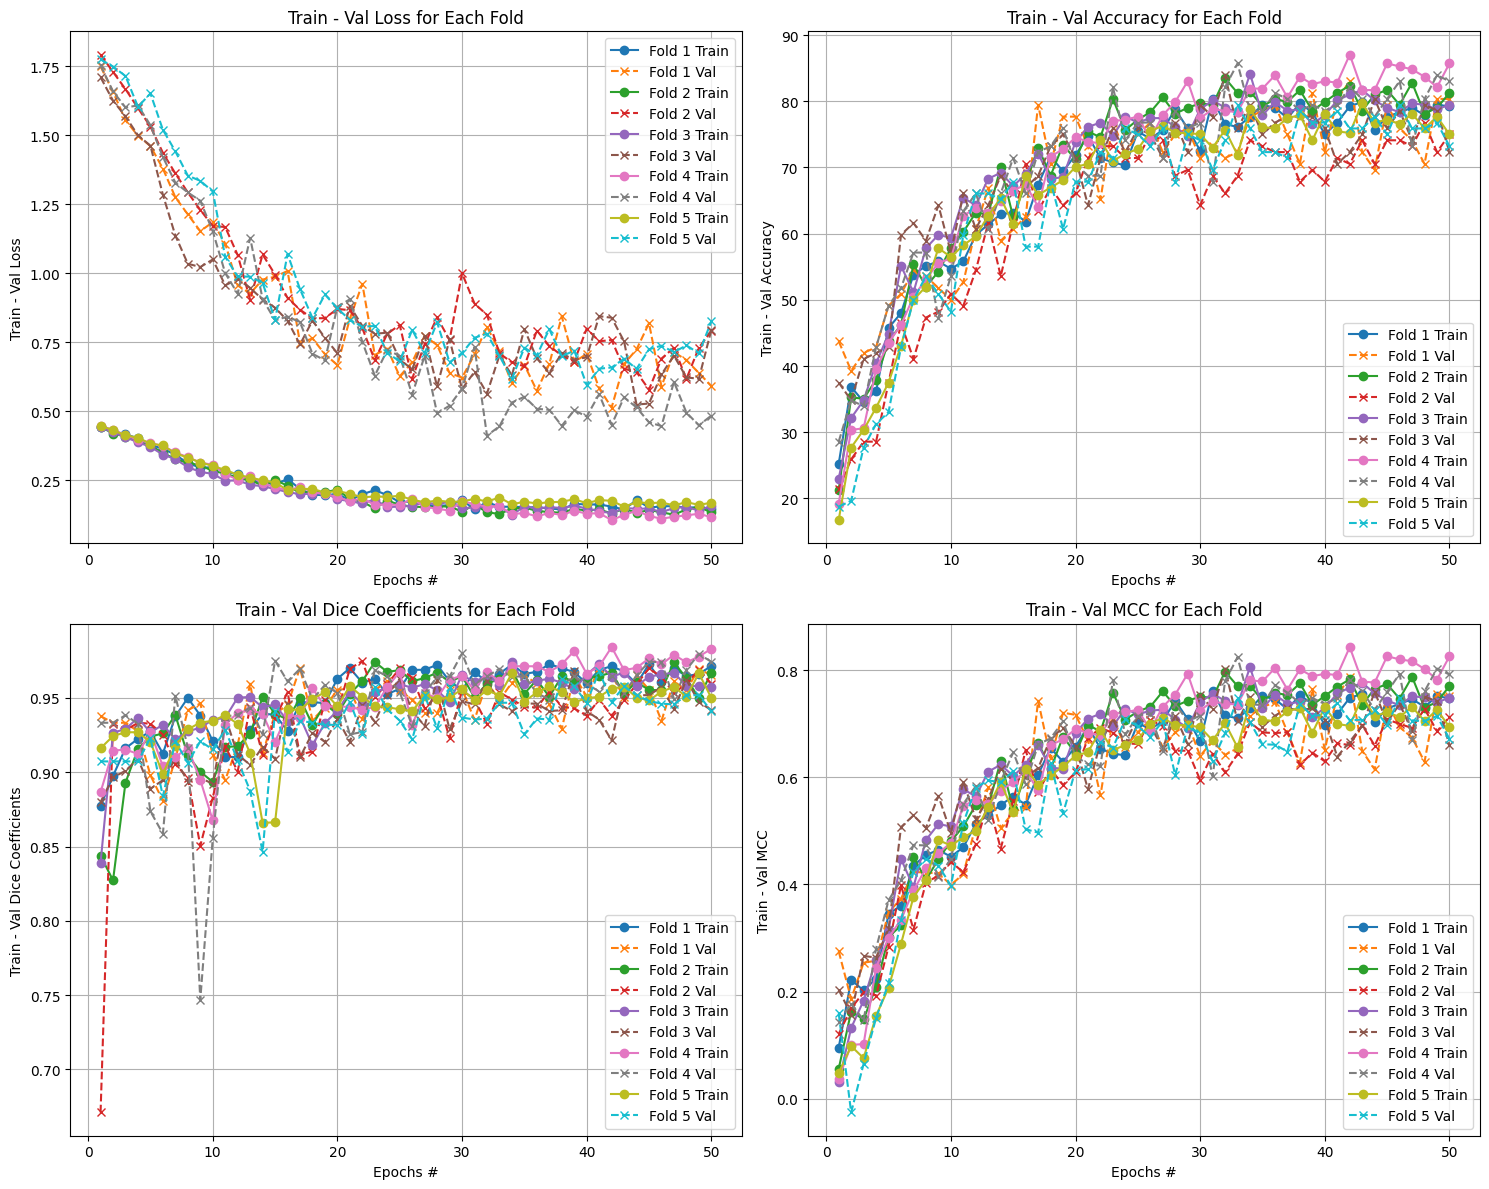

In [ ]:

#------------------------------------------------------------------------------
## PLOT the Metrics train and val loss, accuracies, dices and mcc's
#------------------------------------------------------------------------------

import matplotlib.pyplot as plt

num_folds = 5
epochs_per_fold = 50

# Metrics for plotting
epochs = [metrics['epoch'] for metrics in fold_metrics]
train_loss = [metrics['train_loss'] for metrics in fold_metrics]
train_accuracy = [metrics['train_accuracy'] for metrics in fold_metrics]
train_dice = [metrics['train_dice'] for metrics in fold_metrics]
train_mcc = [metrics['train_mcc'] for metrics in fold_metrics]
val_loss = [metrics['val_loss'] for metrics in fold_metrics]
val_accuracy = [metrics['val_accuracy'] for metrics in fold_metrics]
val_dice = [metrics['val_dice'] for metrics in fold_metrics]
val_mcc = [metrics['val_mcc'] for metrics in fold_metrics]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes = axes.flatten()

metrics = [
    ('Train - Val Loss', train_loss, val_loss),
    ('Train - Val Accuracy', train_accuracy, val_accuracy),
    ('Train - Val Dice Coefficients', train_dice, val_dice),
    ('Train - Val MCC', train_mcc, val_mcc),
]

for i, (metric_name, train_data, val_data) in enumerate(metrics):
    ax = axes[i]

    for fold in range(num_folds):
        start_idx = fold * epochs_per_fold
        end_idx = (fold + 1) * epochs_per_fold

        fold_epochs = epochs[start_idx:end_idx]
        fold_train_data = train_data[start_idx:end_idx]
        fold_val_data = val_data[start_idx:end_idx]

        ax.plot(fold_epochs, fold_train_data, label=f"Fold {fold + 1} Train", linestyle='-', marker='o')
        ax.plot(fold_epochs, fold_val_data, label=f"Fold {fold + 1} Val", linestyle='--', marker='x')

    ax.set_title(f'{metric_name} for Each Fold')
    ax.set_xlabel('Epochs #')
    ax.set_ylabel(metric_name)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
fig.savefig('fold_metrics_plot.png', dpi=600)
plt.show()


In [ ]:


#-----------------------TEST Phase--------------------------------------------

from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, confusion_matrix


albumentations_transforms = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(),
    ToTensor()
])

class Transform():
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image):
        return self.transform(image=np.array(image))["image"]

test_dir = 'C:/Users/ProArt/Desktop/ozan/opticdisc/Test'
#batch_size = 16


def test_model(model, test_loader, device):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    mcc = matthews_corrcoef(all_labels, all_preds)
    dice = f1_score(all_labels, all_preds, average="macro")
    class_names = ['Atrophy', 'Cupping', 'Drusen', 'Normal', 'Papilledema', 'Tilted']
    all_preds_str = [class_names[pred] for pred in all_preds.numpy()]
    all_labels_str = [class_names[label] for label in all_labels.numpy()]

    confmat = confusion_matrix(all_labels_str, all_preds_str, labels=class_names)


    return accuracy, mcc, dice, confmat

def main():

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    test_dataset = ImageFolder(test_dir, transform=Transform(albumentations_transforms))
    batch_size = len(test_dataset)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    best_epoch_index = max(range(len(fold_metrics)), key=lambda i: (fold_metrics[i]['val_accuracy'], -fold_metrics[i]['val_loss']))
    best_model_metrics = fold_metrics[best_epoch_index]
    fold_number = int(np.ceil(best_epoch_index/50))
    best_epoch = best_model_metrics['epoch']
    checkpoint_path = f"C:/Users/ProArt/Desktop/ozan/opticdisc/checkpoints/best_model_fold_{fold_number}_epoch_{best_epoch}.pth"

    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)
    model.eval()

    accuracy, mcc, dice, confmat = test_model(model, test_loader, device)
    print("\n")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"Test MCC: {mcc:.4f}")
    print(f"Test Dice: {dice:.4f}")
    print(f"Confusion Matrix: \n{confmat}")

if __name__ == "__main__":
    main()

C:\Users\ProArt\AppData\Local\Temp\ipykernel_66756\1321713664.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))
100%|██



Test Accuracy: 90.00%
Test MCC: 0.8792
Test Dice: 0.8891
Confusion Matrix: 
[[18  0  0  0  0  2]
 [ 0 19  0  1  0  0]
 [ 0  0 20  0  0  0]
 [ 1  0  0 39  0  0]
 [ 0  0  1  1 18  0]
 [ 2  0  4  2  0 12]]


In [ ]:
!pip install grad-cam

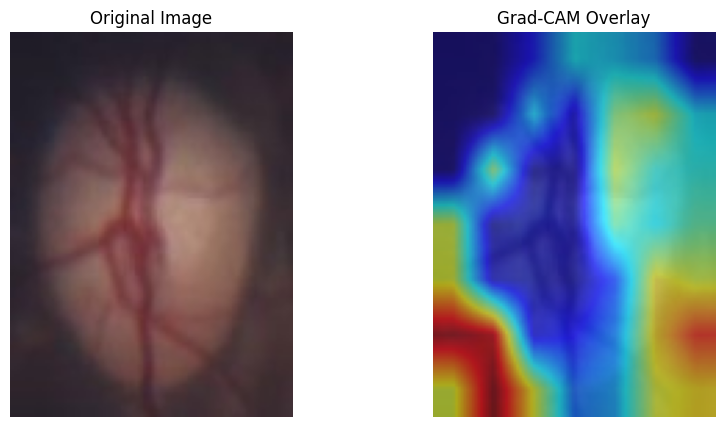

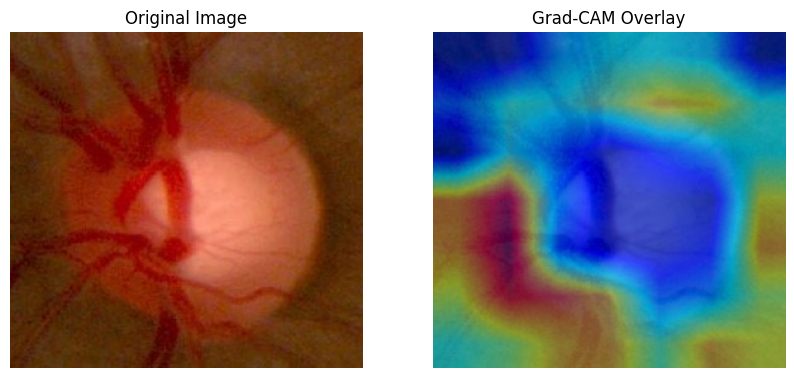

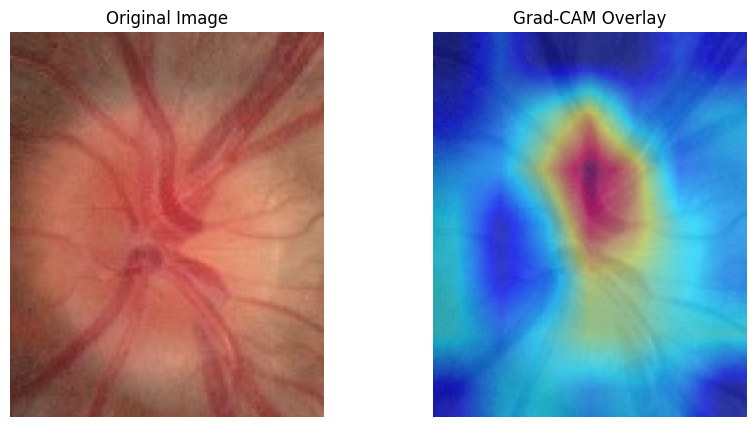

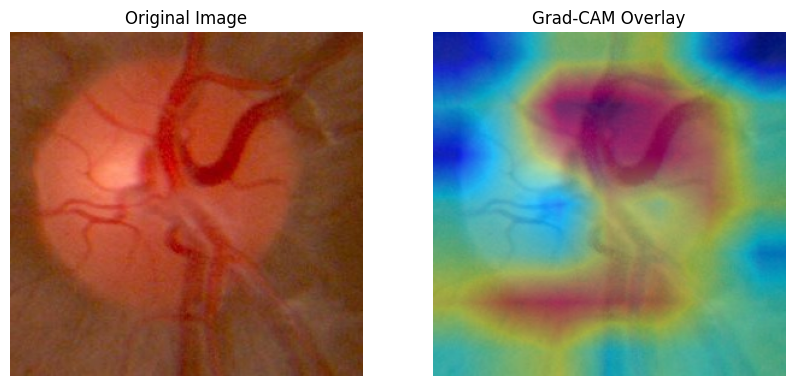

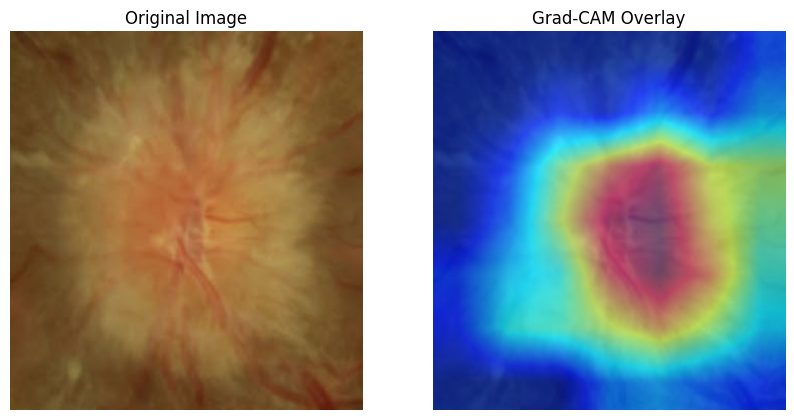

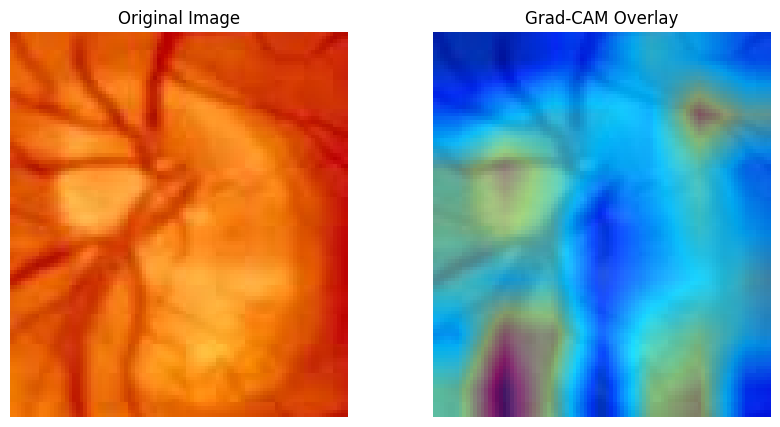

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)
    return image, input_tensor

def show_grad_cam(image, cam):
    image = np.array(image) / 255.0
    image = image.astype(np.float32)
    image_bgr = image[:, :, ::-1]
    cam_resized = cv2.resize(cam, (image_bgr.shape[1], image_bgr.shape[0]))

    result = show_cam_on_image(image_bgr, cam_resized, use_rgb=True)


    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.axis('off')
    plt.title("Grad-CAM Overlay")
    plt.show()


example_images = {
    "Atrophy": "C:/Users/ProArt/Desktop/ozan/opticdisc/Test/Atrophy/214.jpg",
    "Cupping": "C:/Users/ProArt/Desktop/ozan/opticdisc/Test/Cupping/848.jpg",
    "Drusen": "C:/Users/ProArt/Desktop/ozan/opticdisc/Test/Drusen/185.jpg",
    "Normal": "C:/Users/ProArt/Desktop/ozan/opticdisc/Test/Normal/735.jpg",
    "Papilledema": "C:/Users/ProArt/Desktop/ozan/opticdisc/Test/Papilledema/Picture4.png",
    "Tilted": "C:/Users/ProArt/Desktop/ozan/opticdisc/Test/Tilted/Tilted43.png"
}

model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

resnet_target = model.resnet.layer4[2].conv3
efficientnet_target = model.efficientnet.conv_head

target_layers = [resnet_target, efficientnet_target]
grad_cam = GradCAM(model=model, target_layers=target_layers)

for class_name, image_path in example_images.items():
    original_image, input_tensor = preprocess_image(image_path)
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_class = torch.max(output, 1)

    targets = [ClassifierOutputTarget(predicted_class.item())]
    cam = grad_cam(input_tensor, targets=targets)[0]
    show_grad_cam(original_image, cam)